# Weather Forecasting  Project 

**Brief description of the dataset**

This dataset provides training data on weather from 1st January 2013 to 31st December 2016. An additional testing set is available, enclosing the period 1st January 2017 to 31st March 2017, which corresponds to the forecast interval. There are 4 parameters describing weather, that are *meantemp*, *humidity*, *wind_speed*, and *meanpressure*.

# Step 1: Loading, cleaning and transformation of the data

In this phase, we focus on importing the dataset into the Jupyter Notebook environment. Our main goal here is to take a first look at the data and figure out what cleaning and transformation are needed.

In [41]:
import numpy as np
import pandas as pd
import statsmodels.api as sm 
import sklearn 
from scipy import stats,signal
from sklearn.linear_model import LinearRegression
from datetime import datetime
from statsmodels.tsa.exponential_smoothing.ets import ETSModel 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from pmdarima.arima.utils import ndiffs

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product


from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.stats.stattools import durbin_watson
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
#%matplotlib inline
#plt.style.use('seaborn')
sns.set(style="whitegrid")

In [3]:
train_data = pd.read_csv("Weather_ForecastingTrain.csv", na_values='', sep=',', index_col='date', parse_dates=['date'])
test_data = pd.read_csv("Weather_ForecastingTest.csv", na_values='', sep=',', index_col='date', parse_dates=['date'])
display(train_data)

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000
...,...,...,...,...
2016-12-27,16.850000,67.550000,8.335000,1017.200000
2016-12-28,17.217391,68.043478,3.547826,1015.565217
2016-12-29,15.238095,87.857143,6.000000,1016.904762


In [5]:
train_data = round(train_data, 2)
train_data.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.00,84.50,0.00,1015.67
2013-01-02,7.40,92.00,2.98,1017.80
2013-01-03,7.17,87.00,4.63,1018.67
2013-01-04,8.67,71.33,1.23,1017.17
2013-01-05,6.00,86.83,3.70,1016.50


**Data Loading, Indexing and Data Type Conversion**:
After loading the data, we've set the 'date' column as the index, providing a unique identifier for each row. This facilitates easier manipulation and analysis of time-series data. We've also converted the 'date' column from a string to a datetime format, allowing us to perform time-based visualizations and analyses. To maintain consistency and readability, numerical data has been rounded to two decimal places, making the analysis process smoother.

In [4]:
null_elem = train_data.isnull().sum().sum()
print('Total number of NaN in Units is:',null_elem)

Total number of NaN in Units is: 0


In [5]:
duplicated_indexes = train_data[train_data.duplicated(keep=False)]

if len(duplicated_indexes) > 0:
    print(f"There are {len(duplicated_indexes)} duplicated indexes: {duplicated_indexes}")
else:
    print("There are no duplicated indexes.")

There are no duplicated indexes.


**Missing Values and Duplicates Check**: We've conducted  checks to identify and handle any missing values and duplicate indexes in the dataset. This ensures the integrity and uniqueness of the data, which are essential for accurate analysis.

It is confirmed that there are no missing values or duplicated indexes. This means there's no need for imputation or removing duplicates.

**With the data now cleaner and appropriately transformed, we're ready to move into the next phase.**

# Step 2: Descriptive statistics and frequency analysis

**Descriptive Statistics:**
We start our exploratory data analysis by examining the descriptive statistics of the dataset. These statistics provide insights into the central tendency, variability, and distribution shape of each variable. Key metrics include mean, median, standard deviation, minimum, maximum, and quartiles.

In [6]:
stats = train_data.describe()
print(stats)

          meantemp     humidity   wind_speed  meanpressure
count  1461.000000  1461.000000  1461.000000   1461.000000
mean     25.506127    60.744851     6.806865   1011.101197
std       7.339416    16.743928     4.559688    180.293335
min       6.000000    13.428571     0.000000     -3.041667
25%      18.857143    50.375000     3.475000   1001.571429
50%      27.714286    62.625000     6.250000   1008.555556
75%      31.312500    72.125000     9.250000   1014.937500
max      38.714286    98.000000    42.220000   7679.333333


### Time Series Analysis

After analyzing basic statistics, we are continuing to explore time series patterns by creating additional time series plots. Here, we aim to extract valuable information about trends, seasonality, outliers, and patterns from our time series data. Time series plots will provide a clearer picture of how weather parameters change over time, essential for effective forecasting.

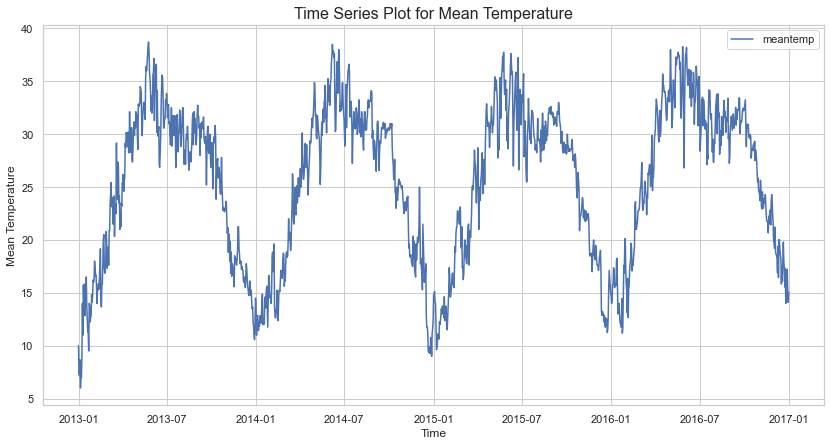

In [7]:
plt.figure(figsize=(14, 7))
plt.plot(train_data.meantemp, label='meantemp')
plt.title('Time Series Plot for Mean Temperature', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Mean Temperature')
plt.grid(True)
plt.legend(frameon=True, loc='upper right');
plt.savefig("Meantemp_Timeplot.png") 
plt.show()

The time series analysis of the Mean Temperature data reveals several key characteristics vital for our forecasting model. Firstly, a pronounced **seasonal pattern** is evident, with peaks and troughs recurring annually, corresponding to the expected warmer and cooler months, respectively. This seasonality is a primary feature with no significant long-term **trends** detected, indicating stable mean temperatures across the years. The **variability** within the data remains consistent, with the annual extremes appearing at similar levels throughout the observed period, reinforcing the reliability of the seasonal pattern. Notably, the time series does not exhibit any longer-term **cyclical changes** or abrupt **anomalies**, suggesting a stable and predictable temperature pattern without significant outliers. The **extremes** in temperature, both high and low, occur regularly around the same time each year, further validating the seasonal behavior of the dataset. The absence of sudden shifts or **stability** issues in the mean temperature levels suggests that the underlying process generating the data has been steady, making it an ideal candidate for seasonal time series forecasting models.

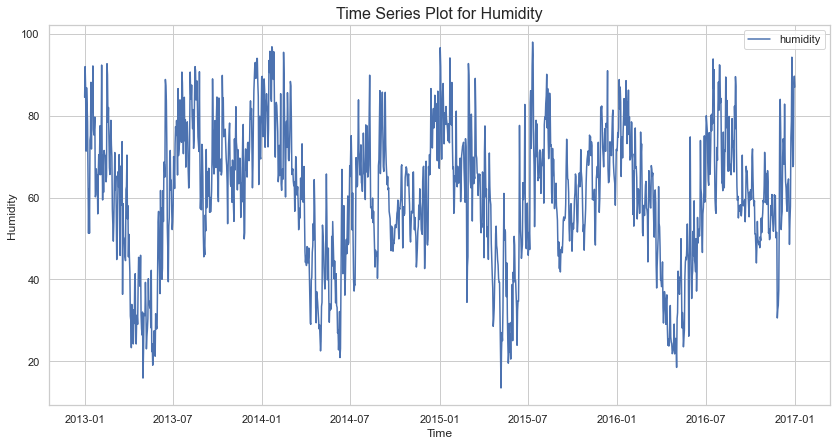

In [8]:
plt.figure(figsize=(14, 7))
plt.plot(train_data.humidity,label='humidity') 
plt.title('Time Series Plot for Humidity', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Humidity')
plt.grid(True)
plt.legend(frameon=True, loc='upper right');
plt.show()

The time series plot for humidity indicates a data set with considerable complexity. The plot does not display a straightforward seasonal pattern, with irregular fluctuations ranging from 20% to 100% humidity. This indicates a high degree of **variability** without a discernible long-term **trend**, suggesting stable mean humidity levels over time. Notable **anomalies** in the form of sharp peaks and drops may represent atmospheric events or require further investigation to determine their significance. While there seems to be a seasonal pattern to the extreme low humidity levels, the overall **stability** of the time series is periodically disrupted by these extreme variations. The data also exhibits a considerable amount of **noise**, presenting challenges for forecasting models.

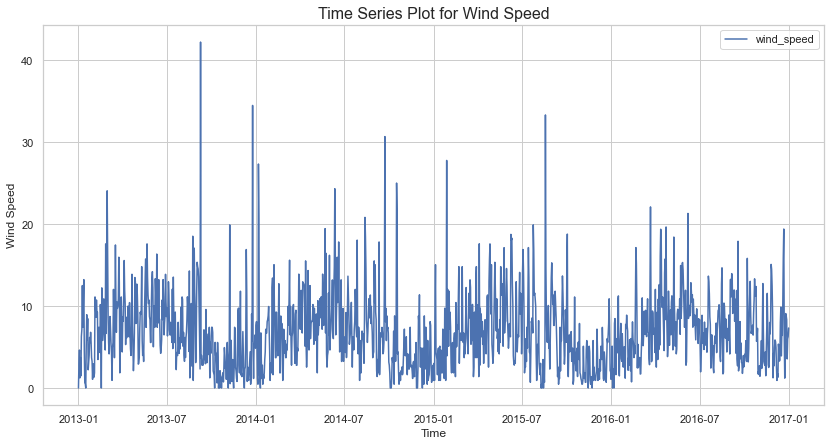

In [9]:
plt.figure(figsize=(14, 7))
plt.plot(train_data.wind_speed, label='wind_speed')
plt.title('Time Series Plot for Wind Speed', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Wind Speed')
plt.grid(True)
plt.legend(frameon=True, loc='upper right');
plt.show()

The time series plot for wind speed reveals a complex dataset with no discernible **seasonal patterns** or long-term **trends**, which distinguishes it from the more predictable temperature behavior. Wind speed exhibits high **variability** with numerous spikes indicating sporadic high wind events. The lack of clear patterns in these **anomalies** and **extremes** points to the irregular nature of wind speed, which is characterized by a mix of calm periods and unpredictable gusts. Despite this, the baseline wind speed shows a degree of **stability** without significant shifts in average conditions.

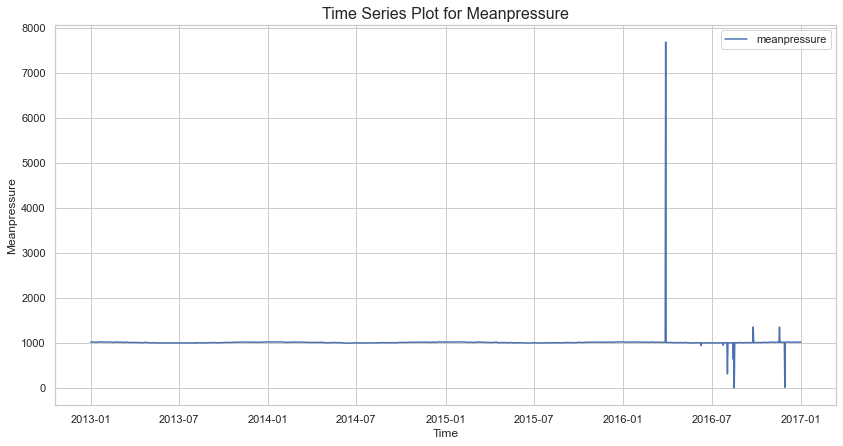

In [10]:
plt.figure(figsize=(14, 7))
plt.plot(train_data.meanpressure, label='meanpressure')
plt.title('Time Series Plot for Meanpressure', fontsize=16)
plt.xlabel('Time')
plt.ylabel('Meanpressure')
plt.grid(True)
plt.legend(frameon=True, loc='upper right');
plt.show()

The time series plot for mean pressure indicates a high degree of **stability** in atmospheric pressure, with minimal **variability** and little to no noise across the majority of the dataset. There is an absence of any clear **trend** or **seasonality**, suggesting that pressure remains consistent irrespective of the time of year. However, the plot is characterized by a few significant **anomalies**, including some particularly sharp spikes in 2016. These outliers could represent rare atmospheric events.

### Histograms

After our initial data exploration, we now move forward to a deeper analysis to gain a more comprehensive understanding of our dataset. We will plot **histograms** for each variable to know the distribution patterns of the data and the frequency of each value per variable.

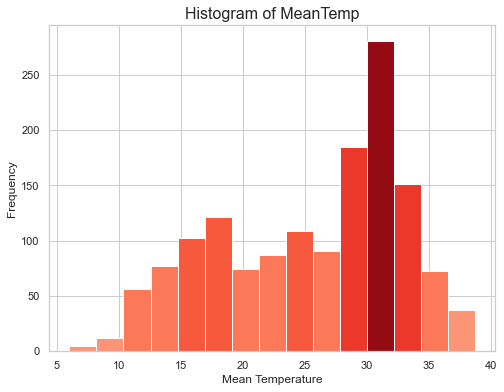

In [11]:
num_colors = 10
palette = sns.color_palette("Reds", n_colors=num_colors)[3:]
meantemp = train_data['meantemp']

binwidth = (max(meantemp) - min(meantemp)) / 15
counts, bin_edges = np.histogram(meantemp, bins=np.arange(min(meantemp), max(meantemp) + binwidth, binwidth))
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
bin_colors = [palette[int(np.interp(x, [min(counts), max(counts)], [0, len(palette)-1]))] for x in counts]

plt.figure(figsize=(8, 6))
for i in range(len(counts)):
    color_index = int(np.interp(counts[i], [min(counts), max(counts)], [0, len(palette)-1]))
    plt.bar(bin_centers[i], counts[i], color=palette[color_index], width=binwidth)

plt.xlabel('Mean Temperature')
plt.ylabel('Frequency')
plt.title('Histogram of MeanTemp', fontsize=16)
plt.show()

The histogram analysis of 'meantemp' data, with 30 bins, indicates a **unimodal** distribution centered around the 25 to 30 degrees range, reflecting the dataset's **central tendency** and **mode**. The spread of temperatures is considerable, stretching from just over 5 to just under 40 degrees Celsius, showcasing the dataset's **diversity**. The **shape** resembles a bell curve with a **slight left skew**, suggesting a normal or **near-normal distribution**, characterized by a single peak with no significant **outliers** as frequencies diminish symmetrically from the central peak. This **variability** and **concentration of values** around the mode highlight the range's **non-uniformity**, which is pivotal for in-depth statistical analysis and enhancing ours model's accuracy.

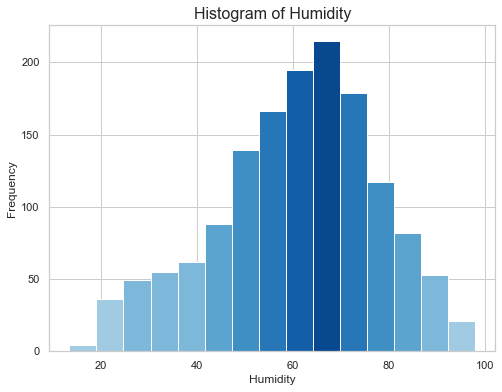

In [12]:
num_colors = 10
palette = sns.color_palette("Blues", n_colors=num_colors)[3:]
humidity = train_data['humidity']

binwidth = (max(humidity) - min(humidity)) / 15
counts, bin_edges = np.histogram(humidity, bins=np.arange(min(humidity), max(humidity) + binwidth, binwidth))
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
bin_colors = [palette[int(np.interp(x, [min(counts), max(counts)], [0, len(palette)-1]))] for x in counts]

plt.figure(figsize=(8, 6))
for i in range(len(counts)):
    color_index = int(np.interp(counts[i], [min(counts), max(counts)], [0, len(palette)-1]))
    plt.bar(bin_centers[i], counts[i], color=palette[color_index], width=binwidth)

plt.xlabel('Humidity')
plt.ylabel('Frequency')
plt.title('Histogram of Humidity', fontsize=16)
plt.show()

The histogram of humidity reveals a **unimodal distribution**, centered around 60% humidity. This reflects the central tendency and the mode of the humidity levels. The data exhibits a considerable **spread**, ranging from roughly 15% to 95% humidity, highlighting the diversity in humidity conditions. The distribution appears close to **symmetrical with a slight positive skew** towards higher humidity values. This suggests a **near-normal distribution** with no prominent **outliers**. The observed **variability** and concentration of values around the mode emphasize the **non-uniformity** of humidity levels, which is valuable for understanding weather patterns and potentially improving our forecasting model's accuracy.

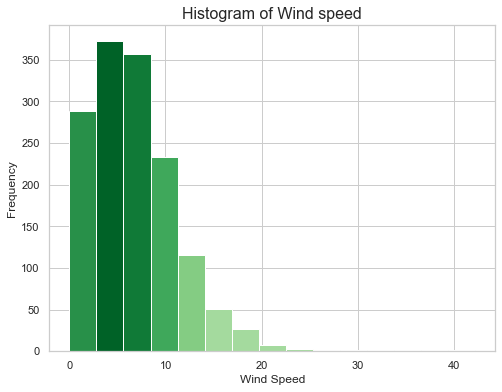

In [13]:
num_colors = 10
palette = sns.color_palette("Greens", n_colors=num_colors)[3:]
wind_speed = train_data['wind_speed']

binwidth = (max(wind_speed) - min(wind_speed)) / 15
counts, bin_edges = np.histogram(wind_speed, bins=np.arange(min(wind_speed), max(wind_speed) + binwidth, binwidth))
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
bin_colors = [palette[int(np.interp(x, [min(counts), max(counts)], [0, len(palette)-1]))] for x in counts]

plt.figure(figsize=(8, 6))
for i in range(len(counts)):
    color_index = int(np.interp(counts[i], [min(counts), max(counts)], [0, len(palette)-1]))
    plt.bar(bin_centers[i], counts[i], color=palette[color_index], width=binwidth)

plt.xlabel('Wind Speed')
plt.ylabel('Frequency')
plt.title('Histogram of Wind speed', fontsize=16)
plt.show()

The histogram of wind speed reveals a **right-skewed distribution**, with most data points clustering near **lower wind speeds** and fewer occurrences as wind speed increases. The most frequent wind speed (**mode**) is likely concentrated around the lower end and the average wind speed (**central tendency**) is also likely skewed towards the **lower range** due to the asymmetry. The data covers a wind speed range of minimal values up to 40 mph or higher, indicating occasional strong winds. There might be a few potential outliers on the extreme right, representing very high wind speeds that differ significantly from the majority of the data. This observed **skewness**, **spread of values**, and presence of possible **outliers** highlight the **non-uniformity** of wind speeds.

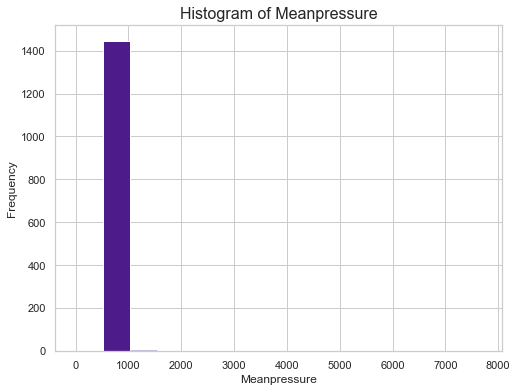

In [14]:
num_colors = 10
palette = sns.color_palette("Purples", n_colors=num_colors)[3:]
meanpressure = train_data['meanpressure']

binwidth = (max(meanpressure) - min(meanpressure)) / 15
counts, bin_edges = np.histogram(meanpressure, bins=np.arange(min(meanpressure), max(meanpressure) + binwidth, binwidth))
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
bin_colors = [palette[int(np.interp(x, [min(counts), max(counts)], [0, len(palette)-1]))] for x in counts]

plt.figure(figsize=(8, 6))
for i in range(len(counts)):
    color_index = int(np.interp(counts[i], [min(counts), max(counts)], [0, len(palette)-1]))
    plt.bar(bin_centers[i], counts[i], color=palette[color_index], width=binwidth)

plt.xlabel('Meanpressure')
plt.ylabel('Frequency')
plt.title('Histogram of Meanpressure', fontsize=16)
plt.show()

The histogram of meanpressure shows a distribution that is largely concentrated around a **central range**, with a steep peak indicating a strong **mode**. This suggests that most of the atmospheric pressure values fall within a narrow band, denoting consistent pressure conditions over the period of observation. Notable in this histogram are a few **outliers**, particularly visible as separate, individual bars detached from the main distribution. These outliers could be indicative of rare, extreme pressure events or anomalies in the data. The concentrated nature of the distribution, apart from these anomalies, points towards a stable atmospheric pressure pattern.

### Box Plots

In addition, we will employ **box plots** to further delve into the data's distribution, particularly examining the spread, the central tendency and identifying potential outliers. By analyzing the boxplots for each year, we will discern the stability of our weather parameters and confirm their suitability for time series forecasting.

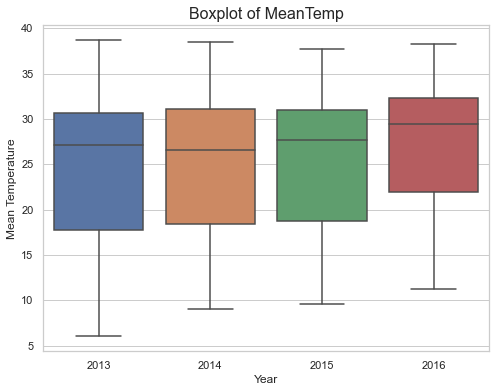

In [15]:
train_data['date'] = train_data.index.to_period('Y')

plt.figure(figsize=(8, 6))
sns.boxplot(x=train_data['date'], y=meantemp)
plt.title('Boxplot of MeanTemp', fontsize=16)
plt.xlabel('Year') 
plt.ylabel('Mean Temperature')
plt.show()

The boxplot analysis of **Mean Temperature** over the years showcases a **consistent median** (the median line within each box appears relatively unchanged), suggesting a **stable central tendency** and consistent average temperatures. The **interquartile ranges** are similar across years, with minimal **outliers** and a slight increase in spread in 2016, indicating that the middle 50% of temperatures are spread similarly year over year. The distribution of data around the median is **symmetric**, implying a **balanced spread** of temperatures without significant skewness. The symmetry around the median and the absence of significant year-to-year variability or skewness support the reliability of the data for forecasting models, as it suggests predictable, stable behavior without significant shifts in the central tendency or variability.

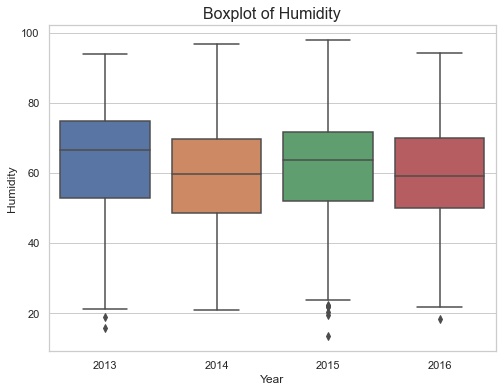

In [16]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=train_data['date'], y=humidity)
plt.title('Boxplot of Humidity', fontsize=16)
plt.xlabel('Year') 
plt.ylabel('Humidity') 
plt.show()

The boxplot analysis across different years shows that **humidity levels** have a slight variation in **median values** but exhibits a stable **range** and **interquartile spread**, with no significant shifts or trends. The **whiskers**, which indicate the variability outside the upper and lower quartiles, also show **consistency**, barring a few **outliers**. This suggests a consistent pattern with occasional **extremes**, which need to be considered in forecasting models for an accurate prediction.

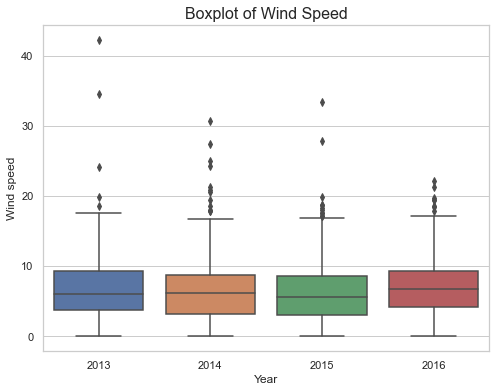

In [17]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=train_data['date'], y=wind_speed)
plt.title('Boxplot of Wind Speed', fontsize=16)
plt.xlabel('Year') 
plt.ylabel('Wind speed')
plt.show()

The **wind speed** boxplot reveals a **consistent pattern** over the years with a **narrow interquartile range**, suggesting that most of the wind speed values are concentrated around the **median**. **Whiskers** extend occasionally to show occasional gusty conditions, but **outliers** are minimal, indicating the rarity of **extreme wind speeds**. This stable pattern with consistent median values is beneficial for effective forecasting of wind-based phenomena.

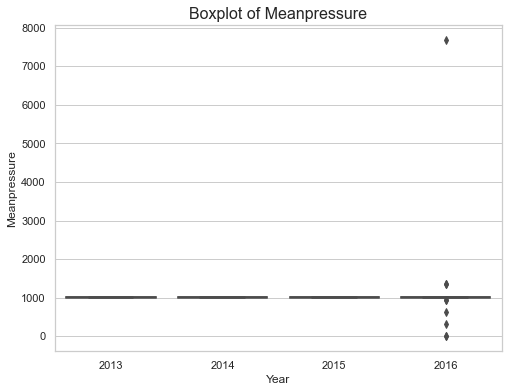

In [18]:
plt.figure(figsize=(8, 6))
sns.boxplot(x=train_data['date'], y=meanpressure)
plt.title('Boxplot of Meanpressure', fontsize=16)
plt.xlabel('Year') 
plt.ylabel('Meanpressure')
plt.show()

The boxplot of **meanpressure** illustrates minimal yearly variation, with **median pressure values** remaining steady over time. **The interquartile range** is narrow, suggesting low variability in pressure readings. There are almost no **outliers**, indicating that extreme pressure deviations are uncommon. The data's stability suggests that atmospheric pressure remains constant and predictable.

### Scatter Plots and Correlation Matrix

Continuing with our analysis, we proceed to examine the relationships between our variables. **Scatter plots** will provide a visual understanding of these relationships, allowing us to observe the potential linear correlations or patterns between pairs of variables and the **correlation matrix** to numerically measure the strength and direction of linear relationships between variables.

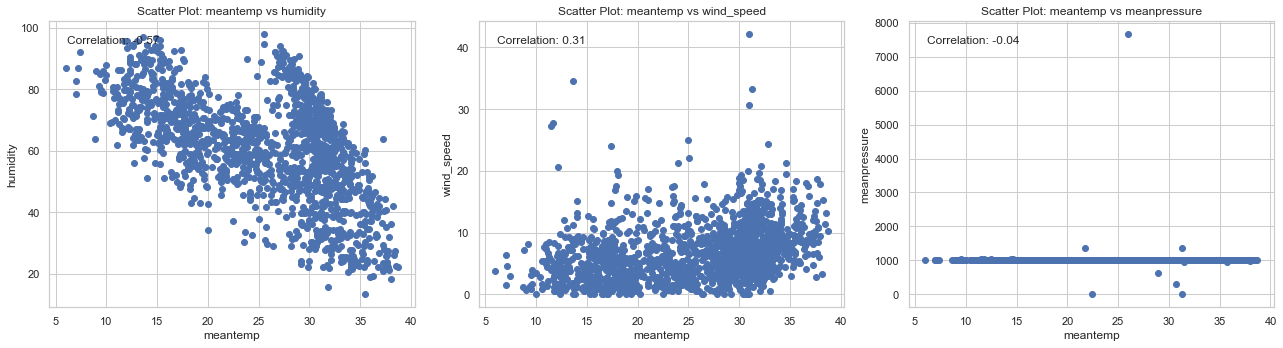

In [19]:
def plot_scatter_and_correlation(dataframe, x, y, position, ax):
    ax[position].scatter(dataframe[x], dataframe[y])
    ax[position].set_xlabel(x)
    ax[position].set_ylabel(y)
    ax[position].set_title(f'Scatter Plot: {x} vs {y}')
    
    corr = np.corrcoef(dataframe[x], dataframe[y])[0, 1]
    ax[position].annotate(f'Correlation: {corr:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', ha='left', va='top')

fig, ax = plt.subplots(1, 3, figsize=(18, 5))
plot_scatter_and_correlation(train_data, 'meantemp', 'humidity', 0, ax)
plot_scatter_and_correlation(train_data, 'meantemp', 'wind_speed', 1, ax)
plot_scatter_and_correlation(train_data, 'meantemp', 'meanpressure', 2, ax)
plt.tight_layout()
plt.show()

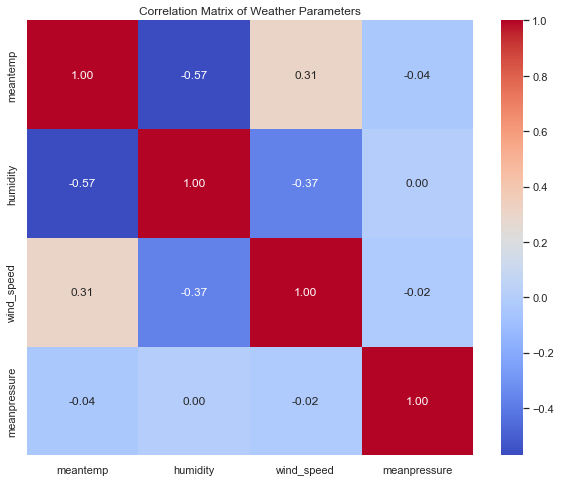

In [20]:
correlation_matrix = train_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Weather Parameters")
plt.show()

- **Temperature vs. Humidity**: The correlation coefficient of `-0.57` indicates a moderate negative correlation, implying that, generally, as the mean temperature increases, humidity tends to decrease, and vice versa.
- **Temperature vs. Wind Speed**: A weak positive correlation of `0.30` is observed between mean temperature and wind speed. This indicates a slight tendency for wind speed to increase with rising temperatures, but the relationship is not very strong.
- **Humidity vs. Wind Speed**: The `-0.37` correlation indicates a weak inverse relationship, suggesting that higher wind speeds might correspond to lower humidity levels.
- **Pressure Independence**: Mean pressure demonstrates very weak correlations with temperature, humidity, and wind speed, suggesting that pressure changes are largely independent of the other measured parameters. There is a very weak negative correlation `-0.04` between mean temperature and mean pressure, suggesting almost no linear relationship between these two variables.

# Step 3: Describing the time series patterns

### Decomposition

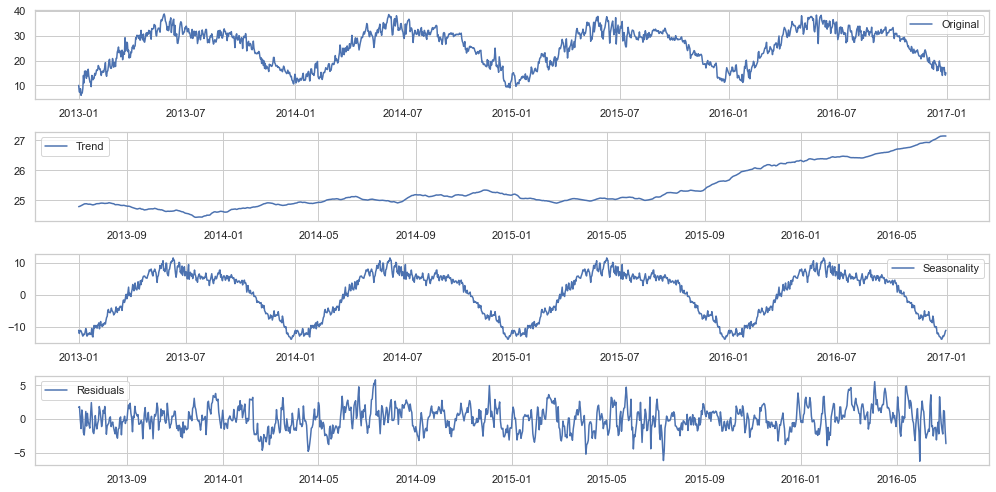

In [21]:
decomposition = seasonal_decompose(train_data['meantemp'], model='additive', period=365)
plt.figure(figsize=(14, 7))
plt.subplot(411)
plt.plot(decomposition.observed, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

The decomposition plot of mean temperature using the additive model aligns well with our initial observations.

- **Original**: This line matches the original mean temperature time series. It clearly shows the cyclical pattern of temperature throughout the year.

- **Trend**: The trend component exhibits a gentle **upward slope**, suggesting a potential **long-term increase** in average temperature over the analyzed period.

- **Seasonality**: This component isolates the seasonal pattern, highlighting the cyclical ups and downs in temperature throughout the year. The wave-like pattern closely resembles the seasonal variations observed in the original time series.

- **Residuals**: The residuals appear **randomly scattered around zero**. This indicates that after capturing the trend and seasonality, the residuals don't follow any particular pattern. This is a positive sign, suggesting that the decomposition has effectively separated the underlying patterns from the random noise in the data.

Overall, there's a **clear seasonal pattern** with **stable mean temperatures** and **minimal long-term trends**. The random scattering of residuals suggests the decomposition has effectively separated the signal from the noise.

### Checking Stationarity

In order to check for the **stationarity of a time series**, different operations and statistical tests can be done, in particular:
- evaluating rolling statistics (generally mean and standard deviation)
- ACF plot: for a stationary time series the ACF will drop to zero relatively quickly, while the ACF of non-stationary data decreases slowly
- Unit root tests: Statistical hypothesis tests of stationarity that are designed for determining whether differencing is required. ADF (Augmented Dickey-Fuller) and KPSS (Kwiatkowski-Phillips-Schmidt-Shin) tests are the main ones.

### Rolling Statistics

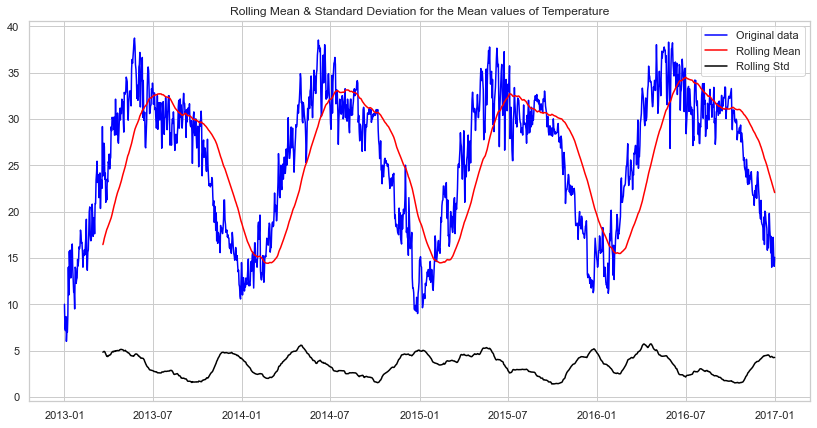

In [22]:
rolling_mean = train_data['meantemp'].rolling(80).mean()
rolling_std = train_data['meantemp'].rolling(80).std()
plt.figure(figsize=(14, 7))
plt.plot(train_data['meantemp'], color='blue',label='Original data')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation for the Mean values of Temperature')
plt.show()

The **rolling mean** shows a repeating pattern that corresponds with the seasons, rising and falling in a consistent manner each year. This indicates a seasonal effect, which is a form of seasonality and suggests that the mean of the data is not constant over time.
The **rolling standard deviation** appears relatively constant over time, indicating that the variability of the data might not be changing. However, the constancy of the standard deviation alone does not imply stationarity.
The data appear to be **non-stationary** because they exhibit clear seasonality.


### ACF Plot

The ACF plot is useful for identifying non-stationary time series. For a stationary time series, the ACF will drop to zero relatively quickly, while the ACF of non-stationary data decreases slowly.

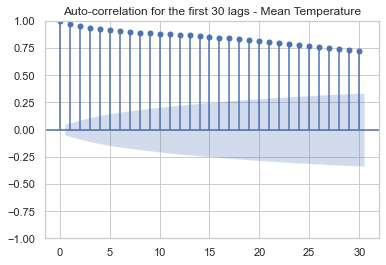

In [23]:
plot_acf(train_data['meantemp'], lags=30, title='Auto-correlation for the first 30 lags - Mean Temperature');

The ACF plot of MeanTemp is slowly decreasing and therefore does not follow a stationary form, so we have to apply the difference method to check if it goes more stationary and if not we apply another difference.

Data are clearly **non-stationary**, with seasonality and a non-linear trend. As first step we perfom a **seasonal difference**

- Note: A seasonal difference is the difference between an observation and the previous observation from the same season. This is also called “lag-m difference”, as we subtract the observation after a lag of m periods. Sometimes it is necessary to take both a seasonal difference and a first difference to obtain stationary data. 


Since our data have a **strong seasonal pattern**, seasonal differencing should be done first, as the resulting series will sometimes be already stationary.

### ACF and PACF plots after seasonal differencing

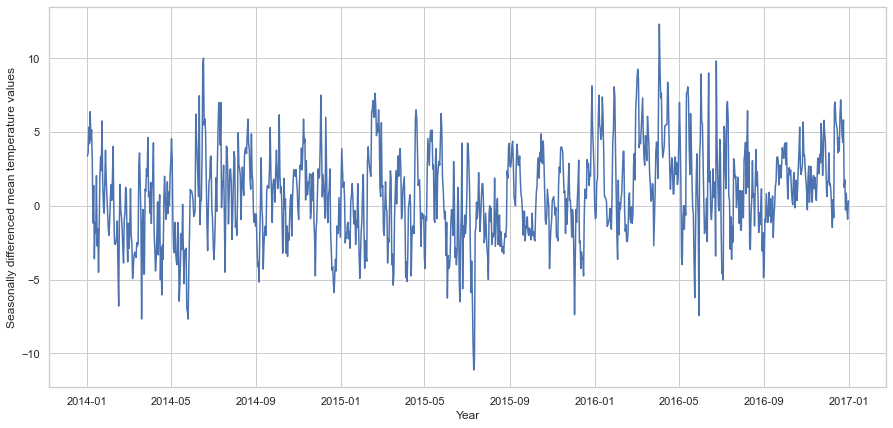

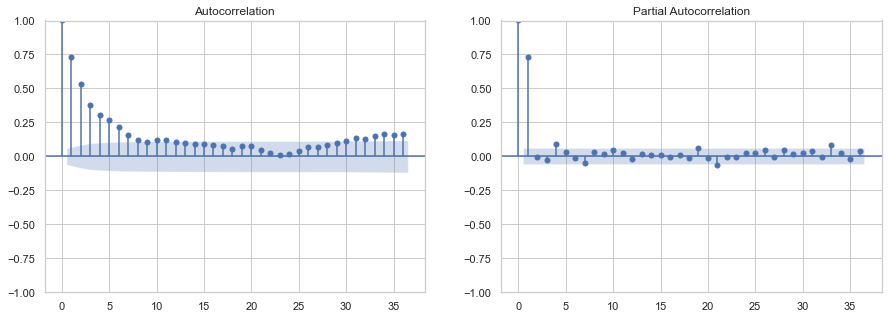

In [24]:
# Applying seasonal differencing
seasonally_diff = train_data['meantemp'].diff(365).dropna() #inplace=True

plt.figure(figsize=(15, 7))
plt.plot(seasonally_diff)
plt.xlabel('Year')
plt.ylabel('Seasonally differenced mean temperature values');

fig, ax = plt.subplots(1, 2, figsize=(15,5))
plot_acf(seasonally_diff, lags=36, ax=ax[0]);
plot_pacf(seasonally_diff, lags=36, ax=ax[1]);

The ACF and PACF plots of the seasonally differenced mean temperature data exhibit encouraging signs of **stationarity**. The quick decline in correlations at lags beyond zero in the ACF plot and the absence of significant spikes in the PACF plot suggest that seasonal differencing has successfully removed **trends** and **seasonality**. We will 
proceed with formal **unit root tests** (ADF and KPSS) to statistically confirm this stationarity and move forward with time series forecasting models.

In [30]:
# First order differencing
#train_data['difference1'] = train_data['meantemp'].diff()
#train_data.dropna(inplace=True)

#plt.figure(figsize=(15, 7))
#plt.plot(train_data.index, train_data['difference1'])
#plt.title('Difference in Mean temperature values')
#plt.xlabel('Day')
#plt.ylabel('Mean temperature difference');

# ACF plot

#fig, ax = plt.subplots(1, 2, figsize=(15,5))
#plot_acf(train_data['meantemp'], lags=25, title='ACF - Mean temperature values', ax=ax[0]);
#plot_acf(train_data['difference1'], lags=25, title='ACF - Difference in Mean temperature values', ax=ax[1]);

## Unit Root Tests

### Augmented Dickey-Fuller

The **Augmented Dickey-Fuller** (ADF) test is a type of statistical test called a unit root test. The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend. ADF uses an autoregressive model and optimizes an information criterion across multiple different lag values. The null hypothesis (H0) of the test is that the time series can be represented by a unit root, that it is not stationary. The alternative hypothesis is that the time series is stationary.

- Null Hypothesis (H0):  time series has a unit root, and it is non-stationary. \\
- Alternative Hypothesis (H1): time series does not have a unit root, meaning it is stationary. 

- p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary. \\
- p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary. 

The main outputs from the `adfuller` test in Python are: 1) test statistic; 2) p-value; 3) number of lags used; 4) number of observations used for the ADF regression and calculation of the critical values; 5) critical values for the test statistic at the 1%, 5%, and 10% levels; 6) the maximized information criterion among AIC, BIC and t-stat.

In [26]:
# ADF on the seasonally differenced data

def adfuller_test(train_data):
  adf_test = adfuller(train_data,autolag='AIC')
  print('ADF Statistic:', adf_test[0])
  print('p-value: ', adf_test[1])
  print('Critical Values:')
  for key, value in adf_test[4].items():
      print('\t%s: %.3f' % (key, value))
  if adf_test[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> data is stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is non-stationary')


print('ADF on Mean Temperature')
adfuller_test(train_data['meantemp'])
print('--------------------------------------')
print('ADF on Seasonally Differenced Mean Temperature values')
adfuller_test(seasonally_diff)
print('--------------------------------------')
print('--------------------------------------')
print('ADF on Humidity')
adfuller_test(train_data['humidity'])
print('--------------------------------------')
print('ADF on Wind Speed')
adfuller_test(train_data['wind_speed'])
print('--------------------------------------')
print('ADF on Mean Pressure')
adfuller_test(train_data['meanpressure'])

# p > 0.05 --> We cannot reject the null hypothesis (H0), meaning data the data has a unit root and is non-stationary.
# p <= 0.05 --> We reject the null hypothesis (H0), meaning data the data has not a unit root and is stationary.

ADF on Mean Temperature
ADF Statistic: -2.155565227446428
p-value:  0.22276593986733612
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
We cannot reject the null hypothesis (H0) --> data is non-stationary
--------------------------------------
ADF on Seasonally Differenced Mean Temperature values
ADF Statistic: -10.08445978446218
p-value:  1.1652774953985193e-17
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
We can reject the null hypothesis (H0) --> data is stationary
--------------------------------------
--------------------------------------
ADF on Humidity
ADF Statistic: -3.737538299790225
p-value:  0.0036150791308486403
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
We can reject the null hypothesis (H0) --> data is stationary
--------------------------------------
ADF on Wind Speed
ADF Statistic: -3.8495278472465952
p-value:  0.002439344383018228
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
We can reject the null hypothesis (H0) --> data is stationar

In [27]:
# ADF on the seasonally differenced data

def adfuller_test(train_data):
  adf_test = adfuller(train_data,autolag='BIC')
  print('ADF Statistic:', adf_test[0])
  print('p-value: ', adf_test[1])
  print('Critical Values:')
  for key, value in adf_test[4].items():
      print('\t%s: %.3f' % (key, value))
  if adf_test[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> data is stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is non-stationary')


print('ADF on Mean Temperature')
adfuller_test(train_data['meantemp'])
print('--------------------------------------')
print('ADF on Seasonally Differenced Mean Temperature values')
adfuller_test(seasonally_diff)

ADF on Mean Temperature
ADF Statistic: -3.114985919495173
p-value:  0.025463858269184722
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
We can reject the null hypothesis (H0) --> data is stationary
--------------------------------------
ADF on Seasonally Differenced Mean Temperature values
ADF Statistic: -13.04737309042718
p-value:  2.1775952517126998e-24
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
We can reject the null hypothesis (H0) --> data is stationary


### Kwiatkowski-Phillips-Schmidt-Shin 

Conversely, the **KPSS** tests for the null hypothesis that the series is stationary around a deterministic trend (i.e., trend-stationary). Therefore, if the p-value of the test statistic is below the threshold, this means we can reject this hypothesis and the series is not trend stationary. A p-value higher than the threshold will lead us to accept this hypothesis and conclude that the series is trend-stationary. This is different from other unit roots tests, as the presence of a unit root is not the null hypothesis but the alternative. Thus, the interpretation of the resulting p-value is the opposite compared to ADF.

- Null Hypothesis (H0): time series is trend stationary.
- Alternative Hypothesis (H1): time series is not trend stationary.
- p-value <= 0.05: Reject the null hypothesis (H0), the data is not trend stationary.
- p-value > 0.05: Fail to reject the null hypothesis (H0), the data is trend stationary.

The main outputs from the Python `kpss` function are: 1) the KPSS test statistic; 2) the p-value of the test; 3) the number of lags used by the test; 4) the critical values at 10%, 5%, 2.5% and 1%. 

In [28]:
def kpss_test(train_data):
  kpss_out = kpss(train_data,regression='c', nlags='auto', store=True) 
  print('KPSS Statistic:', kpss_out[0])
  print('p-value: ', kpss_out[1])
  if kpss_out[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> data is not trend stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is trend stationary')


print('KPSS on Mean Temperature')
kpss_test(train_data['meantemp'])
print('--------------------------------------')
print('KPSS on Mean Temperature difference')
kpss_test(seasonally_diff)
print('--------------------------------------')
print('--------------------------------------')
print('KPSS on Humidity')
kpss_test(train_data['humidity'])
print('--------------------------------------')
print('KPSS on Wind Speed')
kpss_test(train_data['wind_speed'])
print('--------------------------------------')
print('KPSS on Mean Pressure')
kpss_test(train_data['meanpressure'])

KPSS on Mean Temperature
KPSS Statistic: 0.19176382197969408
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary
--------------------------------------
KPSS on Mean Temperature difference
KPSS Statistic: 1.0309468949263478
p-value:  0.01
We can reject the null hypothesis (H0) --> data is not trend stationary
--------------------------------------
--------------------------------------
KPSS on Humidity
KPSS Statistic: 0.0940574137537446
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary
--------------------------------------
KPSS on Wind Speed
KPSS Statistic: 0.13673722273710617
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary
--------------------------------------
KPSS on Mean Pressure
KPSS Statistic: 0.09218040314045338
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary


In [29]:
def kpss_test(train_data):
  kpss_out = kpss(train_data,regression='ct', nlags='auto', store=True) 
  print('KPSS Statistic:', kpss_out[0])
  print('p-value: ', kpss_out[1])
  if kpss_out[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> data is not trend stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is trend stationary')


print('KPSS on Mean Temperature')
kpss_test(train_data['meantemp'])
print('--------------------------------------')
print('KPSS on Mean Temperature difference')
kpss_test(seasonally_diff)
print('--------------------------------------')
print('--------------------------------------')
print('KPSS on Humidity')
kpss_test(train_data['humidity'])
print('--------------------------------------')
print('KPSS on Wind Speed')
kpss_test(train_data['wind_speed'])
print('--------------------------------------')
print('KPSS on Mean Pressure')
kpss_test(train_data['meanpressure'])

KPSS on Mean Temperature
KPSS Statistic: 0.09001167587735973
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary
--------------------------------------
KPSS on Mean Temperature difference
KPSS Statistic: 0.11784902944295465
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary
--------------------------------------
--------------------------------------
KPSS on Humidity
KPSS Statistic: 0.062257480112213166
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary
--------------------------------------
KPSS on Wind Speed
KPSS Statistic: 0.11837496858016722
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary
--------------------------------------
KPSS on Mean Pressure
KPSS Statistic: 0.051541585736597485
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary


##### Conflicting KPSS ('c' regression): 
The KPSS test with 'c' regression  on the differenced data is giving a surprising result. Here's why this might be happening:

Potential over-differencing: If the seasonal differencing removed both seasonality and a subtle trend, the KPSS test ('c' regression) might be detecting a lack of stationary mean in the over-differenced data.


Recommendation:

- Prioritize ADF: In this scenario, give more weight to the conclusion from the ADF tests, especially given the strong evidence of stationarity after differencing.
- Visual Inspection: Re-examine the ACF/PACF plots of the seasonally differenced data and visually check if you still see any trends or patterns.
- Modeling: Proceed with building time series models assuming your seasonally differenced data is stationary. Careful model evaluation will give you further insight into whether the differencing was appropriate.

<u>Important Note</u>: These two tests are not interchangeble, considering their different assumptions/null hypotheses. It is always better to apply both of them, so that it can be ensured that the series is truly stationary. Possible outcomes of applying these stationary tests are as follows:

- **Case 1**: Both tests conclude that the series is not stationary - The series is not stationary

- **Case 2**: Both tests conclude that the series is stationary - The series is stationary

- **Case 3**: KPSS indicates stationarity and ADF indicates non-stationarity -> The series is trend stationary: it requires differencing or other transformations to remove the trend. The resulting series is checked for stationarity

- **Case 4:** KPSS indicates non-stationarity and ADF indicates stationarity ->  The series is difference stationary: it requires differencing. The differenced series is checked for stationarity.


Verifying to which case our time series belongs to is an essential step before applying ARIMA models as well as for understanding the differencing order. Differencing represents one of the simplest methods for detrending a time series. An advantage of differencing over detrending is that no parameters are estimated in the differences operation. However, this might represent also a disadvantage if we want to utilize an estimate of the trend at some point. However, if the main goal is force data to stationarity, differencing may be the most appropriate.

In [ ]:
# First order differencing
#first_order_diff = seasonally_diff.diff()
#first_order_diff.dropna(inplace=True)

#plt.figure(figsize=(15, 7))
#plt.plot(train_data.index, train_data['difference1'])
#plt.title('Difference in Mean temperature values')
#plt.xlabel('Day')
#plt.ylabel('Mean temperature difference');

# ACF plot

#fig, ax = plt.subplots(1, 2, figsize=(15,5))
#plot_acf(train_data['meantemp'], lags=25, title='ACF - Mean temperature values', ax=ax[0]);
#plot_acf(train_data['difference1'], lags=25, title='ACF - Difference in Mean temperature values', ax=ax[1]);

# Step 4: Model Building and Evaluation

## SARIMAX Model

In [109]:
# Auto-ARIMA
#! pip install pmdarima
from pmdarima.arima import auto_arima

# Search for optimal ARIMA parameters
model = auto_arima(train_data['meantemp'], start_p=1, start_q=1, test='adf', m=12,
                          seasonal=True, trace=True)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=5530.032, Time=2.22 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=5638.144, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=5603.161, Time=0.26 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=5590.869, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=5636.150, Time=0.03 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=5530.943, Time=1.00 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=5530.880, Time=0.71 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=5531.901, Time=5.84 sec
 ARIMA(1,1,1)(1,0,2)[12] intercept   : AIC=5531.887, Time=7.06 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=5530.784, Time=0.33 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=5532.600, Time=3.68 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=5532.414, Time=2.23 sec
 ARIMA(1,1,1)(2,0,2)[12] intercept   : AIC=5533.938, Time=7.34 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=5592.827, Time=0.82 sec
 ARIMA(1,1,0)(1,0,1

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90135D+00    |proj g|=  4.13347D-02

At iterate    5    f=  1.89349D+00    |proj g|=  3.88428D-02

At iterate   10    f=  1.88945D+00    |proj g|=  3.05802D-04

At iterate   15    f=  1.88847D+00    |proj g|=  1.71750D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     26      1     0     0   9.002D-06   1.888D+00
  F =   1.8884586397965228     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
        

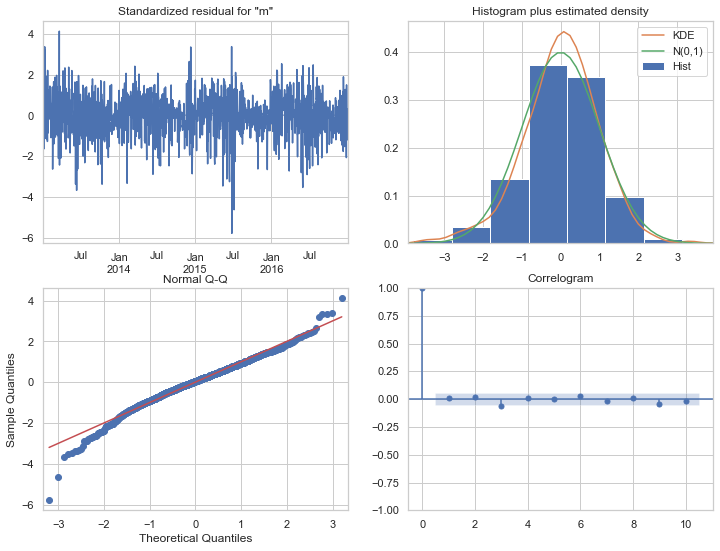

In [134]:
# Specify the SARIMAX model
sarima = SARIMAX(train_data['meantemp'],order=(1,1,1),seasonal_order=(1,0,1,12)).fit()

predicted_train=sarima.predict()

# Print SARIMAX model summary and diagnostics
print(sarima.summary())
sarima.plot_diagnostics(figsize=(12, 9))

residuals = sarima.resid
dw_statistic = durbin_watson(residuals)
print('Durbin-Watson statistic:', dw_statistic)

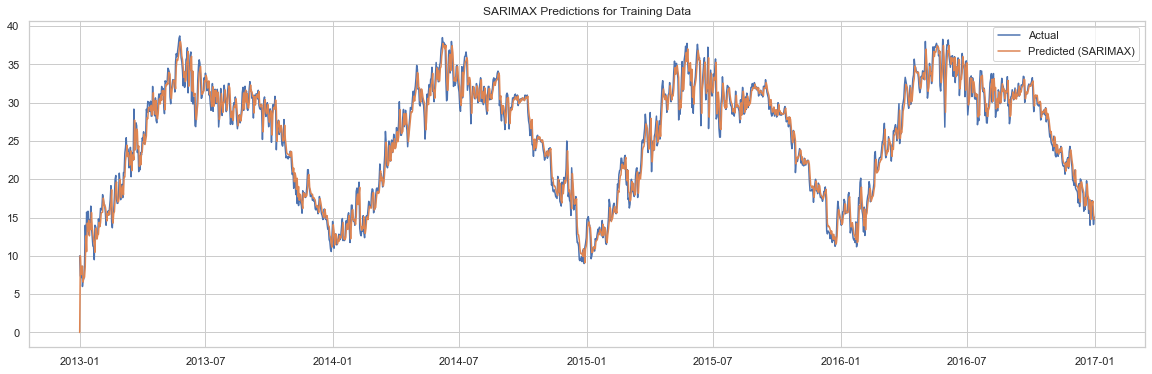

In [135]:
# Plot SARIMAX predictions for training data
plt.figure(figsize=(20, 6))
plt.plot(train_data['meantemp'], label='Actual')
plt.plot(predicted_train, label='Predicted (SARIMAX)')
plt.legend()
plt.title('SARIMAX Predictions for Training Data')
plt.show()

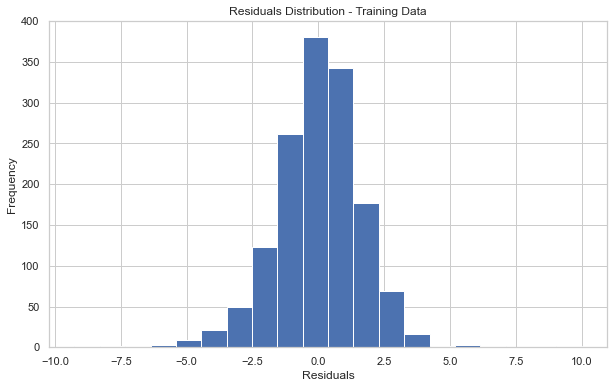

Mean Absolute Error (MAE) - Training Data: 0.013802121320671077
Mean Squared Error (MSE) - Training Data: 2.631192081902509


In [136]:
# Compute and visualize residuals for training data
residuals_train = train_data['meantemp'] - predicted_train
mae_train = abs(residuals_train.mean())
mse_train = (residuals_train ** 2).mean()
plt.figure(figsize=(10, 6))
plt.hist(residuals_train, bins=20)
plt.title('Residuals Distribution - Training Data')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()
print("Mean Absolute Error (MAE) - Training Data:", mae_train)
print("Mean Squared Error (MSE) - Training Data:", mse_train)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.95636D+00    |proj g|=  9.00891D-02

At iterate    5    f=  1.95034D+00    |proj g|=  8.17481D-03

At iterate   10    f=  1.94969D+00    |proj g|=  1.01082D-03

At iterate   15    f=  1.94967D+00    |proj g|=  2.69169D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     18      1     0     0   3.405D-06   1.950D+00
  F =   1.9496717297359536     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
        

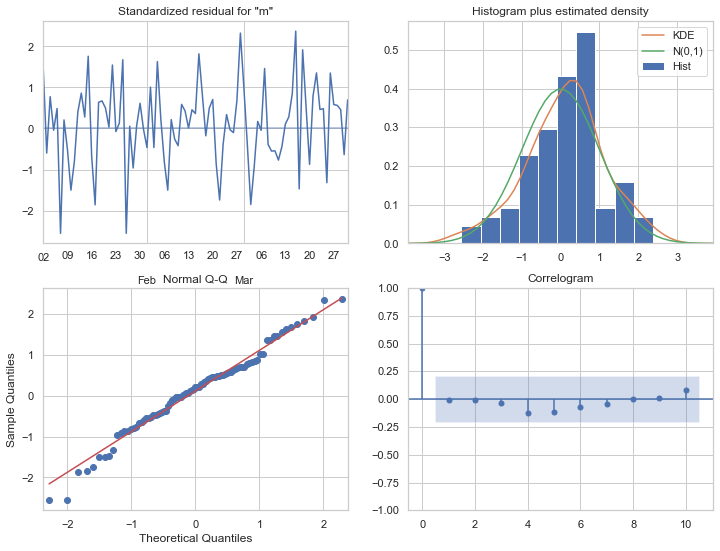

In [141]:
# Specify the SARIMAX model
sarima_test=SARIMAX(test_data['meantemp'],order=(1,1,1),seasonal_order=(1,0,1,12)).fit()
test_predictions=sarima_test.predict()


# Print SARIMAX model summary and diagnostics
print(sarima_test.summary())
sarima_test.plot_diagnostics(figsize=(12, 9))

residuals = sarima_test.resid
dw_statistic = durbin_watson(residuals)
print('Durbin-Watson statistic:', dw_statistic)

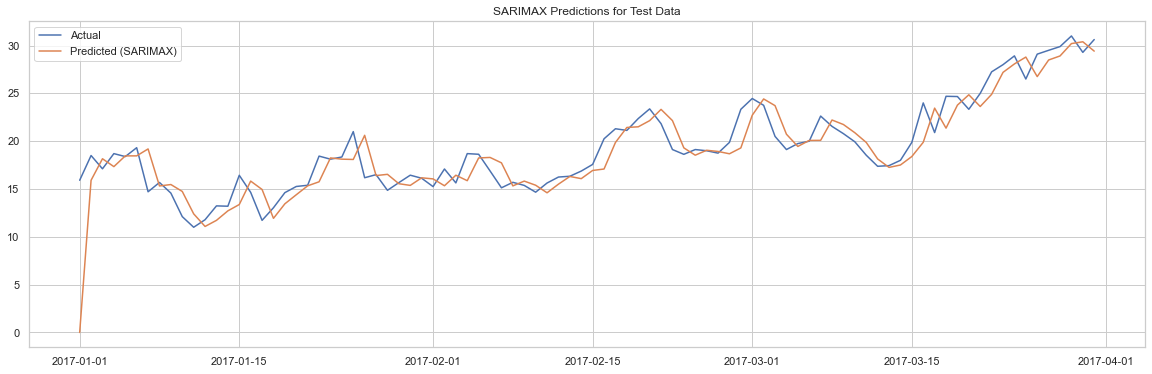

In [142]:
# Plot SARIMAX predictions for test data
plt.figure(figsize=(20, 6))
plt.plot(test_data['meantemp'], label='Actual')
plt.plot(test_predictions, label='Predicted (SARIMAX)')
plt.legend()
plt.title('SARIMAX Predictions for Test Data')
plt.show()

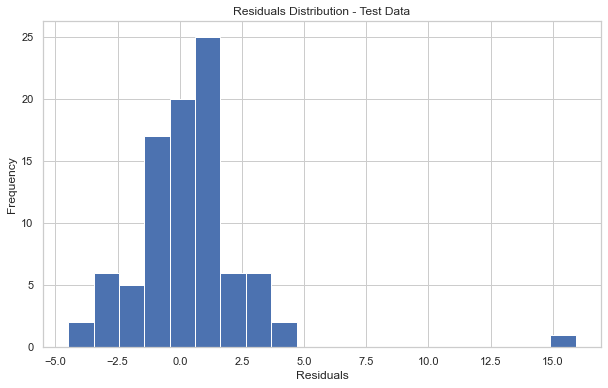

Mean Absolute Error (MAE) - Test Data: 0.3726180551051817
Mean Squared Error (MSE) - Test Data: 5.802237442014109


In [144]:
# Compute and visualize residuals for test data
residuals_test = test_data['meantemp'] - test_predictions
mae_test = abs(residuals_test.mean())
mse_test = (residuals_test ** 2).mean()
plt.figure(figsize=(10, 6))
plt.hist(residuals_test, bins=20)
plt.title('Residuals Distribution - Test Data')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()
print("Mean Absolute Error (MAE) - Test Data:", mae_test)
print("Mean Squared Error (MSE) - Test Data:", mse_test)

In [145]:
model.fit(test_data['meantemp'])
pred1 = model.predict(n_periods=12)

In [146]:
predictions = pd.concat([test_predictions,pred1])

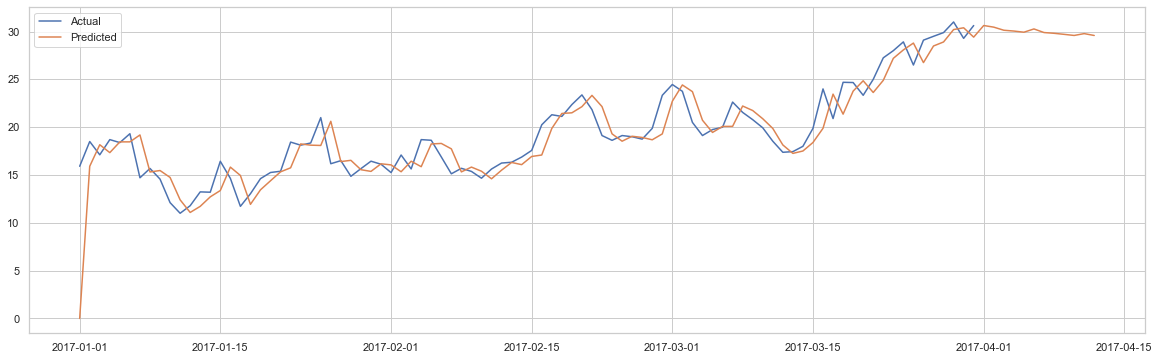

In [147]:
plt.figure(figsize=(20,6))
plt.plot(test_data['meantemp'],label='Actual')
plt.plot(predictions,label='Predicted')
plt.legend()

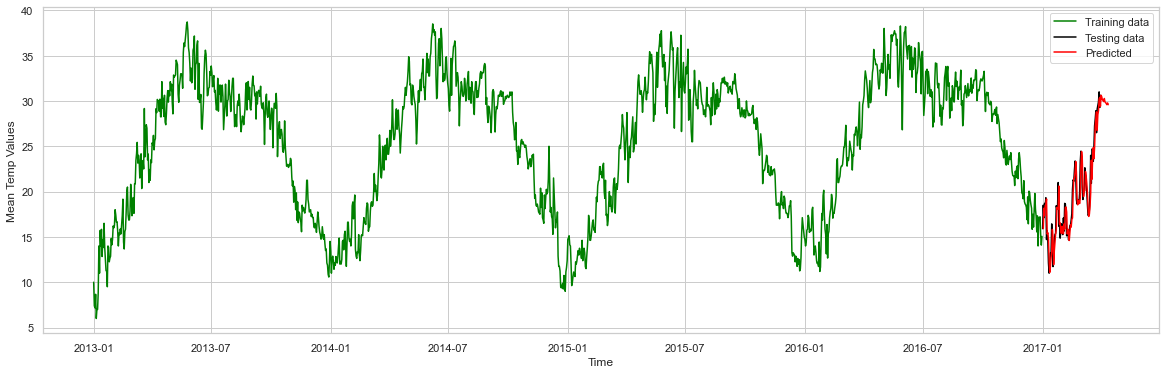

In [148]:
plt.figure(figsize=(20,6)) 
plt.plot(train_data['meantemp'], color='green',label='Training data')
plt.plot(test_data['meantemp'], color='black', label='Testing data')
plt.plot(predictions[1:], color='red', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Mean Temp Values')
plt.legend();

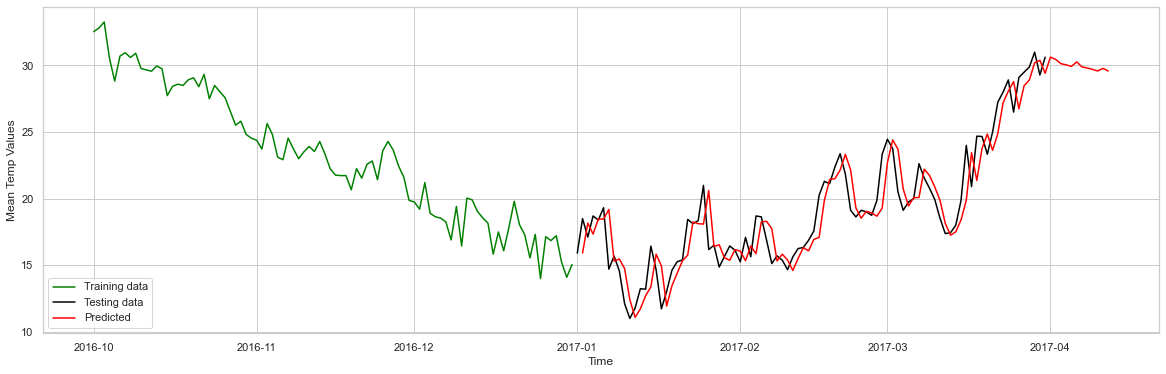

In [151]:
# Filter the data from July 1, 2016, and after
train_data_filtered = train_data['2016-10-01':]
test_data_filtered = test_data['2016-10-01':]
predictions_filtered = predictions['2016-10-01':]

# Plot the filtered data
plt.figure(figsize=(20,6)) 
plt.plot(train_data_filtered['meantemp'], color='green',label='Training data')
plt.plot(test_data_filtered['meantemp'], color='black', label='Testing data')
plt.plot(predictions_filtered[1:], color='red', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Mean Temp Values')
plt.legend()
plt.show()



In [154]:
# Manual grid search for (p,d,q) ARIMA parameters
#AICc = np.zeros((36,3))
#idx = 0
#d = 0
#for p in range(6):
#  for q in range(6):
#    mod = ARIMA(train_data['meantemp'], order=(p,d,q)).fit()
#    AICc[idx,0] = p
#    AICc[idx,1] = q
#    AICc[idx,2] = mod.aicc
#    idx += 1


#order_df = pd.DataFrame(AICc, columns=['p', 'q', 'AICc'])

# Best combination leading to the lowest AICc
#opt = order_df[order_df['AICc']==order_df['AICc'].min()]
#display(opt)
#p_opt = opt['p']
#q_opt = opt['q']

## SARIMA Model for average monthly temperatures 

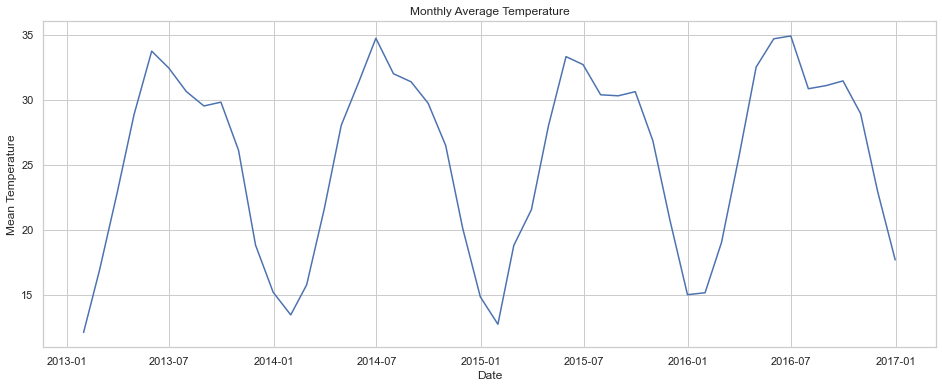

In [162]:
monthly_train_data = train_data['meantemp'].resample('M').mean()

fig = plt.figure(figsize=(16,6))
sns.lineplot(x=monthly_train_data.index, y=monthly_train_data)
plt.title('Monthly Average Temperature')
plt.xlabel('Date')
plt.ylabel('Mean Temperature')
plt.show()

In [163]:
def adfuller_test(monthly_train_data):
  adf_test = adfuller(monthly_train_data,autolag='AIC') 
  print('ADF Statistic:', adf_test[0])
  print('p-value: ', adf_test[1])
  print('Critical Values:')
  for key, value in adf_test[4].items():
      print('\t%s: %.3f' % (key, value))
  if adf_test[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> data is stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is non-stationary')


print('ADF on Mean Temperature')
adfuller_test(monthly_train_data)

ADF on Mean Temperature
ADF Statistic: 0.29190286702071727
p-value:  0.976969929763349
Critical Values:
	1%: -3.621
	5%: -2.944
	10%: -2.610
We cannot reject the null hypothesis (H0) --> data is non-stationary


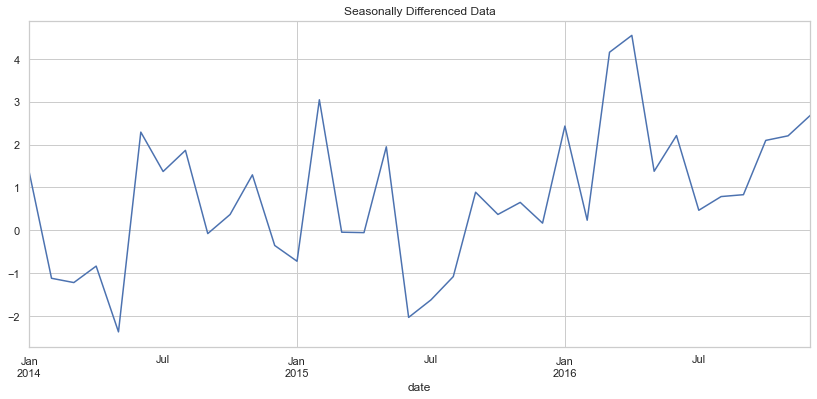

In [164]:
fig = plt.figure(figsize=(14,6))
seasonal_monthly_diff = monthly_train_data.diff(12).dropna()
seasonal_monthly_diff.plot()
plt.title('Seasonally Differenced Data')
plt.show()

In [165]:
adfuller_test(seasonal_monthly_diff)

ADF Statistic: -4.138617961048742
p-value:  0.0008355617849948105
Critical Values:
	1%: -3.633
	5%: -2.949
	10%: -2.613
We can reject the null hypothesis (H0) --> data is stationary


In [167]:
def kpss_test(monthly_train_data):
  kpss_out = kpss(monthly_train_data,regression='c', nlags='auto', store=True) 
  print('KPSS Statistic:', kpss_out[0])
  print('p-value: ', kpss_out[1])
  if kpss_out[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> data is not trend stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is trend stationary')


print('KPSS on Monthly Mean Temperature')
kpss_test(monthly_train_data)
print('--------------------------------------')
print('KPSS on Monthly Mean Temperature seasonal difference')
kpss_test(seasonal_monthly_diff)

KPSS on Monthly Mean Temperature
KPSS Statistic: 0.0674196025615499
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary
--------------------------------------
KPSS on Monthly Mean Temperature seasonal difference
KPSS Statistic: 0.4803959399389429
p-value:  0.046081995509247096
We can reject the null hypothesis (H0) --> data is not trend stationary


In [168]:
def kpss_test(monthly_train_data):
  kpss_out = kpss(monthly_train_data,regression='ct', nlags='auto', store=True) 
  print('KPSS Statistic:', kpss_out[0])
  print('p-value: ', kpss_out[1])
  if kpss_out[1] <= 0.05:
    print('We can reject the null hypothesis (H0) --> data is not trend stationary')
  else:
    print('We cannot reject the null hypothesis (H0) --> data is trend stationary')


print('KPSS on Monthly Mean Temperature')
kpss_test(monthly_train_data)
print('--------------------------------------')
print('KPSS on Monthly Mean Temperature seasonal difference')
kpss_test(seasonal_monthly_diff)

KPSS on Monthly Mean Temperature
KPSS Statistic: 0.03099149769334286
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary
--------------------------------------
KPSS on Monthly Mean Temperature seasonal difference
KPSS Statistic: 0.07786601574780658
p-value:  0.1
We cannot reject the null hypothesis (H0) --> data is trend stationary


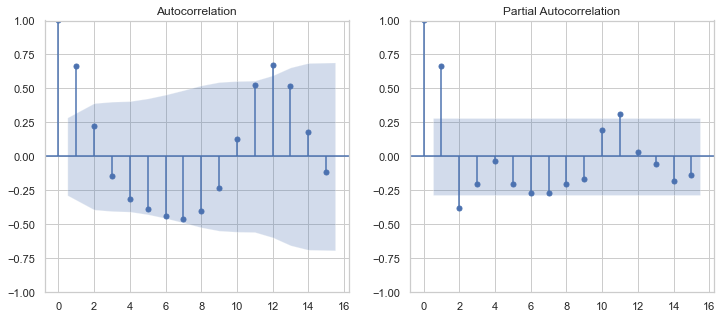

In [170]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(monthly_train_data.diff().dropna(), lags =15, ax=ax1)
plot_pacf(monthly_train_data.diff().dropna(), lags = 15, ax=ax2)
plt.show()

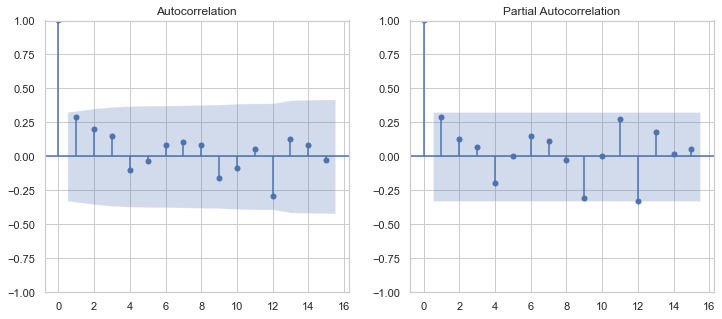

In [171]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_acf(seasonal_monthly_diff, lags=15, ax=ax1)
plot_pacf(seasonal_monthly_diff, lags=15, ax=ax2)
plt.show()

In [172]:
# Import itertools.product and SARIMAX algorithm
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Set parameter range
p = range(0,3)
q = range(0,3)
d = range(0,2)
s = [12]
# Find all parameter combos
pdq = list(product(p, d, q))
seasonal_pdq = list(product(p, d, q, s))
# Create SARIMA model for each order and seasonal order
aics = []
for order in pdq:
    for seasonal_order in seasonal_pdq:
        try:
            model = SARIMAX(seasonal_monthly_diff, order=order, seasonal_order=seasonal_order)
            results = model.fit()
            aics.append((order, seasonal_order, results.aic))
        except:
            print('SARIMA{},{} - Skipped'.format(order, seasonal_order))
# Check for smallest AIC
aics.sort(key=lambda x: x[2])
print(aics[0])

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.99959D+00    |proj g|=  3.13081D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   3.131D-06   2.000D+00
  F =   1.9995892138343387     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.0

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   10    f=  1.97367D+00    |proj g|=  2.58426D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     13      1     0     0   6.911D-07   1.974D+00
  F =   1.9736723907606557     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.01885D+00    |proj g|=  2.09529D-01

At iterate    5    f=  1.97367D+00    |proj g|=  5.31244D-05

           * * *

Tit   = total number of iterations
Tnf   = total num

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.61225D+00    |proj g|=  1.87564D-01

At iterate    5    f=  1.56408D+00    |proj g|=  2.22531D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   9.119D-06   1.564D+00
  F =   1.5640809545950101     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      1     0     0   4.285D-06   1.564D+00
  F =   1.5640809572390335     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.06357D+00    |proj g|=  1.91276D-01

At iterate    5    f=  1.97367D+00    |proj g|=  4.76758D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.01885D+00    |proj g|=  2.09529D-01

At iterate    5    f=  1.97367D+00    |proj g|=  4.10818D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      5      7      1     0     0   4.108D-06   1.974D+00
  F =   1.9736723904718625     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.56408D+00    |proj g|=  6.75103D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   7.348D-06   1.564D+00
  F =   1.5640809649825913     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.61225D+00    |proj g|=  1.87564D-01

At iterate    5    f=  1.56408D+00    |proj g|=  2.06812D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.61478D+00    |proj g|=  1.95067D-01

At iterate    5    f=  1.56408D+00    |proj g|=  5.24285D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      8      1     0     0   3.164D-06   1.564D+00
  F =   1.5640809590404618     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94049D+00    |proj g|=  7.16966D-02

At iterate    5    f=  1.93537D+00    |proj g|=  6.23486D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   6.235D-06   1.935D+00
  F =   1.9353655184499621     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  1.53834D+00    |proj g|=  8.84264D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     33     37      1     0     0   1.139D-05   1.538D+00
  F =   1.5383386268217989     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60635D+00    |proj g|=  1.65058D-01

At iterate    5    f=  1.53035D+00    |proj g|=  7.36053D-03


 This problem is unconstrained.



At iterate   10    f=  1.52991D+00    |proj g|=  1.86971D-04

At iterate   15    f=  1.52989D+00    |proj g|=  1.79940D-03

At iterate   20    f=  1.52986D+00    |proj g|=  1.26912D-03

At iterate   25    f=  1.52985D+00    |proj g|=  3.28834D-04

At iterate   30    f=  1.52985D+00    |proj g|=  2.87931D-04

At iterate   35    f=  1.52985D+00    |proj g|=  5.39664D-04

At iterate   40    f=  1.52984D+00    |proj g|=  1.35374D-04

At iterate   45    f=  1.52984D+00    |proj g|=  1.54384D-04

At iterate   50    f=  1.52984D+00    |proj g|=  1.25639D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     61   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94049D+00    |proj g|=  2.42607D-01

At iterate    5    f=  1.83239D+00    |proj g|=  1.20867D-02

At iterate   10    f=  1.83017D+00    |proj g|=  2.71399D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   7.323D-06   1.830D+00
  F =   1.8301658696288048     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10



 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.53003D+00    |proj g|=  1.14664D-03

At iterate   25    f=  1.53000D+00    |proj g|=  1.56693D-03

At iterate   30    f=  1.52999D+00    |proj g|=  5.09191D-04

At iterate   35    f=  1.52998D+00    |proj g|=  2.98888D-04

At iterate   40    f=  1.52998D+00    |proj g|=  2.62587D-04

At iterate   45    f=  1.52998D+00    |proj g|=  3.50374D-04

At iterate   50    f=  1.52998D+00    |proj g|=  1.37941D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     58      1     0     0   1.379D-04   1.530D+00
  F =   1.5299804769879228     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60635D+00    |proj g|=  1.65058D-01

At iterate    5    f=  1.53065D+00    |proj g|=  1.55071D-02

At iterate   10    f=  1.53030D+00    |proj g|=  3.20018D-03

At iterate   15    f=  1.53011D+00    |proj g|=  1.34264D-03

At iterate   20    f=  1.53005D+00    |proj g|=  1.16160D-03

At iterate   25    f=  1.53001D+00    |proj g|=  9.02494D-04

At iterate   30    f=  1.52997D+00    |proj g|=  3.76103D-03

At iterate   35    f=  1.52990D+00    |proj g|=  1.25791D-03

At iterate   40    f=  1.52987D+00    |proj g|=  1.25535D-03

At iterate   45    f=  1.52985D+00    |proj g|=  7.13286D-04

At iterate   50    f=  1.52984D+00    |proj g|=  8.44192D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92181D+00    |proj g|=  1.96563D-01

At iterate    5    f=  1.83014D+00    |proj g|=  1.30968D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8      9      1     0     0   1.744D-06   1.830D+00
  F =   1.8301377298820500     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 v

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94049D+00    |proj g|=  2.42607D-01

At iterate    5    f=  1.83005D+00    |proj g|=  1.30190D-03

At iterate   10    f=  1.82961D+00    |proj g|=  1.32949D-02

At iterate   15    f=  1.82912D+00    |proj g|=  8.01146D-03

At iterate   20    f=  1.82886D+00    |proj g|=  4.03170D-03

At iterate   25    f=  1.82876D+00    |proj g|=  2.64024D-03

At iterate   30    f=  1.82870D+00    |proj g|=  3.40927D-03

At iterate   35    f=  1.82865D+00    |proj g|=  2.05773D-03

At iterate   40    f=  1.82859D+00    |proj g|=  3.67573D-03

At iterate   45    f=  1.82856D+00    |proj g|=  2.08438D-03

At iterate   50    f=  1.82855D+00    |proj g|=  2.61068D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   10    f=  1.53042D+00    |proj g|=  9.98151D-03

At iterate   15    f=  1.52977D+00    |proj g|=  4.67831D-03

At iterate   20    f=  1.52948D+00    |proj g|=  2.03296D-03

At iterate   25    f=  1.52942D+00    |proj g|=  2.49535D-03

At iterate   30    f=  1.52939D+00    |proj g|=  2.55832D-03

At iterate   35    f=  1.52938D+00    |proj g|=  2.01493D-03

At iterate   40    f=  1.52936D+00    |proj g|=  7.70617D-04

At iterate   45    f=  1.52935D+00    |proj g|=  4.06345D-04

At iterate   50    f=  1.52934D+00    |proj g|=  1.64995D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     63   

 This problem is unconstrained.



At iterate    5    f=  1.53065D+00    |proj g|=  5.40843D-03

At iterate   10    f=  1.53040D+00    |proj g|=  6.54612D-03

At iterate   15    f=  1.52994D+00    |proj g|=  4.68481D-03

At iterate   20    f=  1.52958D+00    |proj g|=  2.11431D-03

At iterate   25    f=  1.52948D+00    |proj g|=  6.87116D-03

At iterate   30    f=  1.52942D+00    |proj g|=  3.18774D-03

At iterate   35    f=  1.52939D+00    |proj g|=  3.00037D-03

At iterate   40    f=  1.52936D+00    |proj g|=  2.21313D-03

At iterate   45    f=  1.52935D+00    |proj g|=  3.56474D-03

At iterate   50    f=  1.52934D+00    |proj g|=  3.87515D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.53068D+00    |proj g|=  8.44605D-03

At iterate   10    f=  1.53030D+00    |proj g|=  6.44205D-03

At iterate   15    f=  1.52980D+00    |proj g|=  3.24062D-03

At iterate   20    f=  1.52959D+00    |proj g|=  3.95085D-03

At iterate   25    f=  1.52949D+00    |proj g|=  1.09577D-03

At iterate   30    f=  1.52944D+00    |proj g|=  3.04936D-03

At iterate   35    f=  1.52940D+00    |proj g|=  2.15183D-03

At iterate   40    f=  1.52939D+00    |proj g|=  3.96191D-03

At iterate   45    f=  1.52937D+00    |proj g|=  3.13971D-03

At iterate   50    f=  1.52936D+00    |proj g|=  2.51398D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92797D+00    |proj g|=  1.44376D-01

At iterate    5    f=  1.91448D+00    |proj g|=  4.18103D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   2.220D-05   1.914D+00
  F =   1.9144820284262256     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.61480D+00    |proj g|=  2.44722D-01

At iterate    5    f=  1.53758D+00    |proj g|=  3.11739D-02

At iterate   10    f=  1.53384D+00    |proj g|=  2.96119D-03

At iterate   15    f=  1.53334D+00    |proj g|=  1.75183D-03

At iterate   20    f=  1.53323D+00    |proj g|=  8.78580D-04

At iterate   25    f=  1.53322D+00    |proj g|=  1.02894D-03

At iterate   30    f=  1.53322D+00    |proj g|=  2.79575D-04

At iterate   35    f=  1.53322D+00    |proj g|=  5.62207D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate   10    f=  1.52053D+00    |proj g|=  2.70653D-03

At iterate   15    f=  1.52032D+00    |proj g|=  1.17181D-03

At iterate   20    f=  1.52028D+00    |proj g|=  1.95131D-03

At iterate   25    f=  1.52022D+00    |proj g|=  6.67407D-04

At iterate   30    f=  1.52022D+00    |proj g|=  1.01242D-04

At iterate   35    f=  1.52022D+00    |proj g|=  4.15296D-04

At iterate   40    f=  1.52022D+00    |proj g|=  1.15391D-04

At iterate   45    f=  1.52022D+00    |proj g|=  5.74950D-05

At iterate   50    f=  1.52022D+00    |proj g|=  9.30792D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     55   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.77825D+00    |proj g|=  1.39947D-02

At iterate   10    f=  1.77608D+00    |proj g|=  2.56602D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     17      1     0     0   9.780D-06   1.776D+00
  F =   1.7760762905037750     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92797D+00    |proj g|=  3.53009D-01

At iterate    5    f=  1.77471D+00    |proj g|=  1.54335D-02


 This problem is unconstrained.



At iterate   10    f=  1.77310D+00    |proj g|=  9.08661D-03

At iterate   15    f=  1.77086D+00    |proj g|=  3.33386D-03

At iterate   20    f=  1.77058D+00    |proj g|=  1.15012D-02

At iterate   25    f=  1.77049D+00    |proj g|=  2.88123D-03

At iterate   30    f=  1.77046D+00    |proj g|=  8.02958D-04

At iterate   35    f=  1.77045D+00    |proj g|=  1.05012D-03

At iterate   40    f=  1.77045D+00    |proj g|=  3.29201D-04

At iterate   45    f=  1.77045D+00    |proj g|=  9.71341D-04

At iterate   50    f=  1.77045D+00    |proj g|=  1.08887D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     56   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.52155D+00    |proj g|=  2.61493D-02

At iterate   10    f=  1.52006D+00    |proj g|=  6.66410D-05

At iterate   15    f=  1.52006D+00    |proj g|=  4.18562D-04

At iterate   20    f=  1.52006D+00    |proj g|=  6.28936D-04

At iterate   25    f=  1.52006D+00    |proj g|=  1.35880D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     30      1     0     0   4.770D-05   1.520D+00
  F =   1.5200588623928768     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   10    f=  1.52007D+00    |proj g|=  1.17859D-04

At iterate   15    f=  1.52006D+00    |proj g|=  1.71119D-03

At iterate   20    f=  1.52006D+00    |proj g|=  1.89581D-04

At iterate   25    f=  1.52006D+00    |proj g|=  2.28460D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     30      1     0     0   2.285D-05   1.520D+00
  F =   1.5200588544590259     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  1.77575D+00    |proj g|=  6.11801D-03

At iterate   10    f=  1.77567D+00    |proj g|=  3.11375D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     14      1     0     0   8.077D-06   1.776D+00
  F =   1.7756729159144866     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92797D+00    |proj g|=  3.53009D-01


 This problem is unconstrained.



At iterate    5    f=  1.77653D+00    |proj g|=  5.80691D-03

At iterate   10    f=  1.77649D+00    |proj g|=  1.93238D-03

At iterate   15    f=  1.77427D+00    |proj g|=  4.94296D-03

At iterate   20    f=  1.77390D+00    |proj g|=  3.93494D-03

At iterate   25    f=  1.77354D+00    |proj g|=  4.95894D-03

At iterate   30    f=  1.77342D+00    |proj g|=  1.88811D-03

At iterate   35    f=  1.77326D+00    |proj g|=  4.02265D-04

At iterate   40    f=  1.77324D+00    |proj g|=  1.47396D-03

At iterate   45    f=  1.77322D+00    |proj g|=  1.38307D-03

At iterate   50    f=  1.77322D+00    |proj g|=  5.94673D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f=  1.77001D+00    |proj g|=  9.23507D-03

At iterate   20    f=  1.76929D+00    |proj g|=  1.74167D-02

At iterate   25    f=  1.76858D+00    |proj g|=  8.03940D-03

At iterate   30    f=  1.76837D+00    |proj g|=  6.89993D-03

At iterate   35    f=  1.76831D+00    |proj g|=  6.37180D-03

At iterate   40    f=  1.76830D+00    |proj g|=  1.72904D-03

At iterate   45    f=  1.76829D+00    |proj g|=  9.75052D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     46     64      1     0     0   9.751D-05   1.768D+00
  F =   1.7682942049837764     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  1.52247D+00    |proj g|=  4.42468D-02

At iterate   10    f=  1.52014D+00    |proj g|=  5.33558D-04

At iterate   15    f=  1.52011D+00    |proj g|=  3.36244D-03

At iterate   20    f=  1.52006D+00    |proj g|=  1.31133D-03

At iterate   25    f=  1.52006D+00    |proj g|=  1.31498D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     29      1     0     0   1.037D-05   1.520D+00
  F =   1.5200588510992010     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.61480D+00    |proj g|=  2.44722D-01

At iterate    5    f=  1.52159D+00    |proj g|=  3.31413D-02

At iterate   10    f=  1.52011D+00    |proj g|=  3.92842D-04

At iterate   15    f=  1.52008D+00    |proj g|=  2.30667D-03

At iterate   20    f=  1.52006D+00    |proj g|=  2.05894D-04

At iterate   25    f=  1.52006D+00    |proj g|=  6.61491D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     29      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  1.52088D+00    |proj g|=  1.54316D-02

At iterate   10    f=  1.52010D+00    |proj g|=  3.87306D-04

At iterate   15    f=  1.52007D+00    |proj g|=  1.28947D-03

At iterate   20    f=  1.52006D+00    |proj g|=  2.72723D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     27      1     0     0   6.931D-06   1.520D+00
  F =   1.5200588540437190     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.01393D+00    |proj g|=  5.26268D-01

At iterate    5    f=  1.73099D+00    |proj g|=  2.10737D-02

At iterate   10    f=  1.72859D+00    |proj g|=  1.68098D-03

At iterate   15    f=  1.72839D+00    |proj g|=  6.24449D-04

At iterate   20    f=  1.72838D+00    |proj g|=  2.55919D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     31      1     0     0   6.905D-06   1.728D+00
  F =   1.7283797872711597     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.73796D+00    |proj g|=  2.90816D-01

At iterate    5    f=  1.56391D+00    |proj g|=  1.91863D-02

At iterate   10    f=  1.55894D+00    |proj g|=  3.08246D-03

At iterate   15    f=  1.55833D+00    |proj g|=  2.33965D-03

At iterate   20    f=  1.55823D+00    |proj g|=  5.48757D-04

At iterate   25    f=  1.55822D+00    |proj g|=  5.13054D-04

At iterate   30    f=  1.55822D+00    |proj g|=  4.58462D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.75543D+00    |proj g|=  7.29350D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      8      1     0     0   7.293D-07   1.755D+00
  F =   1.7554321526462353     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.01335D+00    |proj g|=  5.12044D-01

At iterate    5    f=  1.73242D+00    |proj g|=  1.99339D-02

At iterate   10    f=  1.72985D+00    |proj g|=  1.04994D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6      8      1     0     0   1.991D-06   1.537D+00
  F =   1.5368492675463175     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.73707D+00    |proj g|=  2.79183D-01

At iterate    5    f=  1.56985D+00    |proj g|=  1.22228D-01

At iterate   10    f=  1.53685D+00    |proj g|=  1.03083D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.55872D+00    |proj g|=  1.33409D-01

At iterate   10    f=  1.53685D+00    |proj g|=  7.83338D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   7.833D-06   1.537D+00
  F =   1.5368491665297865     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74539D+00    |proj g|=  2.19666D-01

At iterate    5    f=  1.72839D+00    |proj g|=  2.02644D-03


 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     11      1     0     0   5.383D-07   1.728D+00
  F =   1.7283797862874859     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.01335D+00    |proj g|=  5.12044D-01

At iterate    5    f=  1.73286D+00    |proj g|=  2.71959D-02

At iterate   10    f=  1.72838D+00    |proj g|=  3.82148D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.73494D+00    |proj g|=  4.42716D-02

At iterate   10    f=  1.72838D+00    |proj g|=  4.54667D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     13      1     0     0   4.547D-06   1.728D+00
  F =   1.7283797863313937     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.73674D+00    |proj g|=  2.67548D-01

At iterate    5    f=  1.54142D+00    |proj g|=  3.57619D-02

At iter

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     14      1     0     0   1.605D-06   1.537D+00
  F =   1.5368493379041175     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.73796D+00    |proj g|=  2.90816D-01

At iterate    5    f=  1.54611D+00    |proj g|=  1.03573D-01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   1.244D-05   1.537D+00
  F =   1.5368493532070171     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.85824D+00    |proj g|=  5.77295D-02

At iterate    5    f=  1.84365D+00    |proj g|=  4.69194D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  1.70506D+00    |proj g|=  1.21722D-04

At iterate   35    f=  1.70506D+00    |proj g|=  1.63624D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     38     65      1     0     0   2.407D-04   1.705D+00
  F =   1.7050565821845245     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.85824D+00    |proj g|=  3.21407D-01

At iterate    5    f=  1.70276D+00    |proj g|=  4.03860D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  1.69135D+00    |proj g|=  1.96943D-02

At iterate   20    f=  1.69106D+00    |proj g|=  2.08789D-03

At iterate   25    f=  1.69101D+00    |proj g|=  5.80521D-04

At iterate   30    f=  1.69100D+00    |proj g|=  9.44337D-04

At iterate   35    f=  1.69100D+00    |proj g|=  1.09695D-04

At iterate   40    f=  1.69099D+00    |proj g|=  4.38670D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     41     50      1     0     0   1.105D-04   1.691D+00
  F =   1.6909949042725299     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     35      1     0     0   1.173D-06   1.486D+00
  F =   1.4860345238550998     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56243D+00    |proj g|=  1.68552D-01

At iterate    5    f=  1.48073D+00    |proj g|=  4.89776D-03


 This problem is unconstrained.



At iterate   10    f=  1.47983D+00    |proj g|=  6.27511D-04

At iterate   15    f=  1.47969D+00    |proj g|=  5.55647D-04

At iterate   20    f=  1.47968D+00    |proj g|=  1.34430D-04

At iterate   25    f=  1.47968D+00    |proj g|=  3.58818D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     39      1     0     0   1.743D-04   1.480D+00
  F =   1.4796832102117992     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.83997D+00    |proj g|=  2.33463D-01

At iterate    5    f=  1.73583D+00    |proj g|=  1.41115D-02

At iterate   10    f=  1.73476D+00    |proj g|=  4.80427D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     13      1     0     0   4.804D-06   1.735D+00
  F =   1.7347580370846700     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.69976D+00    |proj g|=  7.44112D-03

At iterate   15    f=  1.69214D+00    |proj g|=  2.13157D-02

At iterate   20    f=  1.68967D+00    |proj g|=  1.17456D-02

At iterate   25    f=  1.68934D+00    |proj g|=  2.22453D-03

At iterate   30    f=  1.68931D+00    |proj g|=  4.84356D-04

At iterate   35    f=  1.68931D+00    |proj g|=  1.41233D-03

At iterate   40    f=  1.68918D+00    |proj g|=  4.02958D-03

At iterate   45    f=  1.68918D+00    |proj g|=  4.93214D-04

At iterate   50    f=  1.68917D+00    |proj g|=  1.67379D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     58   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60729D+00    |proj g|=  1.30702D-01

At iterate    5    f=  1.48021D+00    |proj g|=  2.94448D-03

At iterate   10    f=  1.47971D+00    |proj g|=  5.63058D-04

At iterate   15    f=  1.47969D+00    |proj g|=  2.64523D-04

At iterate   20    f=  1.47968D+00    |proj g|=  1.50534D-04

At iterate   25    f=  1.47968D+00    |proj g|=  3.10188D-05


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     40      1     0     0   3.122D-05   1.480D+00
  F =   1.4796835605874852     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56243D+00    |proj g|=  1.68552D-01

At iterate    5    f=  1.48088D+00    |proj g|=  3.83292D-03

At iterate   10    f=  1.47985D+00    |proj g|=  2.30206D-03

At iterate   15    f=  1.47969D+00    |proj g|=  4.64788D-04

At iter

 This problem is unconstrained.



At iterate    5    f=  1.48098D+00    |proj g|=  4.14398D-03

At iterate   10    f=  1.47982D+00    |proj g|=  9.80096D-04

At iterate   15    f=  1.47970D+00    |proj g|=  4.67597D-04

At iterate   20    f=  1.47969D+00    |proj g|=  1.74216D-04

At iterate   25    f=  1.47968D+00    |proj g|=  1.11437D-04

At iterate   30    f=  1.47968D+00    |proj g|=  4.90883D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     36      1     0     0   4.909D-06   1.480D+00
  F =   1.4796836421654118     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.80910D+00    |proj g|=  2.90047D-01

At iterate    5    f=  1.68661D+00    |proj g|=  3.28272D-03

At iterate   10    f=  1.68650D+00    |proj g|=  1.69991D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     15      1     0     0   1.928D-06   1.686D+00
  F =   1.6864983025847768     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   10    f=  1.68650D+00    |proj g|=  1.75402D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     11     13      1     0     0   2.068D-06   1.686D+00
  F =   1.6864983040252943     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56243D+00    |proj g|=  1.68549D-01

At iterate    5    f=  1.48087D+00    |proj g|=  3.80173D-03


 This problem is unconstrained.



At iterate   10    f=  1.47986D+00    |proj g|=  1.29708D-03

At iterate   15    f=  1.47970D+00    |proj g|=  3.81454D-04

At iterate   20    f=  1.47969D+00    |proj g|=  2.64129D-04

At iterate   25    f=  1.47968D+00    |proj g|=  5.12050D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     37      1     0     0   3.139D-05   1.480D+00
  F =   1.4796836323053713     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56243D+00    |proj g|=  1.68552D-01

At iterate    5    f=  1.48093D+00    |proj g|=  4.00487D-03

At iterate   10    f=  1.47979D+00    |proj g|=  2.11674D-03

At iterate   15    f=  1.47970D+00    |proj g|=  9.95804D-04

At iterate   20    f=  1.47969D+00    |proj g|=  2.28697D-04

At iterate   25    f=  1.47968D+00    |proj g|=  9.56878D-05

At iterate   30    f=  1.47968D+00    |proj g|=  3.49092D-05

At iterate   35    f=  1.47968D+00    |proj g|=  1.90843D-04

At iterate   40    f=  1.47968D+00    |proj g|=  1.04463D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56243D+00    |proj g|=  1.68552D-01

At iterate    5    f=  1.48111D+00    |proj g|=  8.98556D-03

At iterate   10    f=  1.48000D+00    |proj g|=  1.01652D-03

At iterate   15    f=  1.47970D+00    |proj g|=  3.89706D-04

At iterate   20    f=  1.47969D+00    |proj g|=  3.06152D-04

At iterate   25    f=  1.47968D+00    |proj g|=  1.22450D-04

At iterate   30    f=  1.47968D+00    |proj g|=  2.64249D-05
  ys=-1.772E-08  -gs= 3.311E-08 BFGS update SKIPPED

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.68048D+00    |proj g|=  8.41754D-04

At iterate   25    f=  1.68047D+00    |proj g|=  4.16653D-04

At iterate   30    f=  1.68047D+00    |proj g|=  1.10668D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     49      1     0     0   6.836D-05   1.680D+00
  F =   1.6804702918087016     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.84979D+00    |proj g|=  3.59949D-01


 This problem is unconstrained.



At iterate    5    f=  1.66392D+00    |proj g|=  8.36343D-03

At iterate   10    f=  1.66344D+00    |proj g|=  4.36131D-03

At iterate   15    f=  1.66286D+00    |proj g|=  1.02306D-02

At iterate   20    f=  1.66274D+00    |proj g|=  1.74291D-03

At iterate   25    f=  1.66271D+00    |proj g|=  1.42331D-03

At iterate   30    f=  1.66270D+00    |proj g|=  8.65571D-04

At iterate   35    f=  1.66270D+00    |proj g|=  2.76649D-04

At iterate   40    f=  1.66270D+00    |proj g|=  2.62426D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     53      1     0     0   2.624D-05   1.663D+00
  F =   1.66270037499

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.47896D+00    |proj g|=  5.43914D-03

At iterate   15    f=  1.47828D+00    |proj g|=  1.23224D-03

At iterate   20    f=  1.47821D+00    |proj g|=  1.07880D-03

At iterate   25    f=  1.47820D+00    |proj g|=  1.51081D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     32      1     0     0   4.159D-06   1.478D+00
  F =   1.4782006146871489     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  1.45835D+00    |proj g|=  2.34350D-03

At iterate   15    f=  1.45739D+00    |proj g|=  4.48890D-03

At iterate   20    f=  1.45686D+00    |proj g|=  2.73489D-03

At iterate   25    f=  1.45678D+00    |proj g|=  5.72610D-04

At iterate   30    f=  1.45677D+00    |proj g|=  2.17410D-04

At iterate   35    f=  1.45676D+00    |proj g|=  4.74048D-04

At iterate   40    f=  1.45676D+00    |proj g|=  2.29315D-05

At iterate   45    f=  1.45676D+00    |proj g|=  1.28172D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     60      1     0     0   1.254D-05   1.457D+00
  F =   1.45676370249

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  1.66539D+00    |proj g|=  1.53232D-03

At iterate   30    f=  1.66538D+00    |proj g|=  7.75211D-04

At iterate   35    f=  1.66537D+00    |proj g|=  7.17398D-04

At iterate   40    f=  1.66537D+00    |proj g|=  2.15589D-04
  ys=-1.262E-07  -gs= 1.787E-07 BFGS update SKIPPED

At iterate   45    f=  1.66537D+00    |proj g|=  2.96252D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47     77      2     1     0   1.641D-05   1.665D+00
  F =   1.6653737761276846     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.84979D+00    |proj g|=  3.59949D-01

At iterate    5    f=  1.67100D+00    |proj g|=  1.16069D-02

At iterate   10    f=  1.66789D+00    |proj g|=  1.95101D-02

At iterate   15    f=  1.66262D+00    |proj g|=  1.11560D-02

At iterate   20    f=  1.66192D+00    |proj g|=  1.41311D-03

At iterate   25    f=  1.66173D+00    |proj g|=  2.89844D-03

At iterate   30    f=  1.66163D+00    |proj g|=  4.06616D-03

At iterate   35    f=  1.66155D+00    |proj g|=  1.60491D-03

At iterate   40    f=  1.66155D+00    |proj g|=  2.04255D-04

At iterate   45    f=  1.66155D+00    |proj g|=  1.23688D-03

At iterate   50    f=  1.66154D+00    |proj g|=  1.72528D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     40      1     0     0   3.196D-05   1.457D+00
  F =   1.4574271989191949     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57578D+00    |proj g|=  2.30333D-01

At iterate    5    f=  1.46408D+00    |proj g|=  6.32510D-02

At iterate   10    f=  1.45839D+00    |proj g|=  9.58943D-03

At iterate   15    f=  1.45614D+00    |proj g|=  2.82084D-03

At iter

 This problem is unconstrained.



At iterate   25    f=  1.45560D+00    |proj g|=  1.84607D-03

At iterate   30    f=  1.45558D+00    |proj g|=  9.44293D-04

At iterate   35    f=  1.45557D+00    |proj g|=  4.19122D-04

At iterate   40    f=  1.45557D+00    |proj g|=  1.47451D-04

At iterate   45    f=  1.45557D+00    |proj g|=  3.78291D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     48     57      1     0     0   5.921D-06   1.456D+00
  F =   1.4555722124260828     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   15    f=  1.45550D+00    |proj g|=  1.67549D-03

At iterate   20    f=  1.45515D+00    |proj g|=  3.18312D-03

At iterate   25    f=  1.45503D+00    |proj g|=  2.11691D-03

At iterate   30    f=  1.45497D+00    |proj g|=  2.21557D-03

At iterate   35    f=  1.45495D+00    |proj g|=  3.52765D-03

At iterate   40    f=  1.45493D+00    |proj g|=  1.31890D-03

At iterate   45    f=  1.45492D+00    |proj g|=  5.43674D-04

At iterate   50    f=  1.45491D+00    |proj g|=  1.68792D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     57      1     0     0   1.688D-03   1.455D+00
  F =   1.45491395774

 This problem is unconstrained.



At iterate   10    f=  1.66045D+00    |proj g|=  1.88510D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   3.820D-06   1.660D+00
  F =   1.6604399492247579     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.84979D+00    |proj g|=  3.59949D-01

At iterate    5    f=  1.66439D+00    |proj g|=  2.99149D-02


 This problem is unconstrained.



At iterate   10    f=  1.66061D+00    |proj g|=  4.91135D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     16      1     0     0   2.025D-05   1.661D+00
  F =   1.6605483531204468     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.84979D+00    |proj g|=  3.59949D-01

At iterate    5    f=  1.66680D+00    |proj g|=  4.23729D-02


 This problem is unconstrained.



At iterate   10    f=  1.66076D+00    |proj g|=  4.67373D-03

At iterate   15    f=  1.66055D+00    |proj g|=  4.11429D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     15     18      1     0     0   4.114D-05   1.661D+00
  F =   1.6605481800726742     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57578D+00    |proj g|=  2.30330D-01


 This problem is unconstrained.



At iterate    5    f=  1.46157D+00    |proj g|=  2.47006D-02

At iterate   10    f=  1.45800D+00    |proj g|=  1.69638D-02

At iterate   15    f=  1.45405D+00    |proj g|=  5.59443D-03

At iterate   20    f=  1.45361D+00    |proj g|=  9.46197D-03

At iterate   25    f=  1.45342D+00    |proj g|=  3.05273D-03

At iterate   30    f=  1.45332D+00    |proj g|=  8.92275D-03

At iterate   35    f=  1.45323D+00    |proj g|=  6.58268D-03

At iterate   40    f=  1.45317D+00    |proj g|=  7.24434D-03

At iterate   45    f=  1.45314D+00    |proj g|=  5.34198D-03

At iterate   50    f=  1.45311D+00    |proj g|=  5.32859D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  1.45881D+00    |proj g|=  1.23795D-02

At iterate   15    f=  1.45496D+00    |proj g|=  1.32639D-02

At iterate   20    f=  1.45400D+00    |proj g|=  1.12592D-02

At iterate   25    f=  1.45363D+00    |proj g|=  8.20064D-03

At iterate   30    f=  1.45341D+00    |proj g|=  6.90345D-03

At iterate   35    f=  1.45331D+00    |proj g|=  2.83418D-03

At iterate   40    f=  1.45324D+00    |proj g|=  1.49054D-02

At iterate   45    f=  1.45319D+00    |proj g|=  3.12420D-03

At iterate   50    f=  1.45315D+00    |proj g|=  1.60690D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     65   

 This problem is unconstrained.



At iterate    5    f=  1.46335D+00    |proj g|=  3.42673D-02

At iterate   10    f=  1.45950D+00    |proj g|=  2.47771D-02

At iterate   15    f=  1.45489D+00    |proj g|=  8.63616D-03

At iterate   20    f=  1.45401D+00    |proj g|=  1.09048D-02

At iterate   25    f=  1.45365D+00    |proj g|=  3.08893D-03

At iterate   30    f=  1.45342D+00    |proj g|=  1.15736D-03

At iterate   35    f=  1.45332D+00    |proj g|=  3.06878D-03

At iterate   40    f=  1.45326D+00    |proj g|=  7.28081D-03

At iterate   45    f=  1.45320D+00    |proj g|=  1.70115D-02

At iterate   50    f=  1.45315D+00    |proj g|=  1.05282D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.72071D+00    |proj g|=  2.12545D-02

At iterate   15    f=  1.71712D+00    |proj g|=  2.79562D-02

At iterate   20    f=  1.71655D+00    |proj g|=  1.35336D-03

At iterate   25    f=  1.71644D+00    |proj g|=  1.48708D-03

At iterate   30    f=  1.71643D+00    |proj g|=  2.79091D-03

At iterate   35    f=  1.71642D+00    |proj g|=  6.97269D-04

At iterate   40    f=  1.71642D+00    |proj g|=  3.93973D-04

At iterate   45    f=  1.71642D+00    |proj g|=  4.52181D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     49     57      1     0     0   8.511D-05   1.716D+00
  F =   1.71641766994

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  1.53181D+00    |proj g|=  2.47275D-04

At iterate   30    f=  1.53181D+00    |proj g|=  1.38738D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32     59      2     0     0   2.007D-05   1.532D+00
  F =   1.5318073543861035     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60551D+00    |proj g|=  1.76579D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate    5    f=  1.51749D+00    |proj g|=  1.78365D-02

At iterate   10    f=  1.51539D+00    |proj g|=  3.43370D-03

At iterate   15    f=  1.51513D+00    |proj g|=  1.44422D-03

At iterate   20    f=  1.51508D+00    |proj g|=  1.63064D-03

At iterate   25    f=  1.51506D+00    |proj g|=  1.23012D-04

At iterate   30    f=  1.51506D+00    |proj g|=  7.35894D-04

At iterate   35    f=  1.51506D+00    |proj g|=  1.31701D-04

At iterate   40    f=  1.51505D+00    |proj g|=  4.77751D-05

At iterate   45    f=  1.51505D+00    |proj g|=  9.34763D-05

At iterate   50    f=  1.51505D+00    |proj g|=  9.71087D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90692D+00    |proj g|=  3.57398D-01

At iterate    5    f=  1.72248D+00    |proj g|=  4.11909D-02

At iterate   10    f=  1.71940D+00    |proj g|=  1.37146D-02

At iterate   15    f=  1.71685D+00    |proj g|=  3.80327D-03

At iterate   20    f=  1.71627D+00    |proj g|=  2.03444D-03

At iterate   25    f=  1.71613D+00    |proj g|=  2.01820D-03

At iterate   30    f=  1.71610D+00    |proj g|=  7.61218D-04

At iterate   35    f=  1.71610D+00    |proj g|=  8.34360D-04

At iterate   40    f=  1.71609D+00    |proj g|=  6.27249D-04

At iterate   45    f=  1.71609D+00    |proj g|=  5.56644D-04

At iterate   50    f=  1.71609D+00    |proj g|=  5.69753D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.51379D+00    |proj g|=  1.16889D-02

At iterate   10    f=  1.51341D+00    |proj g|=  3.86628D-03

At iterate   15    f=  1.51259D+00    |proj g|=  2.41676D-03

At iterate   20    f=  1.51225D+00    |proj g|=  4.95529D-03

At iterate   25    f=  1.51205D+00    |proj g|=  2.78359D-03

At iterate   30    f=  1.51200D+00    |proj g|=  1.62182D-03

At iterate   35    f=  1.51196D+00    |proj g|=  3.74176D-04

At iterate   40    f=  1.51195D+00    |proj g|=  1.62179D-03

At iterate   45    f=  1.51194D+00    |proj g|=  3.36039D-04

At iterate   50    f=  1.51193D+00    |proj g|=  5.30710D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.51372D+00    |proj g|=  9.26400D-03

At iterate   10    f=  1.51311D+00    |proj g|=  7.21518D-03

At iterate   15    f=  1.51218D+00    |proj g|=  4.14233D-03

At iterate   20    f=  1.51195D+00    |proj g|=  1.68740D-03

At iterate   25    f=  1.51191D+00    |proj g|=  6.20735D-04

At iterate   30    f=  1.51191D+00    |proj g|=  5.01038D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     39      1     0     0   4.664D-06   1.512D+00
  F =   1.5119071678876916     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90692D+00    |proj g|=  3.57398D-01

At iterate    5    f=  1.72542D+00    |proj g|=  1.37530D-02

At iterate   10    f=  1.72409D+00    |proj g|=  1.12530D-02

At iterate   15    f=  1.71521D+00    |proj g|=  1.81271D-02

At iterate   20    f=  1.71451D+00    |proj g|=  3.37499D-03

At iterate   25    f=  1.71391D+00    |proj g|=  1.14944D-03

At iterate   30    f=  1.71374D+00    |proj g|=  2.43515D-03

At iterate   35    f=  1.71371D+00    |proj g|=  6.20687D-04

At iterate   40    f=  1.71370D+00    |proj g|=  9.84987D-04

At iterate   45    f=  1.71370D+00    |proj g|=  5.75567D-04

At iterate   50    f=  1.71370D+00    |proj g|=  1.42509D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   10    f=  1.71807D+00    |proj g|=  3.34261D-02

At iterate   15    f=  1.71265D+00    |proj g|=  3.27241D-02

At iterate   20    f=  1.70925D+00    |proj g|=  6.33103D-03

At iterate   25    f=  1.70820D+00    |proj g|=  3.09936D-03

At iterate   30    f=  1.70783D+00    |proj g|=  8.55040D-03

At iterate   35    f=  1.70771D+00    |proj g|=  6.93509D-03

At iterate   40    f=  1.70765D+00    |proj g|=  3.57086D-03

At iterate   45    f=  1.70763D+00    |proj g|=  6.47310D-03

At iterate   50    f=  1.70763D+00    |proj g|=  1.25208D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59   

 This problem is unconstrained.



At iterate   10    f=  1.51234D+00    |proj g|=  6.70392D-03

At iterate   15    f=  1.51194D+00    |proj g|=  2.19639D-03

At iterate   20    f=  1.51191D+00    |proj g|=  1.37892D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     24      1     0     0   3.606D-07   1.512D+00
  F =   1.5119071566677551     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60551D+00    |proj g|=  1.76579D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  1.51195D+00    |proj g|=  1.64800D-03

At iterate   20    f=  1.51191D+00    |proj g|=  3.74322D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     25      1     0     0   2.562D-06   1.512D+00
  F =   1.5119071603461245     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60551D+00    |proj g|=  1.76579D-01



 This problem is unconstrained.


At iterate    5    f=  1.51303D+00    |proj g|=  1.37545D-02

At iterate   10    f=  1.51218D+00    |proj g|=  5.36379D-03

At iterate   15    f=  1.51192D+00    |proj g|=  5.07544D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     26      1     0     0   9.762D-06   1.512D+00
  F =   1.5119071633066592     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.88021D+00    |proj g|=  3.87780D-02

At itera

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  1.74026D+00    |proj g|=  1.83253D-04

At iterate   30    f=  1.74025D+00    |proj g|=  1.52372D-03

At iterate   35    f=  1.74025D+00    |proj g|=  3.14183D-04

At iterate   40    f=  1.74024D+00    |proj g|=  1.63420D-04

At iterate   45    f=  1.74024D+00    |proj g|=  6.39685D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     47     50      1     0     0   9.378D-05   1.740D+00
  F =   1.7402444185344308     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   15    f=  1.71612D+00    |proj g|=  5.45069D-02

At iterate   20    f=  1.71260D+00    |proj g|=  2.75900D-03

At iterate   25    f=  1.71259D+00    |proj g|=  2.30076D-03

At iterate   30    f=  1.71254D+00    |proj g|=  3.58600D-03

At iterate   35    f=  1.71252D+00    |proj g|=  7.16424D-04

At iterate   40    f=  1.71252D+00    |proj g|=  8.76050D-04

At iterate   45    f=  1.71252D+00    |proj g|=  5.27096D-04

At iterate   50    f=  1.71252D+00    |proj g|=  3.10926D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     57      1     0     0   3.109D-04   1.713D+00
  F =   1.71251681302

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60922D+00    |proj g|=  1.74886D-01

At iterate    5    f=  1.53919D+00    |proj g|=  1.62541D-02

At iterate   10    f=  1.52678D+00    |proj g|=  1.65986D-03

At iterate   15    f=  1.52637D+00    |proj g|=  2.73718D-03

At iterate   20    f=  1.52625D+00    |proj g|=  4.54242D-04

At iterate   25    f=  1.52623D+00    |proj g|=  4.93932D-04

At iterate   30    f=  1.52622D+00    |proj g|=  1.97064D-04

At iterate   35    f=  1.52622D+00    |proj g|=  1.20601D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate   10    f=  1.51424D+00    |proj g|=  3.20014D-03

At iterate   15    f=  1.51347D+00    |proj g|=  1.95498D-03

At iterate   20    f=  1.51332D+00    |proj g|=  1.43927D-03

At iterate   25    f=  1.51323D+00    |proj g|=  1.55356D-03

At iterate   30    f=  1.51320D+00    |proj g|=  1.05371D-03

At iterate   35    f=  1.51319D+00    |proj g|=  5.06208D-04

At iterate   40    f=  1.51319D+00    |proj g|=  1.03358D-04

At iterate   45    f=  1.51319D+00    |proj g|=  1.36654D-04

At iterate   50    f=  1.51319D+00    |proj g|=  1.22210D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     58   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.73161D+00    |proj g|=  8.48282D-02

At iterate   10    f=  1.72581D+00    |proj g|=  8.67091D-03

At iterate   15    f=  1.72394D+00    |proj g|=  6.45204D-03

At iterate   20    f=  1.72109D+00    |proj g|=  2.43805D-02

At iterate   25    f=  1.72077D+00    |proj g|=  4.49418D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     36      1     0     0   5.298D-06   1.721D+00
  F =   1.7207682505337705     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate    5    f=  1.73662D+00    |proj g|=  4.80679D-02

At iterate   10    f=  1.72718D+00    |proj g|=  2.31381D-02

At iterate   15    f=  1.71819D+00    |proj g|=  1.79444D-02

At iterate   20    f=  1.71313D+00    |proj g|=  1.74914D-02

At iterate   25    f=  1.71299D+00    |proj g|=  4.72328D-03

At iterate   30    f=  1.71257D+00    |proj g|=  2.06953D-03

At iterate   35    f=  1.71247D+00    |proj g|=  2.97431D-03

At iterate   40    f=  1.71243D+00    |proj g|=  2.18544D-03

At iterate   45    f=  1.71242D+00    |proj g|=  1.76916D-03

At iterate   50    f=  1.71241D+00    |proj g|=  1.31155D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.51267D+00    |proj g|=  1.56156D-02

At iterate   10    f=  1.51072D+00    |proj g|=  3.49199D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   1.244D-05   1.511D+00
  F =   1.5107233732443086     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60922D+00    |proj g|=  1.74886D-01

At iterate    5    f=  1.51624D+00    |proj g|=  2.16811D-02

At iter

 This problem is unconstrained.



At iterate   10    f=  1.51098D+00    |proj g|=  1.22591D-02

At iterate   15    f=  1.50923D+00    |proj g|=  3.71638D-03

At iterate   20    f=  1.50810D+00    |proj g|=  2.19101D-02

At iterate   25    f=  1.50739D+00    |proj g|=  2.75376D-03

At iterate   30    f=  1.50715D+00    |proj g|=  4.31115D-03

At iterate   35    f=  1.50708D+00    |proj g|=  4.80455D-04

At iterate   40    f=  1.50706D+00    |proj g|=  4.72476D-04

At iterate   45    f=  1.50706D+00    |proj g|=  1.06945D-04

At iterate   50    f=  1.50706D+00    |proj g|=  2.14050D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64   

 This problem is unconstrained.



At iterate   15    f=  1.71455D+00    |proj g|=  7.25455D-03

At iterate   20    f=  1.71441D+00    |proj g|=  5.39095D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     24      1     0     0   5.391D-06   1.714D+00
  F =   1.7144138315443209     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.88021D+00    |proj g|=  3.29568D-01


 This problem is unconstrained.



At iterate    5    f=  1.72258D+00    |proj g|=  2.09939D-02

At iterate   10    f=  1.71905D+00    |proj g|=  3.66060D-02

At iterate   15    f=  1.71113D+00    |proj g|=  3.35635D-02

At iterate   20    f=  1.70745D+00    |proj g|=  2.91069D-02

At iterate   25    f=  1.70608D+00    |proj g|=  9.76123D-04

At iterate   30    f=  1.70592D+00    |proj g|=  2.31846D-03

At iterate   35    f=  1.70585D+00    |proj g|=  1.44999D-03

At iterate   40    f=  1.70583D+00    |proj g|=  2.10557D-03

At iterate   45    f=  1.70583D+00    |proj g|=  5.60073D-04

At iterate   50    f=  1.70583D+00    |proj g|=  4.13742D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.73379D+00    |proj g|=  6.52181D-02

At iterate   10    f=  1.71949D+00    |proj g|=  5.77288D-02

At iterate   15    f=  1.70912D+00    |proj g|=  3.55155D-02

At iterate   20    f=  1.70620D+00    |proj g|=  2.71643D-02

At iterate   25    f=  1.70036D+00    |proj g|=  2.15943D-02

At iterate   30    f=  1.69985D+00    |proj g|=  3.16322D-03

At iterate   35    f=  1.69983D+00    |proj g|=  5.15185D-03

At iterate   40    f=  1.69968D+00    |proj g|=  1.00617D-02

At iterate   45    f=  1.69953D+00    |proj g|=  1.15552D-03

At iterate   50    f=  1.69945D+00    |proj g|=  4.58899D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.51623D+00    |proj g|=  3.81747D-02

At iterate   10    f=  1.50991D+00    |proj g|=  1.49027D-02

At iterate   15    f=  1.50630D+00    |proj g|=  1.54042D-02

At iterate   20    f=  1.50518D+00    |proj g|=  3.35558D-03

At iterate   25    f=  1.50475D+00    |proj g|=  5.90112D-03

At iterate   30    f=  1.50437D+00    |proj g|=  2.70091D-03

At iterate   35    f=  1.50422D+00    |proj g|=  4.32541D-03

At iterate   40    f=  1.50410D+00    |proj g|=  1.48487D-02

At iterate   45    f=  1.50402D+00    |proj g|=  2.18451D-03

At iterate   50    f=  1.50397D+00    |proj g|=  5.46610D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.51445D+00    |proj g|=  2.26178D-02

At iterate   10    f=  1.50901D+00    |proj g|=  8.08012D-03

At iterate   15    f=  1.50682D+00    |proj g|=  5.04592D-03

At iterate   20    f=  1.50500D+00    |proj g|=  1.01917D-02

At iterate   25    f=  1.50463D+00    |proj g|=  3.98865D-03

At iterate   30    f=  1.50444D+00    |proj g|=  7.46757D-03

At iterate   35    f=  1.50424D+00    |proj g|=  6.85582D-03

At iterate   40    f=  1.50412D+00    |proj g|=  9.23242D-03

At iterate   45    f=  1.50405D+00    |proj g|=  1.24636D-02

At iterate   50    f=  1.50400D+00    |proj g|=  1.79390D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.51670D+00    |proj g|=  4.00157D-02

At iterate   10    f=  1.50933D+00    |proj g|=  8.63924D-03

At iterate   15    f=  1.50687D+00    |proj g|=  1.89882D-02

At iterate   20    f=  1.50478D+00    |proj g|=  7.29270D-03

At iterate   25    f=  1.50460D+00    |proj g|=  1.29083D-02

At iterate   30    f=  1.50436D+00    |proj g|=  3.36790D-03

At iterate   35    f=  1.50423D+00    |proj g|=  1.39185D-02

At iterate   40    f=  1.50414D+00    |proj g|=  6.19699D-03

At iterate   45    f=  1.50405D+00    |proj g|=  5.77240D-03

At iterate   50    f=  1.50399D+00    |proj g|=  5.26804D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     41      1     0     0   7.340D-04   1.719D+00
  F =   1.7185771032498478     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.88324D+00    |proj g|=  3.74043D-01

At iterate    5    f=  1.72184D+00    |proj g|=  2.76875D-02

At iterate   10    f=  1.71429D+00    |proj g|=  6.94178D-03


 This problem is unconstrained.



At iterate   15    f=  1.70984D+00    |proj g|=  5.72164D-02

At iterate   20    f=  1.70804D+00    |proj g|=  1.68643D-03

At iterate   25    f=  1.70804D+00    |proj g|=  2.15579D-03

At iterate   30    f=  1.70800D+00    |proj g|=  2.86485D-03

At iterate   35    f=  1.70797D+00    |proj g|=  7.92618D-04

At iterate   40    f=  1.70796D+00    |proj g|=  1.42948D-03

At iterate   45    f=  1.70796D+00    |proj g|=  9.46777D-04

At iterate   50    f=  1.70796D+00    |proj g|=  2.92497D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     58      1     0     0   2.925D-04   1.708D+00
  F =   1.70796167203

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.52303D+00    |proj g|=  4.46848D-03

At iterate   25    f=  1.52116D+00    |proj g|=  4.72115D-04

At iterate   30    f=  1.52086D+00    |proj g|=  9.47018D-04

At iterate   35    f=  1.52082D+00    |proj g|=  1.86057D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     56      1     0     0   1.156D-04   1.521D+00
  F =   1.5208119741153101     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  1.51096D+00    |proj g|=  1.21562D-02

At iterate   15    f=  1.50137D+00    |proj g|=  2.61474D-02

At iterate   20    f=  1.49518D+00    |proj g|=  4.15348D-03

At iterate   25    f=  1.49378D+00    |proj g|=  2.54924D-03

At iterate   30    f=  1.49354D+00    |proj g|=  1.94755D-03

At iterate   35    f=  1.49323D+00    |proj g|=  2.40806D-03

At iterate   40    f=  1.49315D+00    |proj g|=  4.37898D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     57      1     0     0   2.724D-05   1.493D+00
  F =   1.4931545001859543     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.72068D+00    |proj g|=  6.39831D-03

At iterate   10    f=  1.71881D+00    |proj g|=  1.41194D-02

At iterate   15    f=  1.71743D+00    |proj g|=  8.11848D-03

At iterate   20    f=  1.71716D+00    |proj g|=  3.42996D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     26      1     0     0   2.334D-06   1.717D+00
  F =   1.7171562371105749     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  1.71930D+00    |proj g|=  7.41327D-03

At iterate   10    f=  1.71153D+00    |proj g|=  3.82823D-02

At iterate   15    f=  1.70933D+00    |proj g|=  9.72163D-03

At iterate   20    f=  1.70836D+00    |proj g|=  1.13573D-02

At iterate   25    f=  1.70806D+00    |proj g|=  2.92612D-03

At iterate   30    f=  1.70798D+00    |proj g|=  7.97527D-04

At iterate   35    f=  1.70796D+00    |proj g|=  3.05146D-03

At iterate   40    f=  1.70795D+00    |proj g|=  3.35849D-04

At iterate   45    f=  1.70795D+00    |proj g|=  5.09299D-04

At iterate   50    f=  1.70795D+00    |proj g|=  2.38227D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   25    f=  1.49405D+00    |proj g|=  2.19250D-03

At iterate   30    f=  1.49391D+00    |proj g|=  2.40867D-03

At iterate   35    f=  1.49388D+00    |proj g|=  2.58605D-04

At iterate   40    f=  1.49387D+00    |proj g|=  4.98351D-04

At iterate   45    f=  1.49387D+00    |proj g|=  2.08483D-04

At iterate   50    f=  1.49387D+00    |proj g|=  1.15261D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     67      1     0     0   1.153D-04   1.494D+00
  F =   1.4938650634498869     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.


At iterate   15    f=  1.50105D+00    |proj g|=  1.78553D-02

At iterate   20    f=  1.49764D+00    |proj g|=  8.89712D-03

At iterate   25    f=  1.49638D+00    |proj g|=  9.09117D-03

At iterate   30    f=  1.49600D+00    |proj g|=  2.50752D-03

At iterate   35    f=  1.49587D+00    |proj g|=  1.10119D-03

At iterate   40    f=  1.49580D+00    |proj g|=  1.63392D-03

At iterate   45    f=  1.49577D+00    |proj g|=  5.41355D-04

At iterate   50    f=  1.49576D+00    |proj g|=  1.09334D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     64      1     0     0   1.093D-03   1.496D+00
  F =   1.495756254215

 This problem is unconstrained.



At iterate    5    f=  1.51308D+00    |proj g|=  1.30317D-02

At iterate   10    f=  1.50858D+00    |proj g|=  1.40309D-02

At iterate   15    f=  1.50359D+00    |proj g|=  1.76994D-02

At iterate   20    f=  1.50081D+00    |proj g|=  6.83378D-03

At iterate   25    f=  1.49897D+00    |proj g|=  4.45915D-03

At iterate   30    f=  1.49785D+00    |proj g|=  1.43514D-02

At iterate   35    f=  1.49737D+00    |proj g|=  1.37134D-02

At iterate   40    f=  1.49702D+00    |proj g|=  2.00161D-03

At iterate   45    f=  1.49685D+00    |proj g|=  3.51516D-03

At iterate   50    f=  1.49680D+00    |proj g|=  3.77652D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  1.71354D+00    |proj g|=  1.60729D-02

At iterate   15    f=  1.71086D+00    |proj g|=  4.71420D-03

At iterate   20    f=  1.71085D+00    |proj g|=  3.20661D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     23      1     0     0   3.207D-06   1.711D+00
  F =   1.7108458186096545     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.88324D+00    |proj g|=  3.74043D-01


 This problem is unconstrained.



At iterate    5    f=  1.72042D+00    |proj g|=  1.20386D-02

At iterate   10    f=  1.71715D+00    |proj g|=  2.14026D-02

At iterate   15    f=  1.70817D+00    |proj g|=  2.17951D-02

At iterate   20    f=  1.70185D+00    |proj g|=  2.44995D-02

At iterate   25    f=  1.70093D+00    |proj g|=  4.40922D-03

At iterate   30    f=  1.70033D+00    |proj g|=  2.03735D-03

At iterate   35    f=  1.70019D+00    |proj g|=  3.06688D-03

At iterate   40    f=  1.70017D+00    |proj g|=  1.77675D-03

At iterate   45    f=  1.70017D+00    |proj g|=  6.48694D-04

At iterate   50    f=  1.70016D+00    |proj g|=  4.90931D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


At iterate   10    f=  1.70693D+00    |proj g|=  6.38009D-02

At iterate   15    f=  1.70153D+00    |proj g|=  1.23438D-02

At iterate   20    f=  1.69656D+00    |proj g|=  2.07701D-02

At iterate   25    f=  1.69429D+00    |proj g|=  1.33863D-02

At iterate   30    f=  1.69335D+00    |proj g|=  5.29667D-03

At iterate   35    f=  1.69302D+00    |proj g|=  2.22547D-02

At iterate   40    f=  1.69286D+00    |proj g|=  1.45686D-02

At iterate   45    f=  1.69278D+00    |proj g|=  1.19034D-02

At iterate   50    f=  1.69274D+00    |proj g|=  1.12981D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62    

 This problem is unconstrained.



At iterate    5    f=  1.51373D+00    |proj g|=  2.38038D-02

At iterate   10    f=  1.50615D+00    |proj g|=  1.61152D-02

At iterate   15    f=  1.49996D+00    |proj g|=  3.46986D-03

At iterate   20    f=  1.49935D+00    |proj g|=  4.23218D-03

At iterate   25    f=  1.49894D+00    |proj g|=  5.68621D-03

At iterate   30    f=  1.49880D+00    |proj g|=  7.93741D-03

At iterate   35    f=  1.49871D+00    |proj g|=  5.64999D-03

At iterate   40    f=  1.49866D+00    |proj g|=  2.14748D-03

At iterate   45    f=  1.49863D+00    |proj g|=  9.31551D-03

At iterate   50    f=  1.49862D+00    |proj g|=  7.74631D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.61129D+00    |proj g|=  2.58127D-01

At iterate    5    f=  1.51049D+00    |proj g|=  1.41627D-02

At iterate   10    f=  1.50454D+00    |proj g|=  2.62759D-02

At iterate   15    f=  1.50105D+00    |proj g|=  4.45157D-03

At iterate   20    f=  1.50037D+00    |proj g|=  1.02443D-02

At iterate   25    f=  1.49951D+00    |proj g|=  6.59033D-03

At iterate   30    f=  1.49898D+00    |proj g|=  5.91219D-03

At iterate   35    f=  1.49878D+00    |proj g|=  1.51879D-02

At iterate   40    f=  1.49865D+00    |proj g|=  4.61544D-03

At iterate   45    f=  1.49861D+00    |proj g|=  2.14326D-03

At iterate   50    f=  1.49860D+00    |proj g|=  2.16352D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.51106D+00    |proj g|=  1.77948D-02

At iterate   10    f=  1.50456D+00    |proj g|=  4.36934D-02

At iterate   15    f=  1.50192D+00    |proj g|=  3.57643D-02

At iterate   20    f=  1.50050D+00    |proj g|=  8.42682D-03

At iterate   25    f=  1.49990D+00    |proj g|=  1.48603D-02

At iterate   30    f=  1.49917D+00    |proj g|=  1.82799D-02

At iterate   35    f=  1.49898D+00    |proj g|=  1.37371D-02

At iterate   40    f=  1.49884D+00    |proj g|=  4.43505D-03

At iterate   45    f=  1.49875D+00    |proj g|=  6.11123D-03

At iterate   50    f=  1.49870D+00    |proj g|=  1.50963D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90876D+00    |proj g|=  1.17595D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   1.863D-06   1.909D+00
  F =   1.9086130865078050     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.9

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.54251D+00    |proj g|=  7.40004D-04

At iterate   20    f=  1.54247D+00    |proj g|=  5.58564D-04

At iterate   25    f=  1.54247D+00    |proj g|=  3.12049D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     37      1     0     0   5.442D-05   1.542D+00
  F =   1.5424644949881221     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63329D+00    |proj g|=  2.40822D-01


 This problem is unconstrained.



At iterate    5    f=  1.52231D+00    |proj g|=  1.05312D-02

At iterate   10    f=  1.52006D+00    |proj g|=  8.22245D-04

At iterate   15    f=  1.51979D+00    |proj g|=  1.01337D-03

At iterate   20    f=  1.51973D+00    |proj g|=  5.64149D-04

At iterate   25    f=  1.51970D+00    |proj g|=  2.69379D-04

At iterate   30    f=  1.51969D+00    |proj g|=  9.14477D-05

At iterate   35    f=  1.51969D+00    |proj g|=  1.40740D-04

At iterate   40    f=  1.51969D+00    |proj g|=  1.09516D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     44     54      1     0     0   7.015D-05   1.520D+00
  F =   1.51969242421

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.84268D+00    |proj g|=  2.29602D-01

At iterate    5    f=  1.73964D+00    |proj g|=  6.69287D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   3.873D-06   1.740D+00
  F =   1.7396354687241367     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate   20    f=  1.69587D+00    |proj g|=  3.29698D-03

At iterate   25    f=  1.69575D+00    |proj g|=  4.58932D-03

At iterate   30    f=  1.69566D+00    |proj g|=  9.57656D-04

At iterate   35    f=  1.69543D+00    |proj g|=  2.21228D-03

At iterate   40    f=  1.69542D+00    |proj g|=  9.53347D-05

At iterate   45    f=  1.69542D+00    |proj g|=  1.23097D-03

At iterate   50    f=  1.69541D+00    |proj g|=  1.14437D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     63      1     0     0   1.144D-03   1.695D+00
  F =   1.6954149926949338     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  1.51767D+00    |proj g|=  1.41478D-02

At iterate   10    f=  1.51675D+00    |proj g|=  3.32534D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     12      1     0     0   3.325D-07   1.517D+00
  F =   1.5167475797150800     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63329D+00    |proj g|=  2.40822D-01

At iterate    5    f=  1.51725D+00    |proj g|=  6.71894D-03

At itera

 This problem is unconstrained.



At iterate   10    f=  1.51703D+00    |proj g|=  3.84325D-03

At iterate   15    f=  1.51657D+00    |proj g|=  6.11126D-03

At iterate   20    f=  1.51615D+00    |proj g|=  2.81370D-03

At iterate   25    f=  1.51583D+00    |proj g|=  5.59860D-03

At iterate   30    f=  1.51572D+00    |proj g|=  3.60672D-03

At iterate   35    f=  1.51565D+00    |proj g|=  4.77945D-03

At iterate   40    f=  1.51562D+00    |proj g|=  1.00375D-03

At iterate   45    f=  1.51561D+00    |proj g|=  6.61891D-04

At iterate   50    f=  1.51560D+00    |proj g|=  9.22316D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     62   

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90876D+00    |proj g|=  4.04604D-01

At iterate    5    f=  1.69556D+00    |proj g|=  1.87430D-02

At iterate   10    f=  1.69384D+00    |proj g|=  9.64888D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   9.649D-06   1.694D+00
  F =   1.6938415908691089     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  1.70169D+00    |proj g|=  4.84138D-02

At iterate   10    f=  1.69384D+00    |proj g|=  2.75563D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     14      1     0     0   6.739D-06   1.694D+00
  F =   1.6938411497725010     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63329D+00    |proj g|=  2.40819D-01


 This problem is unconstrained.



At iterate    5    f=  1.51975D+00    |proj g|=  2.76579D-02

At iterate   10    f=  1.51655D+00    |proj g|=  7.11146D-03

At iterate   15    f=  1.51605D+00    |proj g|=  5.51557D-03

At iterate   20    f=  1.51546D+00    |proj g|=  6.21358D-03

At iterate   25    f=  1.51525D+00    |proj g|=  1.27203D-03

At iterate   30    f=  1.51518D+00    |proj g|=  3.92135D-03

At iterate   35    f=  1.51513D+00    |proj g|=  5.52222D-04

At iterate   40    f=  1.51511D+00    |proj g|=  2.77124D-03

At iterate   45    f=  1.51509D+00    |proj g|=  3.61188D-03

At iterate   50    f=  1.51507D+00    |proj g|=  1.06242D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63329D+00    |proj g|=  2.40822D-01

At iterate    5    f=  1.51672D+00    |proj g|=  5.90584D-03

At iterate   10    f=  1.51625D+00    |proj g|=  6.63056D-03

At iterate   15    f=  1.51564D+00    |proj g|=  8.60151D-03

At iterate   20    f=  1.51534D+00    |proj g|=  9.35314D-04

At iterate   25    f=  1.51522D+00    |proj g|=  6.89714D-04

At iterate   30    f=  1.51516D+00    |proj g|=  5.92739D-03

At iterate   35    f=  1.51511D+00    |proj g|=  1.78433D-03

At iterate   40    f=  1.51508D+00    |proj g|=  1.63993D-03

At iterate   45    f=  1.51507D+00    |proj g|=  3.25544D-03

At iterate   50    f=  1.51505D+00    |proj g|=  3.65062D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63329D+00    |proj g|=  2.40822D-01

At iterate    5    f=  1.51689D+00    |proj g|=  1.02420D-02

At iterate   10    f=  1.51647D+00    |proj g|=  5.46634D-03

At iterate   15    f=  1.51554D+00    |proj g|=  2.55582D-03

At iterate   20    f=  1.51532D+00    |proj g|=  4.83676D-03

At iterate   25    f=  1.51519D+00    |proj g|=  2.86074D-03

At iterate   30    f=  1.51513D+00    |proj g|=  2.13484D-03

At iterate   35    f=  1.51510D+00    |proj g|=  1.99074D-03

At iterate   40    f=  1.51508D+00    |proj g|=  6.29200D-03

At iterate   45    f=  1.51506D+00    |proj g|=  2.07120D-03

At iterate   50    f=  1.51505D+00    |proj g|=  5.37137D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  1.66819D+00    |proj g|=  5.83653D-04

At iterate   30    f=  1.66818D+00    |proj g|=  4.83737D-04

At iterate   35    f=  1.66818D+00    |proj g|=  1.87722D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     63      2     0     0   1.572D-05   1.668D+00
  F =   1.6681786267504373     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.86707D+00    |proj g|=  3.20680D-01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   10    f=  1.64214D+00    |proj g|=  1.36031D-02

At iterate   15    f=  1.64009D+00    |proj g|=  1.96937D-02

At iterate   20    f=  1.63929D+00    |proj g|=  7.30974D-03

At iterate   25    f=  1.63907D+00    |proj g|=  6.95334D-03

At iterate   30    f=  1.63902D+00    |proj g|=  2.95795D-03

At iterate   35    f=  1.63901D+00    |proj g|=  2.46091D-03

At iterate   40    f=  1.63900D+00    |proj g|=  1.75002D-03

At iterate   45    f=  1.63900D+00    |proj g|=  1.64520D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     64      1     0     0   1.565D-04   1.639D+00
  F =   1.63899577695

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56750D+00    |proj g|=  4.94353D-02

At iterate    5    f=  1.55534D+00    |proj g|=  4.99428D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     11      1     0     0   6.865D-06   1.555D+00
  F =   1.5547342650012308     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  1.47457D+00    |proj g|=  3.21971D-02

At iterate   10    f=  1.45717D+00    |proj g|=  8.31100D-03

At iterate   15    f=  1.45569D+00    |proj g|=  4.76880D-03

At iterate   20    f=  1.45541D+00    |proj g|=  1.53560D-04

At iterate   25    f=  1.45537D+00    |proj g|=  6.90580D-04

At iterate   30    f=  1.45536D+00    |proj g|=  6.91538D-05



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     50      1     0     0   1.673D-04   1.455D+00
  F =   1.4553626118127654     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.85145D+00    |proj g|=  2.17836D-01

At iterate    5    f=  1.69983D+00    |proj g|=  1.16343D-01

At iterate   10    f=  1.68043D+00    |proj g|=  2.76288D-03

At iterate   15    f=  1.68038D+00    |proj g|=  1.90385D-06

       

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.86707D+00    |proj g|=  3.20680D-01

At iterate    5    f=  1.68952D+00    |proj g|=  5.29681D-02

At iterate   10    f=  1.64623D+00    |proj g|=  2.38161D-02

At iterate   15    f=  1.64363D+00    |proj g|=  5.20198D-03

At iterate   20    f=  1.64319D+00    |proj g|=  8.72252D-04

At iterate   25    f=  1.64312D+00    |proj g|=  2.15900D-03

At iterate   30    f=  1.64310D+00    |proj g|=  8.83762D-04

At iterate   35    f=  1.64310D+00    |proj g|=  6.74747D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     56      1     0     0   1.111D-04   1.643D+00
  F =   1.6430951783821941     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.86707D+00    |proj g|=  3.20680D-01

At iterate    5    f=  1.68936D+00    |proj g|=  4.09793D-02

At iterate   10    f=  1.64922D+00    |proj g|=  1.65755D-02

At iterate   15    f=  1.64084D+00    |proj g|=  1.30318D-02

At iter

 This problem is unconstrained.



At iterate   30    f=  1.45532D+00    |proj g|=  2.16303D-04

At iterate   35    f=  1.45532D+00    |proj g|=  2.67950D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     57      1     0     0   7.811D-05   1.455D+00
  F =   1.4553185426634627     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56750D+00    |proj g|=  1.69597D-01

At iterate    5    f=  1.47376D+00    |proj g|=  3.08846D-02


 This problem is unconstrained.



At iterate   10    f=  1.45627D+00    |proj g|=  8.03287D-03

At iterate   15    f=  1.45419D+00    |proj g|=  1.36575D-03

At iterate   20    f=  1.45401D+00    |proj g|=  1.39373D-03

At iterate   25    f=  1.45398D+00    |proj g|=  1.18295D-03

At iterate   30    f=  1.45397D+00    |proj g|=  3.49064D-04

At iterate   35    f=  1.45397D+00    |proj g|=  4.24782D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   40    f=  1.45397D+00    |proj g|=  1.30053D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     67      2     0     0   1.301D-05   1.454D+00
  F =   1.4539727734196375     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56750D+00    |proj g|=  1.69597D-01

At iterate    5    f=  1.47563D+00    |proj g|=  3.13705D-02

At iterate   10    f=  1.45652D+00    |proj g|=  3.32611D-03

At iter

 This problem is unconstrained.



At iterate   15    f=  1.63668D+00    |proj g|=  1.56764D-03

At iterate   20    f=  1.63644D+00    |proj g|=  3.35867D-03

At iterate   25    f=  1.63640D+00    |proj g|=  1.03298D-03

At iterate   30    f=  1.63639D+00    |proj g|=  2.46642D-04

At iterate   35    f=  1.63639D+00    |proj g|=  1.11895D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     45      1     0     0   4.707D-05   1.636D+00
  F =   1.6363935117780646     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   10    f=  1.64055D+00    |proj g|=  2.33920D-02

At iterate   15    f=  1.63798D+00    |proj g|=  6.58357D-03

At iterate   20    f=  1.63757D+00    |proj g|=  2.42243D-03

At iterate   25    f=  1.63752D+00    |proj g|=  1.00378D-03

At iterate   30    f=  1.63751D+00    |proj g|=  1.88900D-04

At iterate   35    f=  1.63751D+00    |proj g|=  3.36896D-05



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     59      1     0     0   1.128D-04   1.638D+00
  F =   1.6375101038770388     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.86707D+00    |proj g|=  3.20680D-01

At iterate    5    f=  1.68227D+00    |proj g|=  4.86490D-02

At iterate   10    f=  1.64063D+00    |proj g|=  9.71904D-03

At iterate   15    f=  1.63765D+00    |proj g|=  1.93608D-03

At iter

 This problem is unconstrained.



At iterate   15    f=  1.45298D+00    |proj g|=  2.92976D-03

At iterate   20    f=  1.45259D+00    |proj g|=  7.90159D-03

At iterate   25    f=  1.45245D+00    |proj g|=  6.24814D-03

At iterate   30    f=  1.45235D+00    |proj g|=  7.60555D-03

At iterate   35    f=  1.45230D+00    |proj g|=  8.02577D-03

At iterate   40    f=  1.45225D+00    |proj g|=  4.36769D-03

At iterate   45    f=  1.45223D+00    |proj g|=  6.86324D-03

At iterate   50    f=  1.45220D+00    |proj g|=  7.24877D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     61      1     0     0   7.249D-03   1.452D+00
  F =   1.45220443745

 This problem is unconstrained.



At iterate    5    f=  1.47309D+00    |proj g|=  2.68761D-02

At iterate   10    f=  1.45740D+00    |proj g|=  4.19566D-03

At iterate   15    f=  1.45420D+00    |proj g|=  4.23994D-03

At iterate   20    f=  1.45306D+00    |proj g|=  1.12350D-02

At iterate   25    f=  1.45266D+00    |proj g|=  7.41320D-03

At iterate   30    f=  1.45246D+00    |proj g|=  7.70050D-03

At iterate   35    f=  1.45233D+00    |proj g|=  1.62271D-03

At iterate   40    f=  1.45228D+00    |proj g|=  6.88408D-03

At iterate   45    f=  1.45224D+00    |proj g|=  6.33698D-03

At iterate   50    f=  1.45222D+00    |proj g|=  1.23084D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  1.45637D+00    |proj g|=  4.65868D-03

At iterate   15    f=  1.45346D+00    |proj g|=  6.83767D-03

At iterate   20    f=  1.45279D+00    |proj g|=  2.00605D-03

At iterate   25    f=  1.45259D+00    |proj g|=  3.86843D-03

At iterate   30    f=  1.45248D+00    |proj g|=  1.01227D-02

At iterate   35    f=  1.45236D+00    |proj g|=  1.00626D-02

At iterate   40    f=  1.45230D+00    |proj g|=  3.10270D-03

At iterate   45    f=  1.45226D+00    |proj g|=  9.35258D-03

At iterate   50    f=  1.45223D+00    |proj g|=  2.14195D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     69   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   40    f=  1.81601D+00    |proj g|=  5.05127D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     41     56      1     0     0   5.715D-05   1.816D+00
  F =   1.8160055797639956     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.85127D+00    |proj g|=  3.55810D-01

At iterate    5    f=  1.69145D+00    |proj g|=  4.10667D-02

At iterate   10    f=  1.66858D+00    |proj g|=  1.73893D-02

At iter

 This problem is unconstrained.



At iterate   20    f=  1.63908D+00    |proj g|=  3.97194D-03

At iterate   25    f=  1.63906D+00    |proj g|=  1.95872D-03

At iterate   30    f=  1.63900D+00    |proj g|=  2.30793D-03

At iterate   35    f=  1.63898D+00    |proj g|=  1.70655D-03

At iterate   40    f=  1.63898D+00    |proj g|=  7.63395D-04

At iterate   45    f=  1.63897D+00    |proj g|=  2.56260D-04

At iterate   50    f=  1.63897D+00    |proj g|=  5.63560D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     54      1     0     0   5.636D-04   1.639D+00
  F =   1.6389683021571981     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57720D+00    |proj g|=  1.04726D-01

At iterate    5    f=  1.55590D+00    |proj g|=  4.26185D-03

At iterate   10    f=  1.55484D+00    |proj g|=  5.75569D-03

At iterate   15    f=  1.55469D+00    |proj g|=  2.58571D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     17      1     0     0   2.586D-06   1.555D+00
  F =   1.5546947231949844     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  1.46572D+00    |proj g|=  2.58690D-02

At iterate   10    f=  1.46224D+00    |proj g|=  7.78997D-03

At iterate   15    f=  1.45767D+00    |proj g|=  8.68185D-03

At iterate   20    f=  1.45721D+00    |proj g|=  7.19594D-03

At iterate   25    f=  1.45552D+00    |proj g|=  1.39565D-03

At iterate   30    f=  1.45544D+00    |proj g|=  1.72252D-03

At iterate   35    f=  1.45534D+00    |proj g|=  2.39349D-03

At iterate   40    f=  1.45532D+00    |proj g|=  5.38114D-04

At iterate   45    f=  1.45532D+00    |proj g|=  5.30843D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     47     54   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.69865D+00    |proj g|=  5.42587D-02

At iterate   10    f=  1.67983D+00    |proj g|=  3.76820D-03

At iterate   15    f=  1.67975D+00    |proj g|=  2.20499D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     19      1     0     0   1.813D-06   1.680D+00
  F =   1.6797538167868775     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.85127D+00    |proj g|=  3.55810D-01

At iter

 This problem is unconstrained.



At iterate    5    f=  1.68042D+00    |proj g|=  2.39645D-02

At iterate   10    f=  1.65312D+00    |proj g|=  3.99363D-02

At iterate   15    f=  1.64449D+00    |proj g|=  2.47874D-02

At iterate   20    f=  1.63936D+00    |proj g|=  1.33137D-02

At iterate   25    f=  1.63873D+00    |proj g|=  1.12752D-02

At iterate   30    f=  1.63861D+00    |proj g|=  2.12925D-03

At iterate   35    f=  1.63854D+00    |proj g|=  5.20165D-03

At iterate   40    f=  1.63846D+00    |proj g|=  7.09809D-03

At iterate   45    f=  1.63840D+00    |proj g|=  1.61746D-03

At iterate   50    f=  1.63839D+00    |proj g|=  9.59347D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   30    f=  1.45516D+00    |proj g|=  1.19150D-04

At iterate   35    f=  1.45516D+00    |proj g|=  2.46000D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     53      1     0     0   2.460D-05   1.455D+00
  F =   1.4551585959843019     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57720D+00    |proj g|=  2.32908D-01

At iterate    5    f=  1.46865D+00    |proj g|=  5.56939D-02

At iter

 This problem is unconstrained.



At iterate   15    f=  1.45460D+00    |proj g|=  2.69909D-03

At iterate   20    f=  1.45385D+00    |proj g|=  2.91597D-03

At iterate   25    f=  1.45361D+00    |proj g|=  3.74569D-03

At iterate   30    f=  1.45356D+00    |proj g|=  7.78889D-04

At iterate   35    f=  1.45355D+00    |proj g|=  4.95030D-04

At iterate   40    f=  1.45354D+00    |proj g|=  1.01048D-03

At iterate   45    f=  1.45354D+00    |proj g|=  9.62615D-05

At iterate   50    f=  1.45354D+00    |proj g|=  2.06492D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     62      1     0     0   2.065D-04   1.454D+00
  F =   1.45353875635

 This problem is unconstrained.



At iterate    5    f=  1.46417D+00    |proj g|=  1.04956D-02

At iterate   10    f=  1.45906D+00    |proj g|=  2.58218D-02

At iterate   15    f=  1.45394D+00    |proj g|=  2.38016D-03

At iterate   20    f=  1.45332D+00    |proj g|=  7.14559D-03

At iterate   25    f=  1.45312D+00    |proj g|=  3.81317D-03

At iterate   30    f=  1.45301D+00    |proj g|=  1.66613D-03

At iterate   35    f=  1.45298D+00    |proj g|=  3.64204D-03

At iterate   40    f=  1.45295D+00    |proj g|=  1.01579D-03

At iterate   45    f=  1.45294D+00    |proj g|=  4.25402D-04

At iterate   50    f=  1.45293D+00    |proj g|=  2.97766D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   20    f=  1.63633D+00    |proj g|=  5.36688D-03

At iterate   25    f=  1.63617D+00    |proj g|=  1.65025D-03

At iterate   30    f=  1.63614D+00    |proj g|=  2.60278D-04

At iterate   35    f=  1.63614D+00    |proj g|=  2.93467D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     58      1     0     0   1.447D-04   1.636D+00
  F =   1.6361380037768565     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.85127D+00    |proj g|=  3.55810D-01

At iterate    5    f=  1.67387D+00    |proj g|=  3.60697D-02

At iterate   10    f=  1.65349D+00    |proj g|=  1.07255D-01

At iterate   15    f=  1.63975D+00    |proj g|=  2.59120D-02

At iter

 This problem is unconstrained.



At iterate    5    f=  1.67594D+00    |proj g|=  4.66625D-02

At iterate   10    f=  1.64824D+00    |proj g|=  8.08999D-02

At iterate   15    f=  1.64000D+00    |proj g|=  1.14299D-02

At iterate   20    f=  1.63742D+00    |proj g|=  3.39172D-03

At iterate   25    f=  1.63704D+00    |proj g|=  3.28140D-03

At iterate   30    f=  1.63690D+00    |proj g|=  4.34934D-03

At iterate   35    f=  1.63684D+00    |proj g|=  2.58433D-03

At iterate   40    f=  1.63680D+00    |proj g|=  8.33340D-04

At iterate   45    f=  1.63679D+00    |proj g|=  1.43039D-03

At iterate   50    f=  1.63678D+00    |proj g|=  1.01751D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.46480D+00    |proj g|=  1.66222D-02

At iterate   10    f=  1.46001D+00    |proj g|=  3.50290D-02

At iterate   15    f=  1.45242D+00    |proj g|=  1.22696D-02

At iterate   20    f=  1.45203D+00    |proj g|=  2.65386D-03

At iterate   25    f=  1.45172D+00    |proj g|=  7.10445D-03

At iterate   30    f=  1.45158D+00    |proj g|=  1.11659D-02

At iterate   35    f=  1.45146D+00    |proj g|=  5.11633D-03

At iterate   40    f=  1.45142D+00    |proj g|=  7.43792D-03

At iterate   45    f=  1.45135D+00    |proj g|=  1.66206D-03

At iterate   50    f=  1.45133D+00    |proj g|=  4.74947D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.46635D+00    |proj g|=  4.15516D-02

At iterate   10    f=  1.46133D+00    |proj g|=  1.87771D-02

At iterate   15    f=  1.45420D+00    |proj g|=  2.78834D-02

At iterate   20    f=  1.45269D+00    |proj g|=  2.08739D-03

At iterate   25    f=  1.45209D+00    |proj g|=  6.67443D-03

At iterate   30    f=  1.45177D+00    |proj g|=  6.22901D-03

At iterate   35    f=  1.45159D+00    |proj g|=  9.42753D-03

At iterate   40    f=  1.45150D+00    |proj g|=  6.77652D-03

At iterate   45    f=  1.45141D+00    |proj g|=  1.04678D-03

At iterate   50    f=  1.45136D+00    |proj g|=  4.61695D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  1.46148D+00    |proj g|=  1.63648D-02

At iterate   15    f=  1.45255D+00    |proj g|=  7.43405D-03

At iterate   20    f=  1.45214D+00    |proj g|=  6.23683D-03

At iterate   25    f=  1.45178D+00    |proj g|=  4.66378D-03

At iterate   30    f=  1.45172D+00    |proj g|=  5.14993D-03

At iterate   35    f=  1.45156D+00    |proj g|=  9.79153D-03

At iterate   40    f=  1.45150D+00    |proj g|=  1.63092D-03

At iterate   45    f=  1.45143D+00    |proj g|=  1.17172D-02

At iterate   50    f=  1.45139D+00    |proj g|=  6.77667D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.74229D+00    |proj g|=  3.13852D-03

At iterate   20    f=  1.74222D+00    |proj g|=  1.48222D-03

At iterate   25    f=  1.74221D+00    |proj g|=  6.90027D-04

At iterate   30    f=  1.74221D+00    |proj g|=  1.03942D-03

At iterate   35    f=  1.74220D+00    |proj g|=  1.61368D-04

At iterate   40    f=  1.74220D+00    |proj g|=  8.49925D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     42     47      1     0     0   1.635D-04   1.742D+00
  F =   1.7422047238686080     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f=  1.71411D+00    |proj g|=  2.47900D-02

At iterate   15    f=  1.71271D+00    |proj g|=  1.66404D-02

At iterate   20    f=  1.71220D+00    |proj g|=  8.00823D-03

At iterate   25    f=  1.71210D+00    |proj g|=  7.46811D-04

At iterate   30    f=  1.71208D+00    |proj g|=  8.87700D-04

At iterate   35    f=  1.71208D+00    |proj g|=  7.80558D-04

At iterate   40    f=  1.71207D+00    |proj g|=  3.00609D-04

At iterate   45    f=  1.71207D+00    |proj g|=  8.91519D-05

At iterate   50    f=  1.71207D+00    |proj g|=  2.34967D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     57   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.52949D+00    |proj g|=  8.72311D-03

At iterate   10    f=  1.52700D+00    |proj g|=  4.27185D-03

At iterate   15    f=  1.52661D+00    |proj g|=  6.96866D-04

At iterate   20    f=  1.52656D+00    |proj g|=  5.05652D-04

At iterate   25    f=  1.52655D+00    |proj g|=  3.06344D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     33      1     0     0   8.313D-06   1.527D+00
  F =   1.5265496007436272     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  1.51617D+00    |proj g|=  1.64987D-02

At iterate   10    f=  1.51346D+00    |proj g|=  3.03588D-03

At iterate   15    f=  1.51289D+00    |proj g|=  1.63308D-03

At iterate   20    f=  1.51285D+00    |proj g|=  2.45238D-03

At iterate   25    f=  1.51281D+00    |proj g|=  1.28306D-03

At iterate   30    f=  1.51279D+00    |proj g|=  3.84179D-04

At iterate   35    f=  1.51279D+00    |proj g|=  6.18784D-04

At iterate   40    f=  1.51279D+00    |proj g|=  2.34761D-04

At iterate   45    f=  1.51279D+00    |proj g|=  5.36316D-05

At iterate   50    f=  1.51279D+00    |proj g|=  2.51976D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.72093D+00    |proj g|=  2.41919D-02

At iterate   10    f=  1.72041D+00    |proj g|=  7.69625D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     17      1     0     0   3.544D-06   1.720D+00
  F =   1.7204047100843960     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.88425D+00    |proj g|=  3.56816D-01

At iterate    5    f=  1.71899D+00    |proj g|=  1.17868D-02


 This problem is unconstrained.



At iterate   10    f=  1.71539D+00    |proj g|=  1.63515D-02

At iterate   15    f=  1.71266D+00    |proj g|=  6.19013D-03

At iterate   20    f=  1.71214D+00    |proj g|=  6.26645D-03

At iterate   25    f=  1.71199D+00    |proj g|=  2.82595D-03

At iterate   30    f=  1.71196D+00    |proj g|=  2.41942D-03

At iterate   35    f=  1.71195D+00    |proj g|=  8.25253D-04

At iterate   40    f=  1.71195D+00    |proj g|=  3.16672D-04

At iterate   45    f=  1.71194D+00    |proj g|=  1.01443D-04

At iterate   50    f=  1.71194D+00    |proj g|=  1.95032D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     56   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.51230D+00    |proj g|=  1.43002D-02

At iterate   10    f=  1.51162D+00    |proj g|=  6.32770D-03

At iterate   15    f=  1.51046D+00    |proj g|=  5.26779D-03

At iterate   20    f=  1.50967D+00    |proj g|=  7.83493D-03

At iterate   25    f=  1.50912D+00    |proj g|=  1.00850D-02

At iterate   30    f=  1.50882D+00    |proj g|=  3.18599D-04

At iterate   35    f=  1.50872D+00    |proj g|=  3.90185D-03

At iterate   40    f=  1.50866D+00    |proj g|=  1.77019D-03

At iterate   45    f=  1.50863D+00    |proj g|=  2.44196D-03

At iterate   50    f=  1.50862D+00    |proj g|=  5.63977D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  1.51055D+00    |proj g|=  1.63701D-02

At iterate   15    f=  1.50870D+00    |proj g|=  2.13987D-02

At iterate   20    f=  1.50812D+00    |proj g|=  1.00467D-02

At iterate   25    f=  1.50787D+00    |proj g|=  1.23795D-03

At iterate   30    f=  1.50775D+00    |proj g|=  1.97496D-03

At iterate   35    f=  1.50769D+00    |proj g|=  1.21894D-03

At iterate   40    f=  1.50767D+00    |proj g|=  1.92979D-03

At iterate   45    f=  1.50766D+00    |proj g|=  1.44644D-04

At iterate   50    f=  1.50766D+00    |proj g|=  5.30253D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     61   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.71397D+00    |proj g|=  1.13455D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     14      1     0     0   1.377D-06   1.714D+00
  F =   1.7139723493353811     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.88425D+00    |proj g|=  3.56816D-01

At iterate    5    f=  1.72065D+00    |proj g|=  3.22392D-02

At iterate   10    f=  1.71624D+00    |proj g|=  2.02377D-02

At iter

 This problem is unconstrained.



At iterate   10    f=  1.71228D+00    |proj g|=  3.13794D-02

At iterate   15    f=  1.70241D+00    |proj g|=  3.16693D-02

At iterate   20    f=  1.70007D+00    |proj g|=  1.19265D-02

At iterate   25    f=  1.69885D+00    |proj g|=  3.34174D-02

At iterate   30    f=  1.69847D+00    |proj g|=  4.50977D-03

At iterate   35    f=  1.69830D+00    |proj g|=  7.28545D-03

At iterate   40    f=  1.69822D+00    |proj g|=  1.22854D-02

At iterate   45    f=  1.69816D+00    |proj g|=  1.01089D-02

At iterate   50    f=  1.69814D+00    |proj g|=  5.50724D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     63   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59980D+00    |proj g|=  2.08068D-01

At iterate    5    f=  1.51210D+00    |proj g|=  2.93115D-02

At iterate   10    f=  1.50953D+00    |proj g|=  8.28609D-03

At iterate   15    f=  1.50773D+00    |proj g|=  7.30504D-03

At iterate   20    f=  1.50707D+00    |proj g|=  5.52782D-03

At iterate   25    f=  1.50689D+00    |proj g|=  1.13070D-02

At iterate   30    f=  1.50678D+00    |proj g|=  2.51399D-03

At iterate   35    f=  1.50670D+00    |proj g|=  8.72297D-03

At iterate   40    f=  1.50665D+00    |proj g|=  2.99128D-03

At iterate   45    f=  1.50662D+00    |proj g|=  1.28733D-03

At iterate   50    f=  1.50659D+00    |proj g|=  1.08608D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.51029D+00    |proj g|=  6.82364D-03

At iterate   10    f=  1.50894D+00    |proj g|=  8.41719D-03

At iterate   15    f=  1.50737D+00    |proj g|=  8.62275D-03

At iterate   20    f=  1.50694D+00    |proj g|=  2.21482D-03

At iterate   25    f=  1.50680D+00    |proj g|=  9.14971D-03

At iterate   30    f=  1.50670D+00    |proj g|=  2.21929D-03

At iterate   35    f=  1.50665D+00    |proj g|=  9.34187D-03

At iterate   40    f=  1.50661D+00    |proj g|=  4.25309D-03

At iterate   45    f=  1.50659D+00    |proj g|=  5.36031D-03

At iterate   50    f=  1.50658D+00    |proj g|=  7.81825D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  1.50852D+00    |proj g|=  1.48132D-02

At iterate   15    f=  1.50722D+00    |proj g|=  8.37451D-03

At iterate   20    f=  1.50688D+00    |proj g|=  6.65949D-03

At iterate   25    f=  1.50674D+00    |proj g|=  2.84031D-03

At iterate   30    f=  1.50666D+00    |proj g|=  4.09867D-03

At iterate   35    f=  1.50664D+00    |proj g|=  4.75986D-03

At iterate   40    f=  1.50661D+00    |proj g|=  4.50086D-03

At iterate   45    f=  1.50659D+00    |proj g|=  5.65103D-03

At iterate   50    f=  1.50657D+00    |proj g|=  5.64163D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     68   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.71346D+00    |proj g|=  6.51919D-03

At iterate   20    f=  1.71092D+00    |proj g|=  4.24576D-03

At iterate   25    f=  1.71041D+00    |proj g|=  5.88021D-03

At iterate   30    f=  1.71028D+00    |proj g|=  4.69226D-04

At iterate   35    f=  1.71028D+00    |proj g|=  2.75181D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     35     60      1     0     0   2.752D-05   1.710D+00
  F =   1.7102759694966176     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   25    f=  1.67376D+00    |proj g|=  5.59894D-03

At iterate   30    f=  1.67326D+00    |proj g|=  2.03596D-03

At iterate   35    f=  1.67306D+00    |proj g|=  1.89230D-03

At iterate   40    f=  1.67300D+00    |proj g|=  8.41138D-04

At iterate   45    f=  1.67297D+00    |proj g|=  7.94048D-05

At iterate   50    f=  1.67297D+00    |proj g|=  3.38319D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     57      1     0     0   3.383D-04   1.673D+00
  F =   1.6729664393126675     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.52589D+00    |proj g|=  1.85385D-03

At iterate   20    f=  1.52573D+00    |proj g|=  2.47357D-03

At iterate   25    f=  1.52570D+00    |proj g|=  4.38503D-04

At iterate   30    f=  1.52570D+00    |proj g|=  1.41777D-04

At iterate   35    f=  1.52570D+00    |proj g|=  2.99059D-05

At iterate   40    f=  1.52570D+00    |proj g|=  2.40325D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     49      1     0     0   5.575D-06   1.526D+00
  F =   1.5256976392083845     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  1.51770D+00    |proj g|=  2.40827D-02

At iterate   10    f=  1.51352D+00    |proj g|=  2.73779D-03

At iterate   15    f=  1.51312D+00    |proj g|=  6.87761D-03

At iterate   20    f=  1.51293D+00    |proj g|=  7.87826D-04

At iterate   25    f=  1.51284D+00    |proj g|=  4.61881D-04

At iterate   30    f=  1.51280D+00    |proj g|=  1.32923D-03

At iterate   35    f=  1.51279D+00    |proj g|=  4.51813D-04

At iterate   40    f=  1.51279D+00    |proj g|=  1.38047D-04

At iterate   45    f=  1.51279D+00    |proj g|=  1.98280D-04

At iterate   50    f=  1.51279D+00    |proj g|=  7.90706D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  1.72075D+00    |proj g|=  1.26545D-02

At iterate   10    f=  1.71815D+00    |proj g|=  2.07741D-02

At iterate   15    f=  1.71189D+00    |proj g|=  5.84384D-03

At iterate   20    f=  1.71095D+00    |proj g|=  7.42960D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     27      1     0     0   5.968D-06   1.711D+00
  F =   1.7109441579581630     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.



At iterate   20    f=  1.68321D+00    |proj g|=  1.62675D-02

At iterate   25    f=  1.67485D+00    |proj g|=  1.06331D-02

At iterate   30    f=  1.67073D+00    |proj g|=  7.19634D-03

At iterate   35    f=  1.66972D+00    |proj g|=  3.54353D-03

At iterate   40    f=  1.66930D+00    |proj g|=  6.74173D-03

At iterate   45    f=  1.66907D+00    |proj g|=  6.86019D-04

At iterate   50    f=  1.66901D+00    |proj g|=  1.58327D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   1.583D-03   1.669D+00
  F =   1.6690111707875361     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.51044D+00    |proj g|=  3.54157D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     18      1     0     0   2.125D-06   1.510D+00
  F =   1.5104370316726956     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60940D+00    |proj g|=  1.75906D-01

At iterate    5    f=  1.51532D+00    |proj g|=  4.17226D-02

At iterate   10    f=  1.51188D+00    |proj g|=  7.77570D-03

At iter

 This problem is unconstrained.



At iterate    5    f=  1.51241D+00    |proj g|=  1.66033D-02

At iterate   10    f=  1.51163D+00    |proj g|=  1.28192D-02

At iterate   15    f=  1.50917D+00    |proj g|=  5.36218D-03

At iterate   20    f=  1.50826D+00    |proj g|=  6.62338D-03

At iterate   25    f=  1.50653D+00    |proj g|=  2.76110D-02

At iterate   30    f=  1.50140D+00    |proj g|=  1.01293D-02

At iterate   35    f=  1.49711D+00    |proj g|=  2.19218D-02

At iterate   40    f=  1.49527D+00    |proj g|=  6.47450D-03

At iterate   45    f=  1.49430D+00    |proj g|=  5.67752D-03

At iterate   50    f=  1.49404D+00    |proj g|=  8.01087D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   20    f=  1.66852D+00    |proj g|=  9.06559D-03

At iterate   25    f=  1.66699D+00    |proj g|=  1.54452D-03

At iterate   30    f=  1.66673D+00    |proj g|=  1.66314D-03

At iterate   35    f=  1.66667D+00    |proj g|=  4.65520D-03

At iterate   40    f=  1.66662D+00    |proj g|=  4.76711D-04

At iterate   45    f=  1.66661D+00    |proj g|=  4.23706D-04

At iterate   50    f=  1.66660D+00    |proj g|=  2.41056D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     53      1     0     0   2.411D-04   1.667D+00
  F =   1.6666014633168591     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate    5    f=  1.70307D+00    |proj g|=  8.39903D-03

At iterate   10    f=  1.69524D+00    |proj g|=  3.07174D-02

At iterate   15    f=  1.68226D+00    |proj g|=  2.31673D-02

At iterate   20    f=  1.67705D+00    |proj g|=  9.84171D-03

At iterate   25    f=  1.67073D+00    |proj g|=  1.99124D-02

At iterate   30    f=  1.66641D+00    |proj g|=  3.75960D-03

At iterate   35    f=  1.66518D+00    |proj g|=  6.54049D-03

At iterate   40    f=  1.66495D+00    |proj g|=  1.16094D-03

At iterate   45    f=  1.66489D+00    |proj g|=  1.66981D-03

At iterate   50    f=  1.66486D+00    |proj g|=  1.40124D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.70668D+00    |proj g|=  1.44185D-02

At iterate   10    f=  1.68990D+00    |proj g|=  2.06232D-02

At iterate   15    f=  1.67809D+00    |proj g|=  1.78954D-02

At iterate   20    f=  1.67248D+00    |proj g|=  3.29994D-02

At iterate   25    f=  1.66974D+00    |proj g|=  3.91907D-02

At iterate   30    f=  1.66649D+00    |proj g|=  1.28834D-02

At iterate   35    f=  1.66495D+00    |proj g|=  3.10660D-02

At iterate   40    f=  1.66463D+00    |proj g|=  2.43841D-02

At iterate   45    f=  1.66424D+00    |proj g|=  4.69646D-02

At iterate   50    f=  1.66395D+00    |proj g|=  1.26924D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.51274D+00    |proj g|=  1.92260D-02

At iterate   10    f=  1.50985D+00    |proj g|=  1.17297D-02

At iterate   15    f=  1.50649D+00    |proj g|=  1.93483D-02

At iterate   20    f=  1.50347D+00    |proj g|=  2.69597D-02

At iterate   25    f=  1.49888D+00    |proj g|=  5.63158D-02

At iterate   30    f=  1.49653D+00    |proj g|=  7.56543D-03

At iterate   35    f=  1.49581D+00    |proj g|=  2.57064D-02

At iterate   40    f=  1.49561D+00    |proj g|=  5.78090D-03

At iterate   45    f=  1.49555D+00    |proj g|=  7.34359D-03

At iterate   50    f=  1.49549D+00    |proj g|=  1.68909D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60940D+00    |proj g|=  1.75906D-01

At iterate    5    f=  1.51413D+00    |proj g|=  2.32273D-02

At iterate   10    f=  1.51011D+00    |proj g|=  1.34944D-02

At iterate   15    f=  1.50651D+00    |proj g|=  1.34654D-02

At iterate   20    f=  1.50407D+00    |proj g|=  7.49416D-03

At iterate   25    f=  1.50183D+00    |proj g|=  4.23130D-02

At iterate   30    f=  1.49821D+00    |proj g|=  1.19632D-02

At iterate   35    f=  1.49683D+00    |proj g|=  3.77595D-02

At iterate   40    f=  1.49616D+00    |proj g|=  2.33357D-02

At iterate   45    f=  1.49600D+00    |proj g|=  1.02697D-02

At iterate   50    f=  1.49582D+00    |proj g|=  3.85121D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.51090D+00    |proj g|=  1.31586D-02

At iterate   10    f=  1.51013D+00    |proj g|=  1.01203D-02

At iterate   15    f=  1.50691D+00    |proj g|=  1.64117D-02

At iterate   20    f=  1.50532D+00    |proj g|=  3.75394D-02

At iterate   25    f=  1.50375D+00    |proj g|=  3.01894D-02

At iterate   30    f=  1.49883D+00    |proj g|=  8.50716D-02

At iterate   35    f=  1.49647D+00    |proj g|=  3.35129D-02

At iterate   40    f=  1.49595D+00    |proj g|=  2.67285D-02

At iterate   45    f=  1.49565D+00    |proj g|=  2.85999D-02

At iterate   50    f=  1.49558D+00    |proj g|=  6.12296D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.88350D+00    |proj g|=  9.21778D-02

At iterate    5    f=  1.87637D+00    |proj g|=  1.51381D-02

At iterate   10    f=  1.87357D+00    |proj g|=  5.65877D-03

At iterate   15    f=  1.87347D+00    |proj g|=  3.91909D-03

At iterate   20    f=  1.87122D+00    |proj g|=  4.18785D-02

At iterate   25    f=  1.85316D+00    |proj g|=  3.87228D-03

At iterate   30    f=  1.85122D+00    |proj g|=  7.36031D-04

At iterate   35    f=  1.85105D+00    |proj g|=  8.31084D-04

At iterate   40    f=  1.85103D+00    |proj g|=  4.28134D-04

At iterate   45    f=  1.85103D+00    |proj g|=  8.90576D-05

At iterate   50    f=  1.85103D+00    |proj g|=  1.71212D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   35    f=  1.72516D+00    |proj g|=  5.30505D-04

At iterate   40    f=  1.72515D+00    |proj g|=  1.80617D-04

At iterate   45    f=  1.72515D+00    |proj g|=  4.34159D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     75      1     0     0   3.891D-05   1.725D+00
  F =   1.7251530177115639     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.88350D+00    |proj g|=  3.76916D-01


 This problem is unconstrained.



At iterate    5    f=  1.72304D+00    |proj g|=  4.67617D-02

At iterate   10    f=  1.71499D+00    |proj g|=  1.10496D-02

At iterate   15    f=  1.70973D+00    |proj g|=  4.85092D-02

At iterate   20    f=  1.69374D+00    |proj g|=  1.30229D-01

At iterate   25    f=  1.68469D+00    |proj g|=  2.89870D-02

At iterate   30    f=  1.67475D+00    |proj g|=  2.32723D-02

At iterate   35    f=  1.67352D+00    |proj g|=  6.09713D-03

At iterate   40    f=  1.67334D+00    |proj g|=  4.36002D-03

At iterate   45    f=  1.67332D+00    |proj g|=  1.13293D-03

At iterate   50    f=  1.67332D+00    |proj g|=  3.87909D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  1.58287D+00    |proj g|=  4.58864D-02

At iterate   15    f=  1.56707D+00    |proj g|=  4.38054D-02

At iterate   20    f=  1.55550D+00    |proj g|=  1.59036D-02

At iterate   25    f=  1.55400D+00    |proj g|=  2.13270D-03

At iterate   30    f=  1.55388D+00    |proj g|=  2.14741D-03

At iterate   35    f=  1.55386D+00    |proj g|=  2.09124D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     51      1     0     0   1.665D-04   1.554D+00
  F =   1.5538567095050826     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  1.53141D+00    |proj g|=  3.10679D-02

At iterate   10    f=  1.51983D+00    |proj g|=  8.15674D-02

At iterate   15    f=  1.50236D+00    |proj g|=  5.69641D-02

At iterate   20    f=  1.48611D+00    |proj g|=  3.70617D-02

At iterate   25    f=  1.47216D+00    |proj g|=  9.22101D-03

At iterate   30    f=  1.47109D+00    |proj g|=  2.42013D-03

At iterate   35    f=  1.47098D+00    |proj g|=  3.52298D-03

At iterate   40    f=  1.47095D+00    |proj g|=  4.41159D-04

At iterate   45    f=  1.47095D+00    |proj g|=  8.89135D-04

At iterate   50    f=  1.47095D+00    |proj g|=  2.17227D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60967D+00    |proj g|=  2.56386D-01

At iterate    5    f=  1.51676D+00    |proj g|=  3.23616D-02

At iterate   10    f=  1.49799D+00    |proj g|=  9.73188D-02

At iterate   15    f=  1.46985D+00    |proj g|=  1.83443D-01

At iterate   20    f=  1.46087D+00    |proj g|=  2.40438D-02

At iterate   25    f=  1.45000D+00    |proj g|=  2.13777D-02

At iterate   30    f=  1.44354D+00    |proj g|=  9.58973D-03

At iterate   35    f=  1.44302D+00    |proj g|=  2.25035D-02

At iterate   40    f=  1.44239D+00    |proj g|=  8.50470D-03

At iterate   45    f=  1.44230D+00    |proj g|=  6.00159D-03

At iterate   50    f=  1.44229D+00    |proj g|=  1.43885D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


At iterate   15    f=  1.70080D+00    |proj g|=  1.20398D-01

At iterate   20    f=  1.69287D+00    |proj g|=  8.46428D-03

At iterate   25    f=  1.69201D+00    |proj g|=  3.65600D-03

At iterate   30    f=  1.69190D+00    |proj g|=  2.93180D-03

At iterate   35    f=  1.69188D+00    |proj g|=  1.40885D-03

At iterate   40    f=  1.69188D+00    |proj g|=  3.31807D-04

At iterate   45    f=  1.69188D+00    |proj g|=  1.06333D-04

At iterate   50    f=  1.69188D+00    |proj g|=  2.76675D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     58      1     0     0   2.767D-04   1.692D+00
  F =   1.691881167758

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.88350D+00    |proj g|=  3.76916D-01

At iterate    5    f=  1.72017D+00    |proj g|=  1.79676D-02

At iterate   10    f=  1.71505D+00    |proj g|=  1.26681D-01

At iterate   15    f=  1.70262D+00    |proj g|=  5.13546D-02

At iterate   20    f=  1.68769D+00    |proj g|=  3.58529D-02

At iterate   25    f=  1.68365D+00    |proj g|=  2.70238D-02

At iterate   30    f=  1.68314D+00    |proj g|=  8.51015D-03

At iterate   35    f=  1.68295D+00    |proj g|=  6.76445D-03

At iterate   40    f=  1.68291D+00    |proj g|=  2.19613D-03

At iterate   45    f=  1.68290D+00    |proj g|=  1.46953D-04

At iterate   50    f=  1.68290D+00    |proj g|=  6.88148D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.71887D+00    |proj g|=  2.38935D-02

At iterate   10    f=  1.70785D+00    |proj g|=  1.57157D-01

At iterate   15    f=  1.69288D+00    |proj g|=  5.62340D-02

At iterate   20    f=  1.67997D+00    |proj g|=  4.55630D-02

At iterate   25    f=  1.67504D+00    |proj g|=  4.57930D-02

At iterate   30    f=  1.67370D+00    |proj g|=  3.53281D-02

At iterate   35    f=  1.67322D+00    |proj g|=  4.96431D-04

At iterate   40    f=  1.67321D+00    |proj g|=  1.34236D-03

At iterate   45    f=  1.67319D+00    |proj g|=  2.10396D-03

At iterate   50    f=  1.67319D+00    |proj g|=  4.74270D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  1.48947D+00    |proj g|=  1.05955D-01

At iterate   15    f=  1.47457D+00    |proj g|=  5.17704D-02

At iterate   20    f=  1.46123D+00    |proj g|=  3.51806D-03

At iterate   25    f=  1.46074D+00    |proj g|=  1.12674D-02

At iterate   30    f=  1.46058D+00    |proj g|=  7.87702D-03

At iterate   35    f=  1.46057D+00    |proj g|=  4.91293D-04

At iterate   40    f=  1.46057D+00    |proj g|=  6.63472D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     75      2     0     0   1.386D-04   1.461D+00
  F =   1.4605651919674372     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60967D+00    |proj g|=  2.56386D-01

At iterate    5    f=  1.51408D+00    |proj g|=  4.56196D-02

At iterate   10    f=  1.49708D+00    |proj g|=  4.15549D-02

At iterate   15    f=  1.47216D+00    |proj g|=  3.35212D-02

At iterate   20    f=  1.45789D+00    |proj g|=  3.32918D-02

At iterate   25    f=  1.44601D+00    |proj g|=  5.66266D-02

At iterate   30    f=  1.44525D+00    |proj g|=  2.10748D-02

At iterate   35    f=  1.44463D+00    |proj g|=  4.90200D-03

At iterate   40    f=  1.44451D+00    |proj g|=  3.75755D-03

At iterate   45    f=  1.44448D+00    |proj g|=  4.65436D-04

At iterate   50    f=  1.44447D+00    |proj g|=  1.31977D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.51265D+00    |proj g|=  3.35761D-02

At iterate   10    f=  1.49122D+00    |proj g|=  3.81796D-02

At iterate   15    f=  1.48027D+00    |proj g|=  2.30625D-02

At iterate   20    f=  1.44973D+00    |proj g|=  5.75244D-02

At iterate   25    f=  1.44021D+00    |proj g|=  3.35862D-02

At iterate   30    f=  1.43880D+00    |proj g|=  2.11129D-02

At iterate   35    f=  1.43852D+00    |proj g|=  1.22458D-03

At iterate   40    f=  1.43851D+00    |proj g|=  6.89989D-04

At iterate   45    f=  1.43850D+00    |proj g|=  1.64541D-03

At iterate   50    f=  1.43805D+00    |proj g|=  1.62154D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  1.71066D+00    |proj g|=  1.83778D-02

At iterate   15    f=  1.69710D+00    |proj g|=  6.09085D-02

At iterate   20    f=  1.67932D+00    |proj g|=  8.06433D-02

At iterate   25    f=  1.67774D+00    |proj g|=  1.35343D-02

At iterate   30    f=  1.67753D+00    |proj g|=  6.98028D-03

At iterate   35    f=  1.67749D+00    |proj g|=  1.70092D-03

At iterate   40    f=  1.67748D+00    |proj g|=  5.19732D-04

At iterate   45    f=  1.67747D+00    |proj g|=  3.11140D-04

At iterate   50    f=  1.67747D+00    |proj g|=  1.90645D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58   

 This problem is unconstrained.



At iterate    5    f=  1.72040D+00    |proj g|=  1.74701D-02

At iterate   10    f=  1.71394D+00    |proj g|=  3.70597D-02

At iterate   15    f=  1.69192D+00    |proj g|=  6.68630D-02

At iterate   20    f=  1.67769D+00    |proj g|=  4.86278D-02

At iterate   25    f=  1.66686D+00    |proj g|=  4.97364D-02

At iterate   30    f=  1.66593D+00    |proj g|=  1.43026D-02

At iterate   35    f=  1.66532D+00    |proj g|=  4.25434D-03

At iterate   40    f=  1.66520D+00    |proj g|=  4.43989D-03

At iterate   45    f=  1.66516D+00    |proj g|=  3.61381D-03

At iterate   50    f=  1.66514D+00    |proj g|=  9.42962D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.71843D+00    |proj g|=  1.84157D-02

At iterate   10    f=  1.70603D+00    |proj g|=  9.85747D-02

At iterate   15    f=  1.67847D+00    |proj g|=  1.39294D-01

At iterate   20    f=  1.66355D+00    |proj g|=  4.37389D-02

At iterate   25    f=  1.65797D+00    |proj g|=  2.24429D-02

At iterate   30    f=  1.65683D+00    |proj g|=  2.65299D-02

At iterate   35    f=  1.65656D+00    |proj g|=  1.15482D-02

At iterate   40    f=  1.65635D+00    |proj g|=  3.43102D-03

At iterate   45    f=  1.65623D+00    |proj g|=  1.55958D-02

At iterate   50    f=  1.65617D+00    |proj g|=  1.42881D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60967D+00    |proj g|=  2.56382D-01

At iterate    5    f=  1.51143D+00    |proj g|=  3.85626D-02

At iterate   10    f=  1.50819D+00    |proj g|=  3.03219D-02

At iterate   15    f=  1.49652D+00    |proj g|=  1.88084D-01

At iterate   20    f=  1.46847D+00    |proj g|=  2.23472D-01

At iterate   25    f=  1.42910D+00    |proj g|=  5.08685D-02

At iterate   30    f=  1.41362D+00    |proj g|=  4.98764D-02

At iterate   35    f=  1.40734D+00    |proj g|=  2.72889D-02

At iterate   40    f=  1.40127D+00    |proj g|=  5.76257D-02

At iterate   45    f=  1.39995D+00    |proj g|=  4.82260D-02

At iterate   50    f=  1.39816D+00    |proj g|=  2.86784D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.51153D+00    |proj g|=  3.23060D-02

At iterate   10    f=  1.50192D+00    |proj g|=  5.44768D-02

At iterate   15    f=  1.48457D+00    |proj g|=  4.30742D-02

At iterate   20    f=  1.45418D+00    |proj g|=  9.30796D-02

At iterate   25    f=  1.43175D+00    |proj g|=  1.99583D-01

At iterate   30    f=  1.42917D+00    |proj g|=  2.08257D-02

At iterate   35    f=  1.42326D+00    |proj g|=  2.31790D-01

At iterate   40    f=  1.41176D+00    |proj g|=  9.36445D-02

At iterate   45    f=  1.40571D+00    |proj g|=  3.18456D-02

At iterate   50    f=  1.40209D+00    |proj g|=  5.96684D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  1.50676D+00    |proj g|=  1.06089D-02

At iterate   15    f=  1.49180D+00    |proj g|=  6.35017D-02

At iterate   20    f=  1.45945D+00    |proj g|=  6.56539D-02

At iterate   25    f=  1.43860D+00    |proj g|=  5.89548D-02

At iterate   30    f=  1.43072D+00    |proj g|=  6.54801D-02

At iterate   35    f=  1.42806D+00    |proj g|=  4.73044D-02

At iterate   40    f=  1.42722D+00    |proj g|=  1.26280D-02

At iterate   45    f=  1.42431D+00    |proj g|=  3.01979D-01

At iterate   50    f=  1.40494D+00    |proj g|=  1.88592D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     69   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.71471D+00    |proj g|=  3.84501D-04

At iterate   25    f=  1.71470D+00    |proj g|=  1.93637D-04

At iterate   30    f=  1.71470D+00    |proj g|=  3.83800D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     41      1     0     0   8.018D-05   1.715D+00
  F =   1.7147014848835349     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.86888D+00    |proj g|=  3.08542D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.51337D+00    |proj g|=  3.20692D-02

At iterate   10    f=  1.50987D+00    |proj g|=  2.07907D-03

At iterate   15    f=  1.50947D+00    |proj g|=  2.75530D-03

At iterate   20    f=  1.50940D+00    |proj g|=  6.19071D-04

At iterate   25    f=  1.50939D+00    |proj g|=  3.91869D-04

At iterate   30    f=  1.50939D+00    |proj g|=  3.40523D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     46      1     0     0   1.103D-04   1.509D+00
  F =   1.5093879693244618     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f=  1.50371D+00    |proj g|=  3.49333D-04

At iterate   15    f=  1.50365D+00    |proj g|=  4.20006D-03

At iterate   20    f=  1.50357D+00    |proj g|=  2.22396D-03

At iterate   25    f=  1.50353D+00    |proj g|=  7.02161D-04

At iterate   30    f=  1.50351D+00    |proj g|=  6.31543D-04

At iterate   35    f=  1.50350D+00    |proj g|=  3.70002D-04

At iterate   40    f=  1.50350D+00    |proj g|=  4.90799D-04

At iterate   45    f=  1.50350D+00    |proj g|=  8.05601D-05

At iterate   50    f=  1.50350D+00    |proj g|=  1.12780D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     59   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  1.69870D+00    |proj g|=  6.97646D-04

At iterate   30    f=  1.69869D+00    |proj g|=  9.49985D-04

At iterate   35    f=  1.69868D+00    |proj g|=  2.29595D-04

At iterate   40    f=  1.69868D+00    |proj g|=  3.63861D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40     61      1     0     0   3.639D-04   1.699D+00
  F =   1.6986842416250378     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.70520D+00    |proj g|=  1.02079D-02

At iterate   10    f=  1.70168D+00    |proj g|=  8.07207D-02

At iterate   15    f=  1.69522D+00    |proj g|=  9.35497D-03

At iterate   20    f=  1.69432D+00    |proj g|=  1.40277D-02

At iterate   25    f=  1.69419D+00    |proj g|=  7.72564D-04

At iterate   30    f=  1.69416D+00    |proj g|=  1.21018D-03

At iterate   35    f=  1.69416D+00    |proj g|=  6.64300D-04

At iterate   40    f=  1.69412D+00    |proj g|=  3.20376D-03

At iterate   45    f=  1.69396D+00    |proj g|=  4.01456D-03

At iterate   50    f=  1.69391D+00    |proj g|=  7.85185D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56036D+00    |proj g|=  1.59875D-01

At iterate    5    f=  1.50396D+00    |proj g|=  1.96430D-02

At iterate   10    f=  1.50350D+00    |proj g|=  6.75278D-04

At iterate   15    f=  1.50343D+00    |proj g|=  7.95127D-03

At iterate   20    f=  1.50328D+00    |proj g|=  3.70101D-03

At iterate   25    f=  1.50310D+00    |proj g|=  4.43231D-03

At iterate   30    f=  1.50295D+00    |proj g|=  2.47463D-03

At iterate   35    f=  1.50284D+00    |proj g|=  2.40959D-03

At iterate   40    f=  1.50277D+00    |proj g|=  2.18998D-03

At iterate   45    f=  1.50272D+00    |proj g|=  1.48911D-03

At iterate   50    f=  1.50271D+00    |proj g|=  1.52597D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates s

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56036D+00    |proj g|=  1.59875D-01

At iterate    5    f=  1.50365D+00    |proj g|=  9.20118D-03

At iterate   10    f=  1.50341D+00    |proj g|=  2.16805D-03

At iterate   15    f=  1.50315D+00    |proj g|=  6.74886D-03

At iterate   20    f=  1.50286D+00    |proj g|=  5.63109D-03

At iterate   25    f=  1.50258D+00    |proj g|=  3.81525D-03

At iterate   30    f=  1.50247D+00    |proj g|=  7.18849D-03

At iterate   35    f=  1.50237D+00    |proj g|=  9.42816D-04

At iterate   40    f=  1.50232D+00    |proj g|=  2.53892D-03

At iterate   45    f=  1.50230D+00    |proj g|=  1.42539D-03

At iterate   50    f=  1.50229D+00    |proj g|=  3.79632D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.86888D+00    |proj g|=  3.08542D-01

At iterate    5    f=  1.69388D+00    |proj g|=  3.23923D-02

At iterate   10    f=  1.69227D+00    |proj g|=  7.44187D-05

At iterate   15    f=  1.69226D+00    |proj g|=  1.41470D-03

At iterate   20    f=  1.69223D+00    |proj g|=  1.84902D-03

At iterate   25    f=  1.69219D+00    |proj g|=  2.58763D-03

At iterate   30    f=  1.69214D+00    |proj g|=  1.94068D-03

At iterate   35    f=  1.69211D+00    |proj g|=  2.98222D-03

At iterate   40    f=  1.69209D+00    |proj g|=  9.34070D-04

At iterate   45    f=  1.69208D+00    |proj g|=  8.45915D-04

At iterate   50    f=  1.69207D+00    |proj g|=  8.31438D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.69699D+00    |proj g|=  4.27244D-02

At iterate   10    f=  1.69227D+00    |proj g|=  5.48811D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     12     14      1     0     0   2.612D-05   1.692D+00
  F =   1.6922677681095961     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56036D+00    |proj g|=  1.59872D-01


 This problem is unconstrained.



At iterate    5    f=  1.50368D+00    |proj g|=  1.91617D-02

At iterate   10    f=  1.50313D+00    |proj g|=  3.13710D-03

At iterate   15    f=  1.50264D+00    |proj g|=  4.78039D-03

At iterate   20    f=  1.50210D+00    |proj g|=  3.02073D-03

At iterate   25    f=  1.50194D+00    |proj g|=  5.37685D-03

At iterate   30    f=  1.50187D+00    |proj g|=  1.56448D-03

At iterate   35    f=  1.50183D+00    |proj g|=  1.28953D-03

At iterate   40    f=  1.50179D+00    |proj g|=  3.63282D-03

At iterate   45    f=  1.50178D+00    |proj g|=  1.45553D-03

At iterate   50    f=  1.50176D+00    |proj g|=  3.49659D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56036D+00    |proj g|=  1.59875D-01

At iterate    5    f=  1.50362D+00    |proj g|=  1.72109D-02

At iterate   10    f=  1.50320D+00    |proj g|=  4.71465D-03

At iterate   15    f=  1.50262D+00    |proj g|=  5.06835D-03

At iterate   20    f=  1.50210D+00    |proj g|=  4.41375D-03

At iterate   25    f=  1.50198D+00    |proj g|=  1.72140D-03

At iterate   30    f=  1.50189D+00    |proj g|=  3.17935D-03

At iterate   35    f=  1.50184D+00    |proj g|=  3.95453D-03

At iterate   40    f=  1.50181D+00    |proj g|=  1.43981D-03

At iterate   45    f=  1.50179D+00    |proj g|=  9.80808D-04

At iterate   50    f=  1.50177D+00    |proj g|=  2.63813D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.50342D+00    |proj g|=  7.12805D-03

At iterate   10    f=  1.50318D+00    |proj g|=  4.81957D-03

At iterate   15    f=  1.50272D+00    |proj g|=  6.11558D-03

At iterate   20    f=  1.50220D+00    |proj g|=  6.71462D-03

At iterate   25    f=  1.50202D+00    |proj g|=  2.84529D-03

At iterate   30    f=  1.50191D+00    |proj g|=  3.73289D-03

At iterate   35    f=  1.50186D+00    |proj g|=  6.72397D-03

At iterate   40    f=  1.50183D+00    |proj g|=  1.90086D-03

At iterate   45    f=  1.50180D+00    |proj g|=  2.34327D-03

At iterate   50    f=  1.50178D+00    |proj g|=  6.18240D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.86873D+00    |proj g|=  2.15439D-02

At iterate    5    f=  1.86790D+00    |proj g|=  1.09155D-02

At iterate   10    f=  1.86754D+00    |proj g|=  4.01697D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   2.059D-06   1.868D+00
  F =   1.8675357006273907     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  1.69519D+00    |proj g|=  5.00080D-03

At iterate   20    f=  1.69489D+00    |proj g|=  6.70726D-03

At iterate   25    f=  1.69451D+00    |proj g|=  8.32744D-03

At iterate   30    f=  1.69329D+00    |proj g|=  2.79463D-02

At iterate   35    f=  1.69200D+00    |proj g|=  4.11615D-03

At iterate   40    f=  1.69152D+00    |proj g|=  2.74765D-03

At iterate   45    f=  1.69145D+00    |proj g|=  6.02870D-04

At iterate   50    f=  1.69145D+00    |proj g|=  7.01719D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     59      1     0     0   7.017D-05   1.691D+00
  F =   1.69144509687

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.55914D+00    |proj g|=  1.53616D-03

At iterate   10    f=  1.55909D+00    |proj g|=  5.76892D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     15      1     0     0   9.014D-07   1.559D+00
  F =   1.5590940789966359     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55978D+00    |proj g|=  1.47619D-01

At iterate    5    f=  1.51317D+00    |proj g|=  3.65451D-02

At iter

 This problem is unconstrained.



At iterate    5    f=  1.50630D+00    |proj g|=  3.90018D-02

At iterate   10    f=  1.50397D+00    |proj g|=  2.81465D-03

At iterate   15    f=  1.50391D+00    |proj g|=  4.16634D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     40      1     0     0   1.730D-02   1.504D+00
  F =   1.5037985490505907     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.87301D+00    |proj g|=  2.58629D-01

At iterate    5    f=  1.73748D+00    |proj g|=  6.82353D-03

At iterate   10    f=  1.73730D+00    |proj g|=  4.78787D-05

At iterate   15    f=  1.73730D+00    |proj g|=  1.40691D-03

At iter

 This problem is unconstrained.



At iterate   30    f=  1.69748D+00    |proj g|=  1.10406D-02

At iterate   35    f=  1.69558D+00    |proj g|=  1.87796D-02

At iterate   40    f=  1.69421D+00    |proj g|=  5.22416D-03

At iterate   45    f=  1.69399D+00    |proj g|=  1.08163D-03

At iterate   50    f=  1.69397D+00    |proj g|=  4.76274D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     56      1     0     0   4.763D-04   1.694D+00
  F =   1.6939707792010239     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 This problem is unconstrained.



At iterate   10    f=  1.70140D+00    |proj g|=  4.24276D-02

At iterate   15    f=  1.69556D+00    |proj g|=  1.29909D-02

At iterate   20    f=  1.69423D+00    |proj g|=  1.02904D-02

At iterate   25    f=  1.69381D+00    |proj g|=  7.74979D-03

At iterate   30    f=  1.69370D+00    |proj g|=  7.42591D-03

At iterate   35    f=  1.69338D+00    |proj g|=  1.23757D-02

At iterate   40    f=  1.69236D+00    |proj g|=  1.55677D-02

At iterate   45    f=  1.69087D+00    |proj g|=  9.26782D-03

At iterate   50    f=  1.69065D+00    |proj g|=  1.99438D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57   

 This problem is unconstrained.



At iterate    5    f=  1.50353D+00    |proj g|=  5.60827D-03

At iterate   10    f=  1.50341D+00    |proj g|=  4.86381D-04

At iterate   15    f=  1.48767D+00    |proj g|=  1.00614D-01

At iterate   20    f=  1.45845D+00    |proj g|=  1.06982D-02

At iterate   25    f=  1.45532D+00    |proj g|=  4.17085D-03

At iterate   30    f=  1.45509D+00    |proj g|=  3.46703D-04

At iterate   35    f=  1.45506D+00    |proj g|=  5.43559D-04

At iterate   40    f=  1.45506D+00    |proj g|=  1.78137D-04

At iterate   45    f=  1.45506D+00    |proj g|=  2.20345D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     48     75   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55978D+00    |proj g|=  1.47619D-01

At iterate    5    f=  1.50581D+00    |proj g|=  4.39589D-02

At iterate   10    f=  1.50372D+00    |proj g|=  6.71496D-04

At iterate   15    f=  1.49580D+00    |proj g|=  1.09722D-01

At iterate   20    f=  1.46038D+00    |proj g|=  1.68205D-02

At iterate   25    f=  1.45683D+00    |proj g|=  4.21477D-03

At iterate   30    f=  1.45650D+00    |proj g|=  7.59546D-04

At iterate   35    f=  1.45648D+00    |proj g|=  5.72319D-04

At iterate   40    f=  1.45620D+00    |proj g|=  1.07894D-02

At iterate   45    f=  1.45560D+00    |proj g|=  8.33351D-03

At iterate   50    f=  1.45455D+00    |proj g|=  1.03131D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   10    f=  1.50363D+00    |proj g|=  1.85306D-03

At iterate   15    f=  1.50328D+00    |proj g|=  1.39673D-02

At iterate   20    f=  1.49602D+00    |proj g|=  8.06613D-02

At iterate   25    f=  1.46157D+00    |proj g|=  1.26425D-02

At iterate   30    f=  1.45813D+00    |proj g|=  6.24955D-03

At iterate   35    f=  1.45774D+00    |proj g|=  1.21078D-03

At iterate   40    f=  1.45767D+00    |proj g|=  5.73189D-04

At iterate   45    f=  1.45764D+00    |proj g|=  1.48576D-03

At iterate   50    f=  1.45762D+00    |proj g|=  1.33042D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     67   

 This problem is unconstrained.



At iterate    5    f=  1.69254D+00    |proj g|=  1.71613D-02

At iterate   10    f=  1.69205D+00    |proj g|=  1.47242D-03

At iterate   15    f=  1.69033D+00    |proj g|=  5.76943D-03

At iterate   20    f=  1.68777D+00    |proj g|=  6.05758D-03

At iterate   25    f=  1.68508D+00    |proj g|=  1.75852D-02

At iterate   30    f=  1.68451D+00    |proj g|=  1.88277D-03

At iterate   35    f=  1.68442D+00    |proj g|=  1.10387D-03

At iterate   40    f=  1.68440D+00    |proj g|=  5.49649D-04

At iterate   45    f=  1.68440D+00    |proj g|=  1.23374D-04

At iterate   50    f=  1.68440D+00    |proj g|=  1.33257D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.69643D+00    |proj g|=  3.59176D-02

At iterate   10    f=  1.69228D+00    |proj g|=  8.63284D-04

At iterate   15    f=  1.69203D+00    |proj g|=  1.80780D-02

At iterate   20    f=  1.69064D+00    |proj g|=  1.46264D-02

At iterate   25    f=  1.68936D+00    |proj g|=  5.82851D-03

At iterate   30    f=  1.68599D+00    |proj g|=  1.16942D-02

At iterate   35    f=  1.68269D+00    |proj g|=  7.24110D-03

At iterate   40    f=  1.68210D+00    |proj g|=  1.11793D-02

At iterate   45    f=  1.68185D+00    |proj g|=  4.26748D-03

At iterate   50    f=  1.68173D+00    |proj g|=  1.16067D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f=  1.69202D+00    |proj g|=  2.30951D-02

At iterate   20    f=  1.69037D+00    |proj g|=  1.05023D-02

At iterate   25    f=  1.68912D+00    |proj g|=  6.56296D-03

At iterate   30    f=  1.68693D+00    |proj g|=  7.31492D-03

At iterate   35    f=  1.68630D+00    |proj g|=  3.68072D-03

At iterate   40    f=  1.68607D+00    |proj g|=  2.57641D-03

At iterate   45    f=  1.68601D+00    |proj g|=  2.78083D-03

At iterate   50    f=  1.68600D+00    |proj g|=  1.28698D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     55      1     0     0   1.287D-03   1.686D+00
  F =   1.68600207630

 This problem is unconstrained.



At iterate    5    f=  1.50386D+00    |proj g|=  2.51856D-02

At iterate   10    f=  1.50329D+00    |proj g|=  4.31381D-03

At iterate   15    f=  1.50287D+00    |proj g|=  6.85950D-03

At iterate   20    f=  1.49193D+00    |proj g|=  3.02033D-02

At iterate   25    f=  1.47260D+00    |proj g|=  3.27994D-02

At iterate   30    f=  1.46033D+00    |proj g|=  7.36015D-03

At iterate   35    f=  1.45892D+00    |proj g|=  9.95690D-03

At iterate   40    f=  1.45879D+00    |proj g|=  2.07635D-03

At iterate   45    f=  1.45877D+00    |proj g|=  5.18821D-04

At iterate   50    f=  1.45877D+00    |proj g|=  7.97512D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.50440D+00    |proj g|=  3.27015D-02

At iterate   10    f=  1.50344D+00    |proj g|=  2.57819D-03

At iterate   15    f=  1.50291D+00    |proj g|=  5.10726D-03

At iterate   20    f=  1.50127D+00    |proj g|=  6.02076D-02

At iterate   25    f=  1.49053D+00    |proj g|=  9.97768D-02

At iterate   30    f=  1.46453D+00    |proj g|=  5.67372D-02

At iterate   35    f=  1.45923D+00    |proj g|=  4.31478D-03

At iterate   40    f=  1.45870D+00    |proj g|=  1.14427D-02

At iterate   45    f=  1.45860D+00    |proj g|=  9.29055D-04

At iterate   50    f=  1.45852D+00    |proj g|=  7.25051D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.50434D+00    |proj g|=  3.05600D-02

At iterate   10    f=  1.50342D+00    |proj g|=  3.58593D-03

At iterate   15    f=  1.50284D+00    |proj g|=  8.56261D-03

At iterate   20    f=  1.50113D+00    |proj g|=  5.06680D-02

At iterate   25    f=  1.48216D+00    |proj g|=  8.81518D-02

At iterate   30    f=  1.46477D+00    |proj g|=  1.10483D-01

At iterate   35    f=  1.46128D+00    |proj g|=  6.23984D-02

At iterate   40    f=  1.45912D+00    |proj g|=  8.86255D-03

At iterate   45    f=  1.45883D+00    |proj g|=  1.05931D-02

At iterate   50    f=  1.45880D+00    |proj g|=  4.02391D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.85790D+00    |proj g|=  9.37244D-02

At iterate    5    f=  1.83455D+00    |proj g|=  6.38481D-03

At iterate   10    f=  1.82010D+00    |proj g|=  3.76203D-02

At iterate   15    f=  1.81620D+00    |proj g|=  1.62837D-02

At iterate   20    f=  1.81438D+00    |proj g|=  3.44546D-03

At iterate   25    f=  1.81413D+00    |proj g|=  3.77196D-04

At iterate   30    f=  1.81411D+00    |proj g|=  9.51974D-04

At iterate   35    f=  1.81410D+00    |proj g|=  8.39555D-05

At iterate   40    f=  1.81410D+00    |proj g|=  1.48423D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate   10    f=  1.63981D+00    |proj g|=  7.09861D-03

At iterate   15    f=  1.63908D+00    |proj g|=  1.97849D-03

At iterate   20    f=  1.63905D+00    |proj g|=  1.57530D-03

At iterate   25    f=  1.63876D+00    |proj g|=  1.45219D-02

At iterate   30    f=  1.63826D+00    |proj g|=  7.01552D-03

At iterate   35    f=  1.63814D+00    |proj g|=  1.37082D-03

At iterate   40    f=  1.63807D+00    |proj g|=  3.30127D-03

At iterate   45    f=  1.63807D+00    |proj g|=  4.77199D-04

At iterate   50    f=  1.63806D+00    |proj g|=  6.30284D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59155D+00    |proj g|=  2.34651D-01

At iterate    5    f=  1.49007D+00    |proj g|=  2.90963D-02

At iterate   10    f=  1.47611D+00    |proj g|=  7.48801D-03

At iterate   15    f=  1.47444D+00    |proj g|=  6.93145D-03

At iterate   20    f=  1.47376D+00    |proj g|=  6.88315D-04

At iterate   25    f=  1.47370D+00    |proj g|=  1.76575D-03


 This problem is unconstrained.



At iterate   30    f=  1.47368D+00    |proj g|=  8.76051D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     41      1     0     0   8.789D-05   1.474D+00
  F =   1.4736848108835825     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59155D+00    |proj g|=  2.34651D-01


 This problem is unconstrained.



At iterate    5    f=  1.46724D+00    |proj g|=  4.73924D-02

At iterate   10    f=  1.45638D+00    |proj g|=  9.37518D-03

At iterate   15    f=  1.45525D+00    |proj g|=  2.03810D-03

At iterate   20    f=  1.45425D+00    |proj g|=  5.77735D-03

At iterate   25    f=  1.45412D+00    |proj g|=  2.48939D-03

At iterate   30    f=  1.45390D+00    |proj g|=  2.58217D-03

At iterate   35    f=  1.45387D+00    |proj g|=  1.45893D-03

At iterate   40    f=  1.45386D+00    |proj g|=  4.06236D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     41     58      1     0     0   4.060D-04   1.454D+00
  F =   1.45386428481


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.83258D+00    |proj g|=  2.50656D-01

At iterate    5    f=  1.68133D+00    |proj g|=  2.15245D-02

At iterate   10    f=  1.68034D+00    |proj g|=  1.60453D-04

At iterate   15    f=  1.68034D+00    |proj g|=  1.29129D-03

At iterate   20    f=  1.67811D+00    |proj g|=  5.56401D-02

At iterate   25    f=  1.67585D+00    |proj g|=  1.97863D-02

At iterate   30    f=  1.67343D+00    |proj g|=  2.78568D-02

At iterate   35    f=  1.67120D+00    |proj g|=  1.33596D-03

At iterate   40    f=  1.67103D+00    |proj g|=  5.40486D-04

At iterate   45    f=  1.67101D+00    |proj g|=  5.50397D-04

At iterate   50    f=  1.67100D+00    |proj g|=  1.48991D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   20    f=  1.64280D+00    |proj g|=  1.59252D-02

At iterate   25    f=  1.64221D+00    |proj g|=  9.03458D-03

At iterate   30    f=  1.64150D+00    |proj g|=  2.62080D-03

At iterate   35    f=  1.64144D+00    |proj g|=  1.15604D-03

At iterate   40    f=  1.64143D+00    |proj g|=  1.40742D-04

At iterate   45    f=  1.64143D+00    |proj g|=  7.29349D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49     61      1     0     0   1.105D-04   1.641D+00
  F =   1.6414283483626861     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.85790D+00    |proj g|=  3.48731D-01

At iterate    5    f=  1.66137D+00    |proj g|=  4.17718D-02

At iterate   10    f=  1.64816D+00    |proj g|=  1.12042D-02

At iterate   15    f=  1.64094D+00    |proj g|=  4.19227D-02

At iterate   20    f=  1.63901D+00    |proj g|=  2.18109D-02

At iterate   25    f=  1.63839D+00    |proj g|=  5.84117D-03

At iterate   30    f=  1.63819D+00    |proj g|=  3.94085D-03

At iterate   35    f=  1.63813D+00    |proj g|=  6.58064D-04

At iterate   40    f=  1.63811D+00    |proj g|=  3.44287D-03

At iterate   45    f=  1.63810D+00    |proj g|=  1.86983D-03

At iterate   50    f=  1.63810D+00    |proj g|=  4.48218D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.45905D+00    |proj g|=  1.28517D-02

At iterate   10    f=  1.45324D+00    |proj g|=  6.27848D-03

At iterate   15    f=  1.45151D+00    |proj g|=  2.86461D-03

At iterate   20    f=  1.45076D+00    |proj g|=  2.15223D-03

At iterate   25    f=  1.45067D+00    |proj g|=  6.78518D-04

At iterate   30    f=  1.45065D+00    |proj g|=  7.45052D-04

At iterate   35    f=  1.45064D+00    |proj g|=  1.66128D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     43      1     0     0   3.454D-05   1.451D+00
  F =   1.4506446884014363     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  1.45502D+00    |proj g|=  1.00431D-02

At iterate   15    f=  1.45292D+00    |proj g|=  2.95333D-03

At iterate   20    f=  1.45195D+00    |proj g|=  1.91372D-02

At iterate   25    f=  1.44980D+00    |proj g|=  4.47122D-03

At iterate   30    f=  1.44820D+00    |proj g|=  1.14454D-02

At iterate   35    f=  1.44756D+00    |proj g|=  8.41988D-03

At iterate   40    f=  1.44719D+00    |proj g|=  2.65497D-03

At iterate   45    f=  1.44704D+00    |proj g|=  2.64144D-03

At iterate   50    f=  1.44697D+00    |proj g|=  1.49239D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     59   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59155D+00    |proj g|=  2.34651D-01

At iterate    5    f=  1.47339D+00    |proj g|=  4.63650D-02

At iterate   10    f=  1.45648D+00    |proj g|=  8.02735D-03

At iterate   15    f=  1.45333D+00    |proj g|=  6.69106D-03

At iterate   20    f=  1.45299D+00    |proj g|=  7.23544D-04

At iterate   25    f=  1.45276D+00    |proj g|=  8.98483D-03

At iterate   30    f=  1.45148D+00    |proj g|=  2.03239D-02

At iterate   35    f=  1.44682D+00    |proj g|=  1.11836D-02

At iterate   40    f=  1.44408D+00    |proj g|=  1.12641D-02

At iterate   45    f=  1.44301D+00    |proj g|=  7.43970D-03

At iterate   50    f=  1.44226D+00    |proj g|=  5.54204D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  1.64268D+00    |proj g|=  4.40750D-02

At iterate   10    f=  1.63621D+00    |proj g|=  1.96629D-03

At iterate   15    f=  1.63604D+00    |proj g|=  6.68986D-03

At iterate   20    f=  1.63524D+00    |proj g|=  2.16627D-02

At iterate   25    f=  1.63427D+00    |proj g|=  2.69340D-03

At iterate   30    f=  1.63425D+00    |proj g|=  1.44482D-03

At iterate   35    f=  1.63421D+00    |proj g|=  5.30110D-04

At iterate   40    f=  1.63421D+00    |proj g|=  1.45997D-04

At iterate   45    f=  1.63421D+00    |proj g|=  1.51898D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     53   

 This problem is unconstrained.



At iterate   15    f=  1.63697D+00    |proj g|=  1.53609D-03

At iterate   20    f=  1.63694D+00    |proj g|=  1.52869D-03

At iterate   25    f=  1.63626D+00    |proj g|=  1.73851D-02

At iterate   30    f=  1.63446D+00    |proj g|=  1.05317D-02

At iterate   35    f=  1.63398D+00    |proj g|=  3.08848D-02

At iterate   40    f=  1.63302D+00    |proj g|=  4.50263D-03

At iterate   45    f=  1.63278D+00    |proj g|=  7.18755D-03

At iterate   50    f=  1.63262D+00    |proj g|=  1.55530D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60      1     0     0   1.555D-03   1.633D+00
  F =   1.63261916676

 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.85790D+00    |proj g|=  3.48731D-01

At iterate    5    f=  1.65658D+00    |proj g|=  5.14810D-02

At iterate   10    f=  1.63775D+00    |proj g|=  6.44242D-03

At iterate   15    f=  1.63696D+00    |proj g|=  1.18101D-03

At iterate   20    f=  1.63686D+00    |proj g|=  2.18419D-03

At iterate   25    f=  1.63582D+00    |proj g|=  1.07848D-02

At iterate   30    f=  1.63508D+00    |proj g|=  8.65187D-03

At iterate   35    f=  1.63495D+00    |proj g|=  1.61974D-03

At iterate   40    f=  1.63494D+00    |proj g|=  2.89868D-03

At iterate   45    f=  1.63490D+00    |proj g|=  8.07743D-04

At iterate   50    f=  1.63489D+00    |proj g|=  1.20722D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates s

 This problem is unconstrained.



At iterate    5    f=  1.46528D+00    |proj g|=  4.43975D-02

At iterate   10    f=  1.45535D+00    |proj g|=  5.06706D-03

At iterate   15    f=  1.45318D+00    |proj g|=  6.93593D-04

At iterate   20    f=  1.45270D+00    |proj g|=  6.87177D-03

At iterate   25    f=  1.45252D+00    |proj g|=  7.06582D-03

At iterate   30    f=  1.45244D+00    |proj g|=  4.36904D-03

At iterate   35    f=  1.45234D+00    |proj g|=  1.23492D-03

At iterate   40    f=  1.45229D+00    |proj g|=  8.17980D-03

At iterate   45    f=  1.45225D+00    |proj g|=  2.92535D-03

At iterate   50    f=  1.45222D+00    |proj g|=  9.64494D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.46863D+00    |proj g|=  4.37161D-02

At iterate   10    f=  1.45432D+00    |proj g|=  1.97114D-02

At iterate   15    f=  1.44216D+00    |proj g|=  3.67075D-02

At iterate   20    f=  1.42747D+00    |proj g|=  2.44307D-02

At iterate   25    f=  1.42081D+00    |proj g|=  1.70586D-02

At iterate   30    f=  1.41985D+00    |proj g|=  9.68894D-03

At iterate   35    f=  1.41909D+00    |proj g|=  1.59322D-02

At iterate   40    f=  1.41882D+00    |proj g|=  2.08170D-02

At iterate   45    f=  1.41871D+00    |proj g|=  2.52977D-02

At iterate   50    f=  1.41868D+00    |proj g|=  4.78221D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  1.47081D+00    |proj g|=  4.40751D-02

At iterate   10    f=  1.45482D+00    |proj g|=  1.02014D-02

At iterate   15    f=  1.44334D+00    |proj g|=  1.56596D-02

At iterate   20    f=  1.43630D+00    |proj g|=  1.60040D-01

At iterate   25    f=  1.42217D+00    |proj g|=  1.14396D-02

At iterate   30    f=  1.42139D+00    |proj g|=  9.94685D-03

At iterate   35    f=  1.41957D+00    |proj g|=  2.90965D-02

At iterate   40    f=  1.41917D+00    |proj g|=  3.04923D-02

At iterate   45    f=  1.41887D+00    |proj g|=  3.87939D-02

At iterate   50    f=  1.41875D+00    |proj g|=  5.15924D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.37998D+00    |proj g|=  1.75097D-01

At iterate    5    f=  1.30187D+00    |proj g|=  1.05859D-02

At iterate   10    f=  1.30107D+00    |proj g|=  4.32103D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     13      1     0     0   4.321D-06   1.301D+00
  F =   1.3010683390003093     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


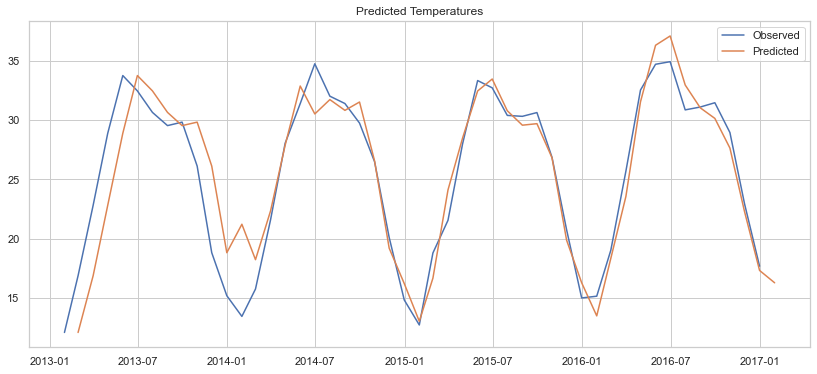

In [173]:
# We end up using SARIMA((0, 1, 1), (1, 1, 0, 12)

model = SARIMAX(monthly_train_data, order=(0, 1, 1), seasonal_order=(1, 1, 0, 12))
fit = model.fit()
y_hat = fit.predict(1, len(monthly_train_data))
fig = plt.figure(figsize=(14,6))
plt.plot(monthly_train_data, label='Observed')
plt.plot(y_hat, label='Predicted')
plt.title('Predicted Temperatures')
plt.legend()
plt.show()

In [175]:
monthly_test_data = test_data['meantemp'].resample('M').mean()

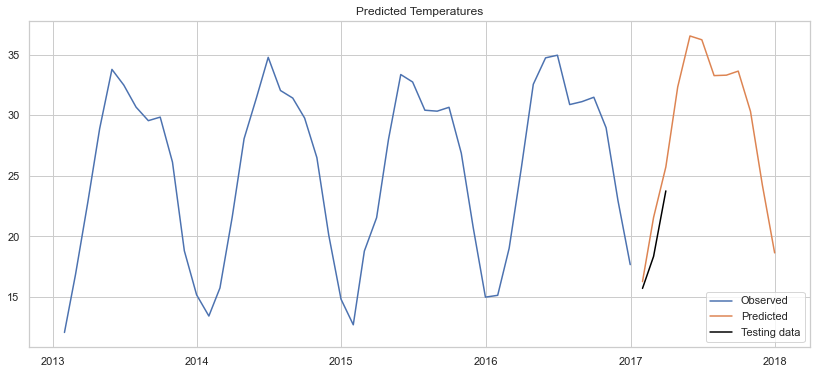

In [177]:
forecast = fit.forecast(12)
fig = plt.figure(figsize=(14,6))
plt.plot(monthly_train_data, label='Observed')
plt.plot(forecast, label='Predicted')
plt.plot(monthly_test_data, color='black', label='Testing data')
plt.title('Predicted Temperatures')
plt.legend()
plt.show()

In [178]:
print(forecast)

2017-01-31    16.270114
2017-02-28    21.562530
2017-03-31    25.729262
2017-04-30    32.326142
2017-05-31    36.534580
2017-06-30    36.219375
2017-07-31    33.264138
2017-08-31    33.300362
2017-09-30    33.635400
2017-10-31    30.306465
2017-11-30    24.233838
2017-12-31    18.641943
Freq: M, Name: predicted_mean, dtype: float64


In [ ]:
# import pmdarima as pm  # Assuming you're using the pmdarima library 
# from statsmodels.tsa.statespace.sarimax import SARIMAX 
# import matplotlib.pyplot as plt

# # Data preparation (assuming you have train_data and test_data)

# # Initial exploration with auto_arima (optional)
# initial_model = pm.auto_arima(train_data['meantemp'], start_p=1, start_q=1, test='adf',
#                               m=12, seasonal=True, trace=True)

# # Specify the SARIMAX model
# sarimax_model = SARIMAX(train_data['meantemp'], 
#                         order=(1, 1, 1), 
#                         seasonal_order=(1, 0, 1, 12)
#                        )

# # Fit the SARIMAX model
# fitted_model = sarimax_model.fit()  

# # Generate predictions on training data (optional)
# train_predictions = fitted_model.predict()

# # Evaluation on training data (optional)
# training_resid = train_data['meantemp'] - train_predictions
# training_mae = abs(training_resid.mean())

# # ... (plots and analysis of residuals)

# # Generate predictions on test data 
# test_predictions = fitted_model.predict(len(test_data))  # Assuming you want to predict as many steps as the length of test_data

# # Evaluation on test data 
# test_resid = test_data['meantemp'] - test_predictions
# test_mae = abs(test_resid.mean())

# # ... (plots and analysis of residuals on test data)

# # Visualization of train, test, and predictions
# plt.figure(figsize=(20, 6))
# plt.plot(train_data['meantemp'], color='green', label='Training data')
# plt.plot(test_data['meantemp'], color='black', label='Testing data')
# plt.plot(test_predictions, color='red', label='Predicted')
# plt.xlabel('Time')
# plt.ylabel('Mean Temp Values')
# plt.legend()
# plt.show()
